## <font color=#0099CC>mIAx - Taller Renta Fija - ANÁLISIS CARTERA DE RENTA FIJA</font>

En esta práctica, desarrollaremos un análisis relativamente exahustivo de un universo de Renta Fija, en concreto, de bonos corporativos. Además, construiremos y analizaremos varias carteras. 

Para ello, contaremos con la siguiente información almacenada en la carpeta *data*:
- Universo de bonos, con sus características esenciales (fichero *universo.csv*)
- Histórico de precios de cierre del universo de bonos anterior (fichero *precios_historicos_universo.csv*)
- Curva de tipos de interés €STR (fichero *curvaESTR.csv*)
- Histórico de precios de otros índices que nos serán de utilidad (fichero *precios_historicos_varios*):
    - Índices de crédito: ITRAXX Main y ITRAXX XOVER. Serán útiles para la cobertura del riesgo de crédito.
    - Futuros sobre el *Schatz* (DU1), *BOBL* (OE1) y *BUND* (RX1). Serán útiles para la cobertura de los tipos de interés.
    - Índice de crédito *RECMTREU*, que valdría como benchmark de las carteras que construyamos.

No necesariamente se usará toda toda la información

En líneas generales, estos son los ejercicios que completaremos, aunque los detallaremos más en cada apartado:
1. Análisis de datos. En esta sección, haremos un análisis de la información que tenemos de cada bono y lo que significa. Asimismo, haremos los tratamientos y limpieza que necesitemos para luego poder usarlos.
2. Valoración de los bonos del universo utilizando la curva de descuento y bajo ciertas asunciones. Comparación de estos precios con los precios de mercado.
3. Cálculo del spread que pagan los bonos sobre la curva.
4. Cálculo de *yield*, duración y convexidad.
5. Contrucción de una cartera equiponderada con todos los bonos del universo. Contraste con el benchmark (os proponemos el índice RECMTREU para el que os hemos dado los precios) y backtest de la estrategia. ¡OJO! El índice es *Total Return*.
6. Tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
    - La duración de la cartera no debe superar los 3 años
    - La exposición a emisiones HY no puede superar el 10% de la cartera
    - No puedes invertir en deuda subordinada
    - No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
    - No se puede invertir más de un 10% del capital en una misma emisión
    - No puede haber más de un 15% de concentración en un mismo emisor
    (¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

    6.1. Constrúyela a fecha de hoy

    6.2. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

    6.3. ¿Cómo medirías el riesgo de crédito de la cartera?

    6.4. ¿Cómo medirías el riesgo de liquidez de la cartera?

    6.5. Describe cómo habría que hacer el backtest de esta cartera
7. Ahora, se te pide que cubras la exposición de la cartera a los tipos de interés. Con la información que tienes, ¿cómo lo harías?
8. ¿Y si quisieras cubrir total o parcialmente el riesgo de crédito? Usa de nuevo la información que tienes.
9. ¿Cómo construirías tu cartera? ¿Se te ocurre alguna estrategia específica, por ejemplo, de valor relativo?


📣 <font color=#CC6600>**¡NORMAS!**</font>

La práctica se puede hacer en grupos de hasta **3 personas** y deberá entregarse antes del **27 de noviembre**. 

Cada grupo expondrá una parte de los ejercicios en la clase del día 27, donde la resolveremos juntos a modo de taller. Esta exposición contará hasta **1 punto** de la nota final.

Además, se valorará positivamente para la práctica la participación en las clases.

📣 <font color=#CC6600>**¡IMPORTANTE!**</font>

Todo el código implementado debe estar debidamente comentado e incluir conclusiones de los resultados obtenidos para optar a la máxima puntuación. Asimismo, se debe responder a las preguntas planteadas.

Las propuestas de mejora o posibles trabajos futuros se valorarán positivamente también.

Usa las fuentes de información que consideres necesarias para apoyar tus respuestas.

### <font color=#336699>Librerías</font>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
from scipy import interpolate
from scipy.optimize import fsolve, brentq


In [ ]:
# Estilo
plt.style.use('dark_background')

In [ ]:
# Fecha de análisis
fecha_analisis = pd.to_datetime('2025-10-01')

### <font color=#336699>1. Datos</font>

<style>.gray {background-color: #595959}

</style><div class="gray">❕💬¿Qué observas en los datos? Analiza la información que tenemos del universo</div>

Haz un primer análisis visual de la información que tenemos del universo de bono.
Entre otras, plantéate cuestiones como:
- ¿Divisas?
- ¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?
- ¿Sectores? ¿Emisores? Si invirtéramos en todos los bonos, ¿dirías a priori que la cartera está diversificada?
- ¿Ratings? (Riesgo de crédito)
- ¿Otros datos cuantitativos?
    - Riesgo de liquidez - Horquillas y nominal vivo
- ¿Hay *gaps* en la información que vamos a tener que tratar?

In [ ]:
# Cargamos el universo de bonos
universo = pd.read_csv('../data/universo.csv', sep=';', decimal='.')

'''
 INFORMACIÓN BÁSICA DEL DATASET
 --------------------------------------------------------------------------
 Mostramos estadísticas básicas para entender la estructura de los datos:
 - Total de bonos disponibles
 - Lista de columnas (variables) disponibles
 - Primeras filas para ver un ejemplo de los datos
 - Imprimmimos valores nulos por columna 
    - Alertas específicas para columnas críticas (Maturity, Price)
'''

def reportar_gaps_informacion(df, nombre_dataset):
    """
    Analiza un DataFrame e imprime un reporte de las columnas que contienen valores nulos (NaN/NaT).
    Muestra la cantidad absoluta y el porcentaje respecto al total.
    """
    print(f"\n{'='*60}")
    print(f" ANÁLISIS DE VALORES NULOS: {nombre_dataset}")
    print(f"{'='*60}")
    
    # Calcular nulos y porcentajes
    total_filas = len(df)
    nulos = df.isnull().sum()
    nulos = nulos[nulos > 0] # Filtramos solo las columnas que tienen nulos
    
    if nulos.empty:
        print(f" No se encontraron valores nulos en '{nombre_dataset}'.")
        return
    
    porcentaje = (nulos / total_filas) * 100
    
    # Crear DataFrame para visualizar mejor
    df_nulos = pd.DataFrame({
        'Tipo de Dato': df[nulos.index].dtypes,
        'Cantidad Nulos': nulos,
        'Porcentaje (%)': porcentaje.round(2)
    })
    
    # Ordenar de mayor a menor cantidad de nulos
    df_nulos = df_nulos.sort_values(by='Cantidad Nulos', ascending=False)
    
    print(f"Total de filas: {total_filas}")
    print(f"Columnas con datos faltantes: {len(df_nulos)}")
    print("-" * 60)
    print(df_nulos)
    
    # Alertas específicas para columnas críticas
    if 'Maturity' in df_nulos.index:
        print(f"\n ALERTA CRÍTICA: Faltan fechas de vencimiento en {df_nulos.loc['Maturity', 'Cantidad Nulos']} bonos.")
    if 'Price' in df_nulos.index:
        print(f" ALERTA CRÍTICA: Faltan precios en {df_nulos.loc['Price', 'Cantidad Nulos']} bonos.")



print(f"Total de bonos en el universo: {len(universo)}")
print(f"\nColumnas disponibles: {list(universo.columns)}")
if 'universo' in locals():
    reportar_gaps_informacion(universo, "Universo de Bonos")


Total de bonos en el universo: 2255

Columnas disponibles: ['ISIN', 'Description', 'Ccy', 'Price', 'Issuer', 'Industry Sector', 'Maturity', 'Coupon', 'Rating', 'PD 1YR', 'Outstanding Amount', 'Callable', 'Next Call Date', 'Seniority', 'Coupon Frequency', 'Coupon Type', 'First Coupon Date', 'Penultimate Coupon Date', 'Issue date', 'Bid Price', 'Ask Price']

 ANÁLISIS DE VALORES NULOS: Universo de Bonos
Total de filas: 2255
Columnas con datos faltantes: 5
------------------------------------------------------------
                        Tipo de Dato  Cantidad Nulos  Porcentaje (%)
Next Call Date                object             615           27.27
PD 1YR                       float64              24            1.06
Maturity                      object              19            0.84
Penultimate Coupon Date       object              19            0.84
Rating                        object               1            0.04

 ALERTA CRÍTICA: Faltan fechas de vencimiento en 19 bonos.


Tras el análisis de vlores nulos encontrados en el documento "universo.csv" nos encontramos que:

1.- Hay 615 valores nulos en la columna " Next Call Date" seguramente por que estos no sean bonos "Callable".

2.- Faltan 24 datos de Probabilidad de Default a 1 año. Si queremos calcular el riesgo de crédito o pérdida esperada, estos bonos darán error.

3.- Hay 19 bonos con "Maturity" nula. Seguramente sean bonos prepetuos, pero si queremos calcular la duración o el rendimiento a vencimiento (YTM), se tendrá que imponer alguna condición.

4.- Hay un valor con rating nulo.

También habrá que convertir las fechas a formato "datetime" y convertir a booleano la columna "Callable" para poder operar con estos valores.

In [ ]:
# Limpieza básica tras la carga del universo
#Cambiamos a formato datetime los campos de fecha y reemplazamos strings vacíos por NaN
campos_fecha = ['Maturity', 'Next Call Date', 'First Coupon Date', 'Penultimate Coupon Date', 'Issue date']
for campo in campos_fecha:
    if campo in universo.columns:
        universo[campo] = universo[campo].replace('', pd.NA)
        universo[campo] = pd.to_datetime(universo[campo], errors='coerce')

# Converimos a booleano la columna Callable
if 'Callable' in universo.columns:
    universo['Callable'] = (universo['Callable']
                            .fillna('N')
                            .astype(str)
                            .str.upper()
                            .str.strip())

display(universo.head(10))

C:\Users\gonde\AppData\Local\Temp\ipykernel_10900\3762119236.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  universo[campo] = pd.to_datetime(universo[campo], errors='coerce')
C:\Users\gonde\AppData\Local\Temp\ipykernel_10900\3762119236.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  universo[campo] = pd.to_datetime(universo[campo], errors='coerce')
C:\Users\gonde\AppData\Local\Temp\ipykernel_10900\3762119236.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  universo[campo] = pd.to_datetime(universo[campo], errors='coerce')
C:\Users\gonde\AppData\Local\Temp\ipykernel_10900\3762119236.py:7: UserWarning: Parsing dates in %d/%m/%Y for

,ISIN,Description,Ccy,Price,Issuer,Industry Sector,Maturity,Coupon,Rating,PD 1YR,...,Callable,Next Call Date,Seniority,Coupon Frequency,Coupon Type,First Coupon Date,Penultimate Coupon Date,Issue date,Bid Price,Ask Price
0,XS0161488498,DT 7 ½ 01/24/33,EUR,127.8353,DEUTSCHE TELEKOM INT FIN,Communications,2033-01-24,7.500,BBB+,2.196619e-02,...,N,NaT,Sr Unsecured,1,FIXED,2004-01-24,2032-01-24,2003-01-24,127.462,128.208
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,EUR,131.3195,ORANGE SA,Communications,2033-01-28,8.125,BBB+,2.142390e-05,...,N,NaT,Sr Unsecured,1,FIXED,2004-01-28,2032-01-28,2003-01-28,130.991,131.648
2,XS0162513211,EOANGR 5 ¾ 02/14/33,EUR,115.7800,E.ON INTL FINANCE BV,Utilities,2033-02-14,5.750,BBB+,1.008200e-04,...,N,NaT,Sr Unsecured,1,FIXED,2004-02-14,2032-02-14,2003-02-14,115.447,116.114
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,EUR,116.3000,TELEFONICA EUROPE BV,Communications,2033-02-14,5.875,BBB-,1.249580e-04,...,N,NaT,Sr Unsecured,1,FIXED,2004-02-14,2032-02-14,2003-02-14,115.984,116.616
4,FR0010014845,PEUGOT 6 09/19/33,EUR,112.3887,PSA TRESORERIE GIE,"Consumer, Cyclical",2033-09-19,6.000,BBB,2.423967e-02,...,N,NaT,Sr Unsecured,1,FIXED,2004-09-19,2032-09-19,2003-09-19,111.839,112.938
5,FR0010033381,VIEFP 6 ⅛ 11/25/33,EUR,119.7020,VEOLIA ENVIRONNEMENT SA,Utilities,2033-11-25,6.125,BBB,2.005240e-04,...,N,NaT,Sr Unsecured,1,FIXED,2004-11-25,2032-11-25,2003-11-25,119.299,120.105
6,XS0229567440,GE 4 ⅛ 09/19/35,EUR,105.4562,GENERAL ELECTRIC CO,Industrial,2035-09-19,4.125,A-,5.118290e-06,...,N,NaT,Sr Unsecured,1,FIXED,2006-09-19,2034-09-19,2005-09-19,105.115,105.798
7,XS0300113254,PG 4 ⅞ 05/11/27,EUR,104.0970,PROCTER & GAMBLE CO/THE,"Consumer, Non-cyclical",2027-05-11,4.875,AA-,1.474460e-07,...,N,NaT,Sr Unsecured,1,FIXED,2008-05-11,2026-05-11,2007-05-11,104.013,104.180
8,XS0350890470,GE 6.025 03/01/38,EUR,124.7700,GE CAPITAL EURO FUNDING,Industrial,2038-03-01,6.025,A-,5.118290e-06,...,N,NaT,Sr Unsecured,1,FIXED,2009-03-01,2037-03-01,2008-03-06,124.175,125.364
9,XS0553728709,DT 4 ½ 10/28/30,EUR,108.6433,DEUTSCHE TELEKOM INT FIN,Communications,2030-10-28,4.500,BBB+,2.196619e-02,...,N,NaT,Sr Unsecured,1,FIXED,2011-10-28,2029-10-28,2010-10-28,108.379,108.908


#### <font color=#808080>Divisas</font>

Distribución de divisas:
Ccy
EUR    2255
Name: count, dtype: int64

Total de divisas diferentes: 1

Porcentaje por divisa:
EUR: 100.00%


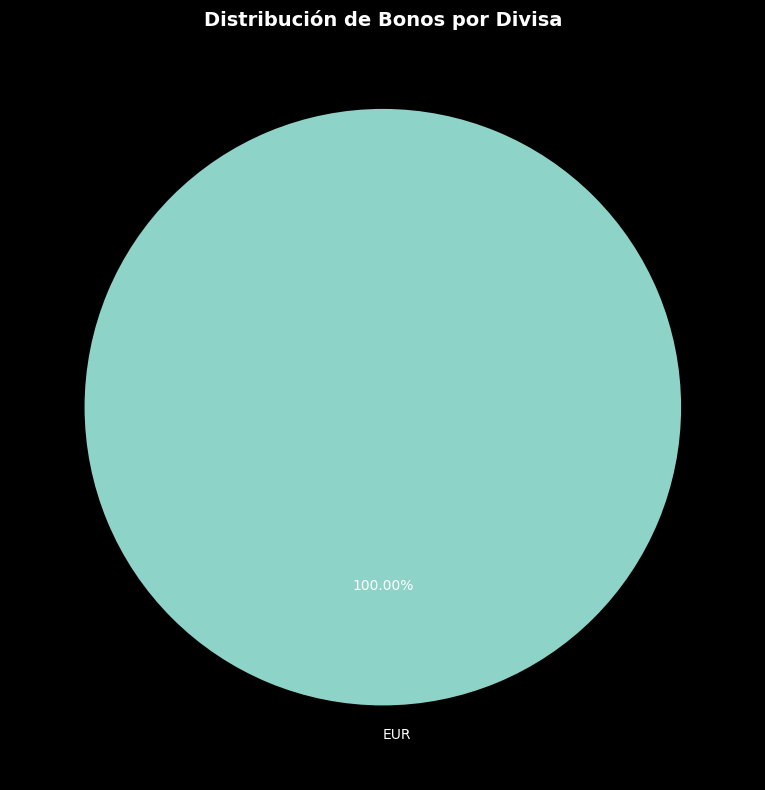

In [ ]:

# ANÁLISIS DE DIVISAS:
# Analizamos la distribución de bonos por divisa (moneda)
# Esto es importante porque afecta al riesgo cambiario de la cartera


# Contamos cuántos bonos hay de cada divisa
divisas = universo['Ccy'].value_counts()

print("Distribución de divisas:")
print(divisas)
print(f"\nTotal de divisas diferentes: {len(divisas)}")
print(f"\nPorcentaje por divisa:")
for ccy, count in divisas.items():
    pct = (count / len(universo)) * 100
    print(f"{ccy}: {pct:.2f}%")

# 
# VISUALIZACIÓN DE DIVISAS:
# Creamos un pie chart para visualizar mejor la distribución

# Ajustamos el tamaño a (8, 8) para asegurar que el círculo no se vea ovalado
fig, ax = plt.subplots(figsize=(8, 8))

divisas.plot(
    kind='pie', 
    ax=ax, 
    autopct='%1.2f%%',    # Muestra el porcentaje con 2 decimales
    startangle=90,        # Empieza a rotar desde la parte superior (12 en punto)
    shadow=False,         # (Opcional) Sombra para efecto 3D
    legend=False          # Ocultamos la leyenda si las etiquetas son claras
)

ax.set_ylabel('')  # Eliminamos la etiqueta automática del eje Y que pone pandas
ax.set_title('Distribución de Bonos por Divisa', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Se puede observar claramente como el 100% de los bonos tienen como divisa el Euro.

#### <font color=#808080>Tipos de bono</font>

In [ ]:
# ANÁLISIS DE TIPOS DE BONO:
# Analizamos diferentes características de los bonos que afectan a su
# valoración y riesgo: tipo de cupón, prelación, opcionalidad y perpetuos
#


# 1. TIPO DE CUPÓN (FIJO VS VARIABLE):
# Los bonos pueden tener cupón fijo (tasa constante) o variable (tasa flotante)
# Esto afecta a la sensibilidad a cambios en tipos de interés

tipo_cupon = universo['Coupon Type'].value_counts()
print("Distribución por tipo de cupón:")
print(tipo_cupon)
print(f"\nPorcentaje:")
for tipo, count in tipo_cupon.items():
    pct = (count / len(universo)) * 100
    print(f"{tipo}: {pct:.2f}%")


# 2. PRELACIÓN (SENIORITY):
# La prelación determina el orden de pago en caso de quiebra del emisor
# Senior tiene prioridad sobre Subordinated

prelacion = universo['Seniority'].value_counts()
print(f"\n\nDistribución por prelación:")
print(prelacion)
print(f"\nPorcentaje:")
for sen, count in prelacion.items():
    pct = (count / len(universo)) * 100
    print(f"{sen}: {pct:.2f}%")


# 3. OPCIONALIDAD (CALLABLE):
# Los bonos callable pueden ser recomprados por el emisor antes del vencimiento
# Esto introduce riesgo de reinversión para el inversor

callable_bonds = universo['Callable'].value_counts()
print(f"\n\nBonos con opción de compra (Callable):")
print(callable_bonds)
print(f"\nPorcentaje:")
for call, count in callable_bonds.items():
    pct = (count / len(universo)) * 100
    print(f"{call}: {pct:.2f}%")


# 4. BONOS PERPETUOS (SIN FECHA DE VENCIMIENTO):
# Los bonos perpetuos no tienen fecha de vencimiento fija
# Para valoración, usaremos la próxima fecha call como vencimiento

perpetuos = universo[universo['Maturity'].isna()]
print(f"Bonos perpetuos encontrados: {len(perpetuos)}")


Distribución por tipo de cupón:
Coupon Type
FIXED       1910
VARIABLE     345
Name: count, dtype: int64

Porcentaje:
FIXED: 84.70%
VARIABLE: 15.30%


Distribución por prelación:
Seniority
Sr Unsecured        1675
Sr Non Preferred     190
Sr Preferred         179
Subordinated         153
Jr Subordinated       25
Secured               20
1st lien              13
Name: count, dtype: int64

Porcentaje:
Sr Unsecured: 74.28%
Sr Non Preferred: 8.43%
Sr Preferred: 7.94%
Subordinated: 6.78%
Jr Subordinated: 1.11%
Secured: 0.89%
1st lien: 0.58%


Bonos con opción de compra (Callable):
Callable
Y    1640
N     615
Name: count, dtype: int64

Porcentaje:
Y: 72.73%
N: 27.27%
Bonos perpetuos encontrados: 19


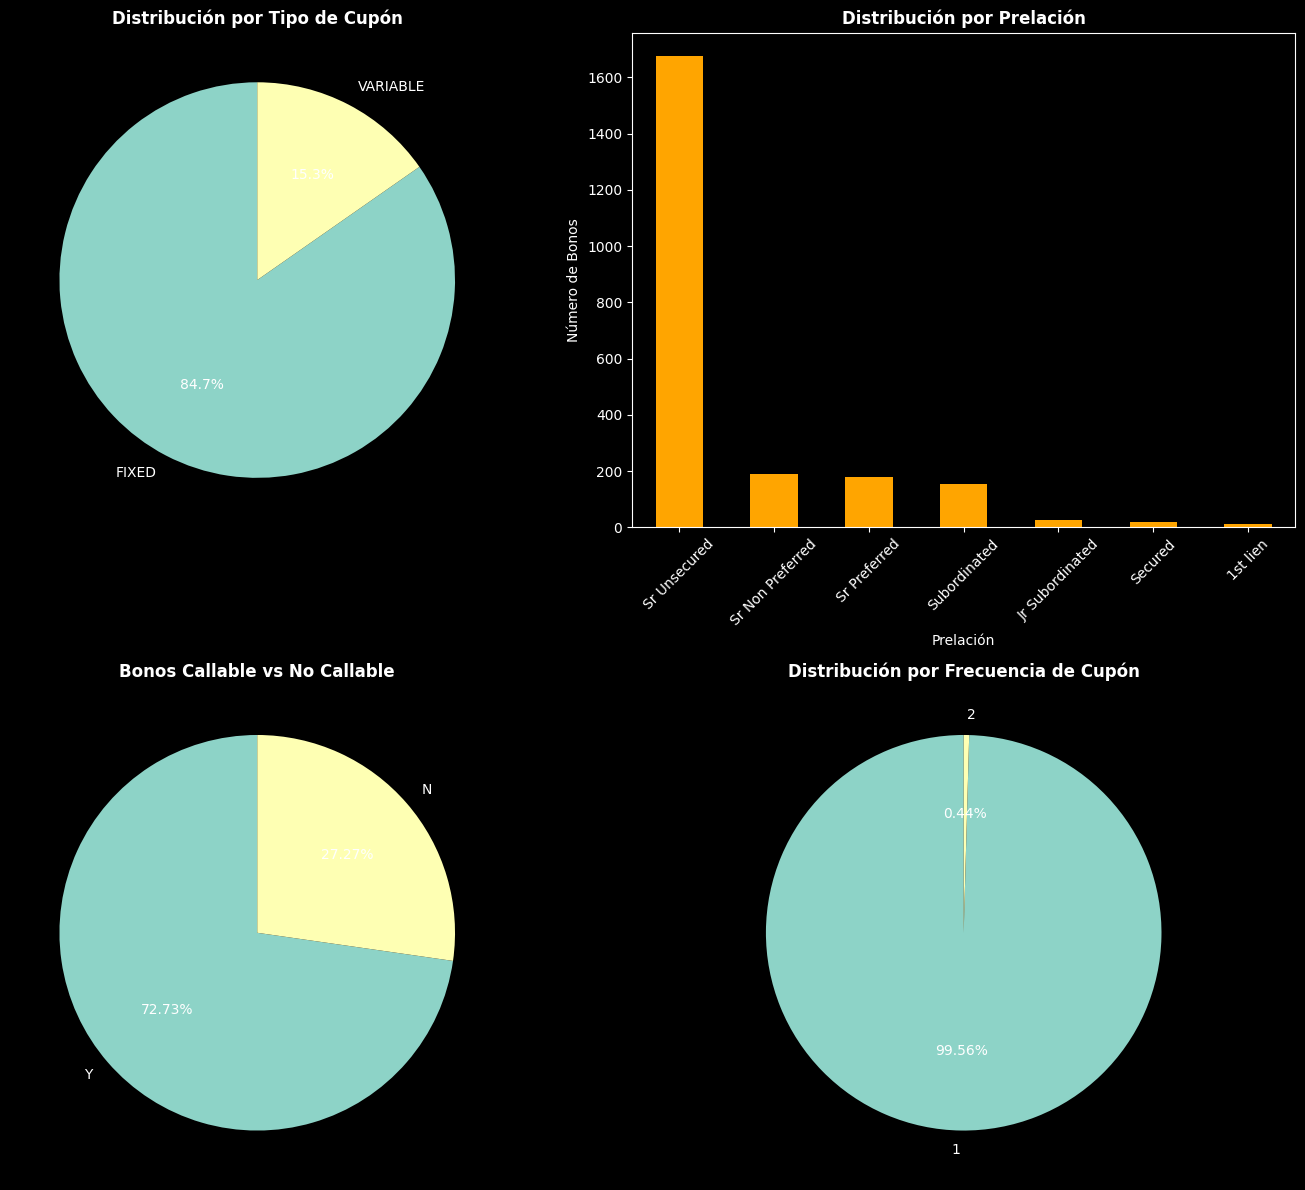

In [ ]:
# VISUALIZACIONES DE TIPOS DE BONO:
# Creamos un panel de 4 gráficos para visualizar todas las características
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# --- Gráfico 1: Tipo de cupón ---
tipo_cupon.plot(
    kind='pie', 
    ax=axes[0, 0], 
    autopct='%1.1f%%', 
    startangle=90, 
    ylabel='' # Ocultar etiqueta del eje Y
)
axes[0, 0].set_title('Distribución por Tipo de Cupón', fontsize=12, fontweight='bold')

# --- Gráfico 2: Prelación ---
prelacion.plot(kind='bar', ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Distribución por Prelación', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Prelación')
axes[0, 1].set_ylabel('Número de Bonos')
axes[0, 1].tick_params(axis='x', rotation=45)

# --- Gráfico 3: Callable ---
callable_bonds.plot(
    kind='pie', 
    ax=axes[1, 0], 
    autopct='%1.2f%%', 
    startangle=90, 
    ylabel='',
    

)
axes[1, 0].set_title('Bonos Callable vs No Callable', fontsize=12, fontweight='bold')

# --- Gráfico 4: Frecuencia de cupón ---
freq_cupon = universo['Coupon Frequency'].value_counts()
freq_cupon.plot(
    kind='pie', 
    ax=axes[1, 1], 
    autopct='%1.2f%%', 
    startangle=90, 
    ylabel=''
)
axes[1, 1].set_title('Distribución por Frecuencia de Cupón', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


#### <font color=#808080>Sectores y emisores</font>

Distribución por sectores:
Industry Sector
Financial                 1012
Consumer, Non-cyclical     400
Industrial                 211
Communications             175
Consumer, Cyclical         171
Utilities                  150
Basic Materials             72
Technology                  51
Energy                      13
Name: count, dtype: int64

Total de sectores diferentes: 9


Total de emisores diferentes: 613

Top 10 emisores por número de emisiones:
Issuer
BANQUE FED CRED MUTUEL     33
BNP PARIBAS                27
VONOVIA SE                 23
BPCE SA                    23
ORANGE SA                  23
SOCIETE GENERALE           21
VOLKSWAGEN INTL FIN NV     21
NESTLE FINANCE INTL LTD    20
UNIBAIL-RODAMCO-WESTFLD    19
CREDIT AGRICOLE SA         19
Name: count, dtype: int64


Concentración de los top 10 emisores: 10.16%
Concentración del top emisor: 1.46%


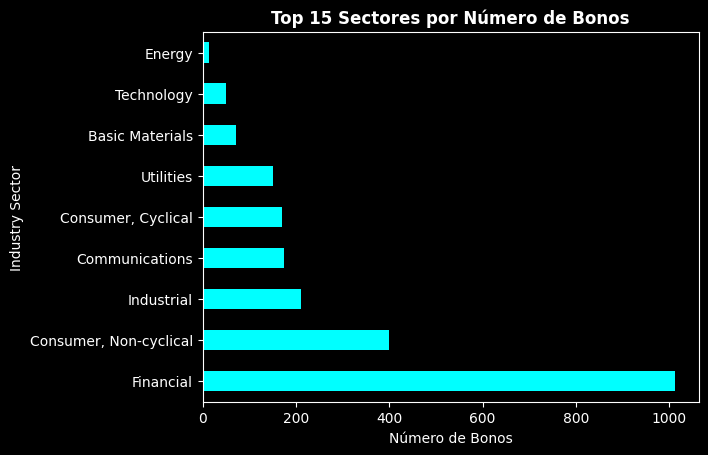

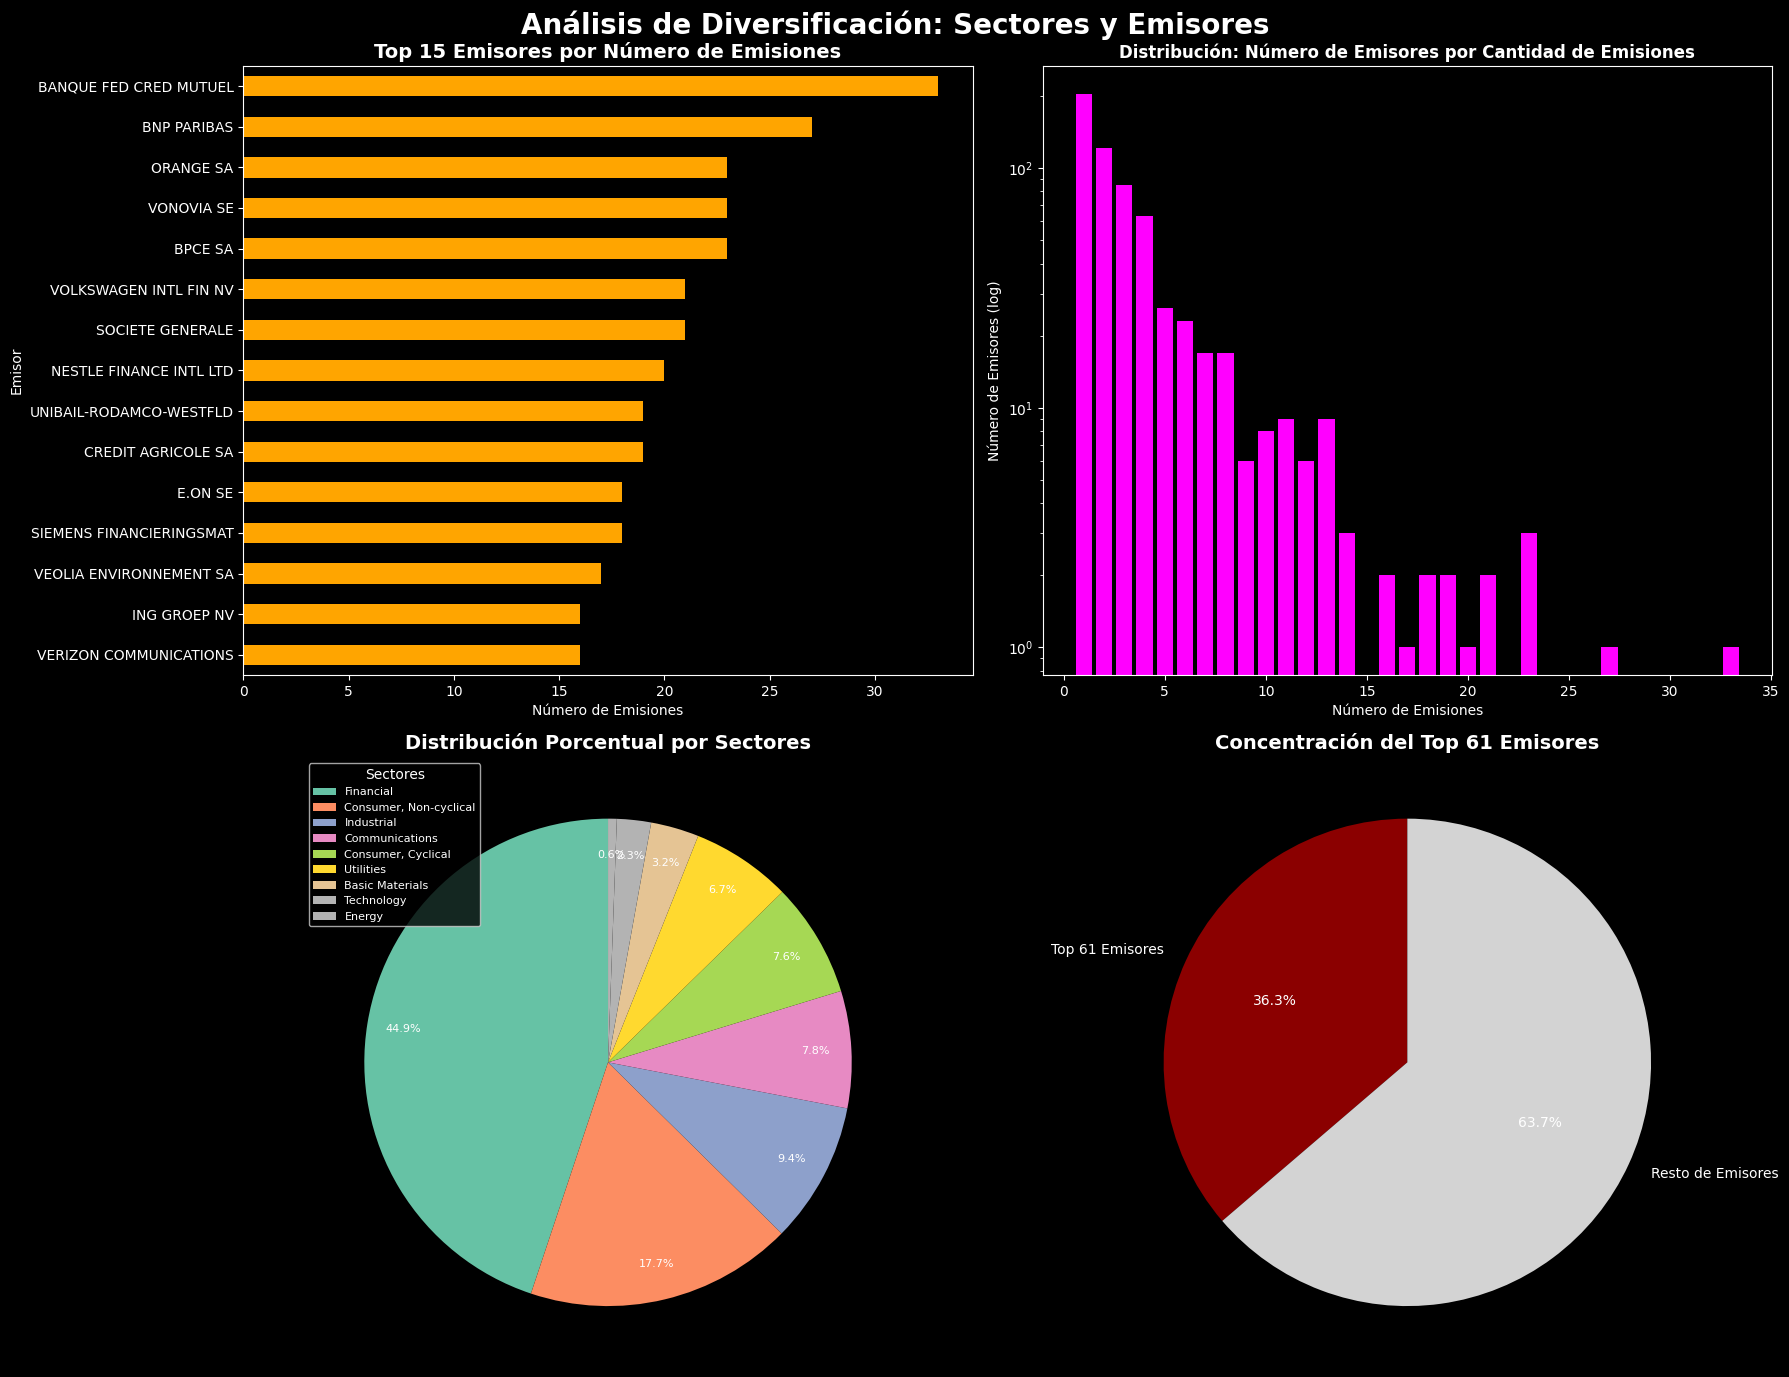


ANÁLISIS DE DIVERSIFICACIÓN DE CARTERA EQUIPONDERADA

1. DIVERSIFICACIÓN HORIZONTAL = EXCELENTE
• 2,255 bonos = riesgo casi eliminado
• 613 emisores con top 1 solo 1.46% = protección contra defaults
• Top 10 emisores: 10.16% = baja concentración por emisor
• Comparable a índices profesionales (iBoxx ~2,500 bonos)

✓ EXCELENTE diversificación horizontal: muchos jugadores (bonos) de diferentes equipos (emisores)

2. DIVERSIFICACIÓN VERTICAL = PREOCUPANTE
• 44.9% en sector financiero vs ~30% en benchmarks (+14.9pp sobreexpuesto)
• HHI sectorial: 2594 (>2,500 = alta concentración)

 RIESGO SISTÉMICO BANCARIO:
   - Bancos interconectados (se prestan entre sí)

• Sectores defensivos bajos: Energy 0.6%, Tech 2.3%, Utilities 6.7%

 PREOCUPANTE diversificación vertical: demasiados juegan en la misma posición (sector financiero)

5. RECOMENDACIONES
• Limitar financiero a ≤30%
• Aumentar defensivos: Energy 5%, Tech 8%, Utilities 10%

CONCLUSIÓN GENERAL:
EXCELENTE diversificación horizontal (bono

In [ ]:
# ANÁLISIS DE SECTORES Y EMISORES:
# Analizamos la diversificación de la cartera por sector industrial y emisor
# Una cartera bien diversificada reduce el riesgo de concentración


# 1. DISTRIBUCIÓN POR SECTORES:
# Contamos cuántos bonos hay en cada sector industrial

sectores = universo['Industry Sector'].value_counts()
print("Distribución por sectores:")
print(sectores)
print(f"\nTotal de sectores diferentes: {len(sectores)}")


# 2. DISTRIBUCIÓN POR EMISORES:
# Contamos cuántas emisiones tiene cada emisor
# Esto nos ayuda a identificar concentración por emisor


emisores = universo['Issuer'].value_counts()
print(f"\n\nTotal de emisores diferentes: {len(emisores)}")
print(f"\nTop 10 emisores por número de emisiones:")
print(emisores.head(10))


# 3. ANÁLISIS DE CONCENTRACIÓN:
# Calculamos la concentración de la cartera si fuera equiponderada
# Una alta concentración aumenta el riesgo de la cartera


peso_por_emisor = emisores / len(universo) * 100
concentracion_top10 = peso_por_emisor.head(10).sum()
print(f"\n\nConcentración de los top 10 emisores: {concentracion_top10:.2f}%")
print(f"Concentración del top emisor: {peso_por_emisor.iloc[0]:.2f}%")

# ============================================================================
# VISUALIZACIONES DE SECTORES Y EMISORES
# ============================================================================
# Creamos un panel de 4 gráficos para analizar la diversificación
# ============================================================================


fig= figsize=(16, 12)
# Sectores - Top 15
sectores.head(15).plot(kind='barh', color='cyan')
plt.title('Top 15 Sectores por Número de Bonos', fontsize=12, fontweight='bold')
plt.xlabel('Número de Bonos')


fig, axes = plt.subplots(2, 2, figsize=(18, 14))
plt.suptitle('Análisis de Diversificación: Sectores y Emisores', fontsize=20, fontweight='bold')

# --- 1. Top 15 Emisores (Mantenido - Barras Horizontales) ---
emisores.head(15).sort_values(ascending=True).plot(
    kind='barh', 
    ax=axes[0, 0], 
    color='orange'
)
axes[0, 0].set_title('Top 15 Emisores por Número de Emisiones', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Número de Emisiones')
axes[0, 0].set_ylabel('Emisor')


# Distribución de número de emisiones por emisor
num_emisiones_por_emisor = emisores.value_counts().sort_index()
axes[0, 1].bar(num_emisiones_por_emisor.index, num_emisiones_por_emisor.values, color='magenta')
axes[0, 1].set_title('Distribución: Número de Emisores por Cantidad de Emisiones', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Número de Emisiones')
axes[0, 1].set_ylabel('Número de Emisores (log)')
axes[0, 1].set_yscale('log')

# --- 3. Distribución Porcentual por Sectores (NUEVO - Gráfico Circular) ---
# Ajustamos el gráfico para evitar solapamiento de etiquetas
wedges, texts, autotexts = axes[1, 0].pie(
    sectores.values,
    labels=None,  # No mostramos etiquetas en el gráfico para evitar solapamiento
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Set2(range(len(sectores))),
    pctdistance=0.85,
    textprops={'fontsize': 8}
)

# Añadimos leyenda fuera del gráfico para evitar solapamiento
axes[1, 0].legend(
    wedges, 
    sectores.index, 
    title="Sectores",
    loc="best",
    fontsize=8,
    frameon=True
)
axes[1, 0].set_title('Distribución Porcentual por Sectores', fontsize=14, fontweight='bold')


# --- 4. Concentración del Top 10% Emisores (NUEVO - Gráfico Circular) ---
# 3. Concentración para el Gráfico Circular
# Calcular el 10% del total de emisores
total_emisores = len(emisores)
num_emisores_top10pct = max(1, round(total_emisores * 0.10))

# Sumar las emisiones del Top 10% de emisores
top_emisores_count = emisores.head(num_emisores_top10pct).sum()
rest_emisores_count = len(universo) - top_emisores_count

# Crear la serie para el gráfico circular de concentración
concentracion_data = pd.Series(
    [top_emisores_count, rest_emisores_count], 
    index=[f'Top {num_emisores_top10pct} Emisores', 'Resto de Emisores']
)
concentracion_data.plot(
    kind='pie', 
    ax=axes[1, 1], 
    autopct='%1.1f%%', 
    startangle=90, 
    ylabel='', 
    colors=['darkred', 'lightgray']
)
axes[1, 1].set_title(f'Concentración del Top {num_emisores_top10pct} Emisores', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

# ============================================================================
# ANÁLISIS DE DIVERSIFICACIÓN HORIZONTAL VS VERTICAL
# ============================================================================
# Calculamos HHI sectorial y porcentajes de distribución
# ============================================================================

# Cálculo de HHI (Herfindahl-Hirschman Index) sectorial
peso_sectorial = sectores / len(universo) * 100
hhi_sectorial = (peso_sectorial ** 2).sum()

# Distribución porcentual por sector
distribucion_sectorial = peso_sectorial.sort_values(ascending=False)
pct_financiero = distribucion_sectorial.get('Financial', 0)
pct_consumer_nc = distribucion_sectorial.get('Consumer, Non-cyclical', 0)
pct_industrial = distribucion_sectorial.get('Industrial', 0)
pct_energy = distribucion_sectorial.get('Energy', 0)
pct_tech = distribucion_sectorial.get('Technology', 0)
pct_utilities = distribucion_sectorial.get('Utilities', 0)

# ============================================================================
# CONCLUSIÓN SOBRE DIVERSIFICACIÓN
# ============================================================================
# Análisis completo de diversificación horizontal (bonos/emisores) 
# vs vertical (sectores)
# ============================================================================

print(f"\n{'='*80}")
print("ANÁLISIS DE DIVERSIFICACIÓN DE CARTERA EQUIPONDERADA")
print(f"{'='*80}")

print(f"\n{'='*80}")
print("1. DIVERSIFICACIÓN HORIZONTAL = EXCELENTE")
print(f"{'='*80}")
print(f"• 2,255 bonos = riesgo casi eliminado")
print(f"• 613 emisores con top 1 solo {peso_por_emisor.iloc[0]:.2f}% = protección contra defaults")
print(f"• Top 10 emisores: {concentracion_top10:.2f}% = baja concentración por emisor")
print(f"• Comparable a índices profesionales (iBoxx ~2,500 bonos)")
print(f"\n✓ EXCELENTE diversificación horizontal: muchos jugadores (bonos) de diferentes equipos (emisores)")

print(f"\n{'='*80}")
print("2. DIVERSIFICACIÓN VERTICAL = PREOCUPANTE")
print(f"{'='*80}")
print(f"• {pct_financiero:.1f}% en sector financiero vs ~30% en benchmarks (+{pct_financiero-30:.1f}pp sobreexpuesto)")
print(f"• HHI sectorial: {hhi_sectorial:.0f} (>2,500 = alta concentración)")
print(f"\n RIESGO SISTÉMICO BANCARIO:")
print(f"   - Bancos interconectados (se prestan entre sí)")
print(f"\n• Sectores defensivos bajos: Energy {pct_energy:.1f}%, Tech {pct_tech:.1f}%, Utilities {pct_utilities:.1f}%")
print(f"\n PREOCUPANTE diversificación vertical: demasiados juegan en la misma posición (sector financiero)")

print(f"\n{'='*80}")
print("5. RECOMENDACIONES")
print(f"{'='*80}")
print("• Limitar financiero a ≤30%")
print("• Aumentar defensivos: Energy 5%, Tech 8%, Utilities 10%")

print(f"\n{'='*80}")
print("CONCLUSIÓN GENERAL:")
print(f"{'='*80}")
print("EXCELENTE diversificación horizontal (bonos/emisores) pero")
print("PREOCUPANTE diversificación vertical (sectores) por alta")
print(f"concentración en financiero ({pct_financiero:.1f}%) y su riesgo sistémico")
print(f"{'='*80}")


Se observa que el 44,9% de los bonos tienen como emisor empresas del sector financiero. Provocando una gran dependencia de este sector y un riesgo sistémico. También cabe notar que hay una cierta diversificación entre los emsisores más numerosos ya que los diez emisores con mas bonos tienen el 10% de la cartera. Al mismo tiempo el top 10% de emisores solo abarca el 36% de los bonos de la cartera.

#### <font color=#808080>Ratings (Riesgo de crédito)</font>

Distribución de ratings:
Rating
A       230
A+      185
A-      374
AA       22
AA+       7
AA-     100
AAA       4
BB+      10
BBB     310
BBB+    439
BBB-    184
NR      389
Name: count, dtype: int64

Total de ratings diferentes: 12

Porcentaje por rating:
A: 10.20%
A+: 8.20%
A-: 16.59%
AA: 0.98%
AA+: 0.31%
AA-: 4.43%
AAA: 0.18%
BB+: 0.44%
BBB: 13.75%
BBB+: 19.47%
BBB-: 8.16%
NR: 17.25%


Clasificación por categoría de riesgo:
Rating_Class
Investment Grade    1855
No Rating            390
High Yield            10
Name: count, dtype: int64

Porcentaje:
Investment Grade: 82.26%
No Rating: 17.29%
High Yield: 0.44%


Análisis de Probabilidad de Default (PD 1YR):
Valores nulos: 24
Estadísticas descriptivas:
count    2.231000e+03
mean     3.616280e-03
std      8.372564e-03
min      2.944640e-12
25%      1.502910e-05
50%      1.253650e-04
75%      1.270443e-03
max      6.312192e-02
Name: PD 1YR, dtype: float64


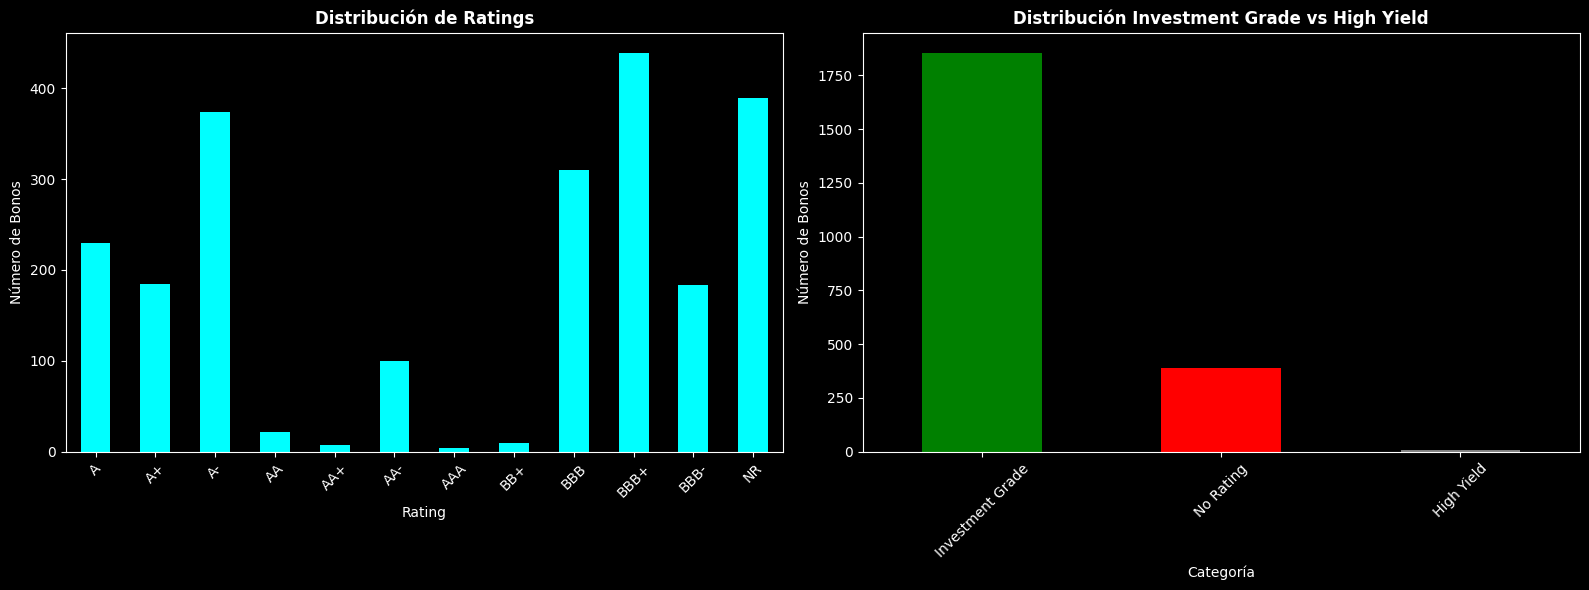

In [ ]:
# ANÁLISIS DE RATINGS (RIESGO DE CRÉDITO):
# El rating es una medida clave del riesgo crediticio de cada bono
# Analizamos la distribución de ratings y los clasificamos en categorías

# DISTRIBUCIÓN DE RATINGS:
# Contamos cuántos bonos hay de cada rating específico

ratings = universo['Rating'].value_counts().sort_index()
print("Distribución de ratings:")
print(ratings)
print(f"\nTotal de ratings diferentes: {len(ratings)}")
print(f"\nPorcentaje por rating:")
for rating, count in ratings.items():
    pct = (count / len(universo)) * 100
    print(f"{rating}: {pct:.2f}%")

# CLASIFICACIÓN INVESTMENT GRADE VS HIGH YIELD:
# Definimos las categorías de ratings:
# - Investment Grade: AAA hasta BBB- (menor riesgo crediticio)
# - High Yield: BB+ hasta D (mayor riesgo crediticio)

investment_grade = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
high_yield = ['BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D']


# FUNCIÓN PARA CLASIFICAR RATINGS:
# Esta función clasifica cada rating en Investment Grade, High Yield o No Rating

def clasificar_rating(rating):
    if pd.isna(rating) or rating == '' or rating == 'NR':
        return 'No Rating'
    rating_clean = str(rating).strip()
    if rating_clean in investment_grade:
        return 'Investment Grade'
    elif rating_clean in high_yield:
        return 'High Yield'
    else:
        return 'No Rating'

# Aplicamos la clasificación a todos los bonos
universo['Rating_Class'] = universo['Rating'].apply(clasificar_rating)
rating_class = universo['Rating_Class'].value_counts()

print(f"\n\nClasificación por categoría de riesgo:")
print(rating_class)
print(f"\nPorcentaje:")
for clase, count in rating_class.items():
    pct = (count / len(universo)) * 100
    print(f"{clase}: {pct:.2f}%")

# ANÁLISIS DE PD (PROBABILIDAD DE DEFAULT A 1 AÑO):
# La PD es una medida cuantitativa del riesgo de impago
# Valores más altos indican mayor probabilidad de default

print(f"\n\nAnálisis de Probabilidad de Default (PD 1YR):")
print(f"Valores nulos: {universo['PD 1YR'].isna().sum()}")
print(f"Estadísticas descriptivas:")
print(universo['PD 1YR'].describe())

# ============================================================================
# VISUALIZACIONES DE RATINGS Y RIESGO DE CRÉDITO
# ============================================================================
# Creamos un panel de 4 gráficos para analizar el riesgo crediticio
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # figsize ajustado para mejor aspecto horizontal

# Distribución de ratings
# Indexación corregida: axes[0]
ratings.plot(kind='bar', ax=axes[0], color='cyan')
axes[0].set_title('Distribución de Ratings', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Número de Bonos')
axes[0].tick_params(axis='x', rotation=45)

# Clasificación IG vs HY
# Indexación corregida: axes[1]
rating_class.plot(kind='bar', ax=axes[1], color=['green', 'red', 'gray'])
axes[1].set_title('Distribución Investment Grade vs High Yield', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Categoría')
axes[1].set_ylabel('Número de Bonos')
axes[1].tick_params(axis='x', rotation=45)

# Ajusta automáticamente el espaciado para que los elementos no se superpongan
plt.tight_layout()

#### <font color=#808080>Riesgo de liquidez - Horquillas y nominal vivo</font>

Análisis de Horquillas (Bid-Ask Spread):
Valores nulos en Bid Price: 0
Valores nulos en Ask Price: 0

Estadísticas del spread absoluto:
count    2255.000000
mean        0.327213
std         0.165488
min         0.064000
25%         0.201000
50%         0.294000
75%         0.418000
max         2.255000
Name: Bid_Ask_Spread, dtype: float64

Estadísticas del spread porcentual:
count    2255.000000
mean        0.346703
std         0.198603
min         0.065484
25%         0.203803
50%         0.301650
75%         0.433251
max         2.521074
Name: Bid_Ask_Spread_Pct, dtype: float64


Análisis de Nominal Vivo (Outstanding Amount):
Valores nulos: 0
Estadísticas descriptivas (en millones):
count    2255.000000
mean      744.928859
std       309.513822
min       249.997000
25%       500.000000
50%       700.000000
75%      1000.000000
max      3000.000000
Name: Outstanding Amount, dtype: float64


Distribución por tamaño de emisión:
Tamaño_Emision
500M - 1B    1549
1B - 2B       556
< 500M  

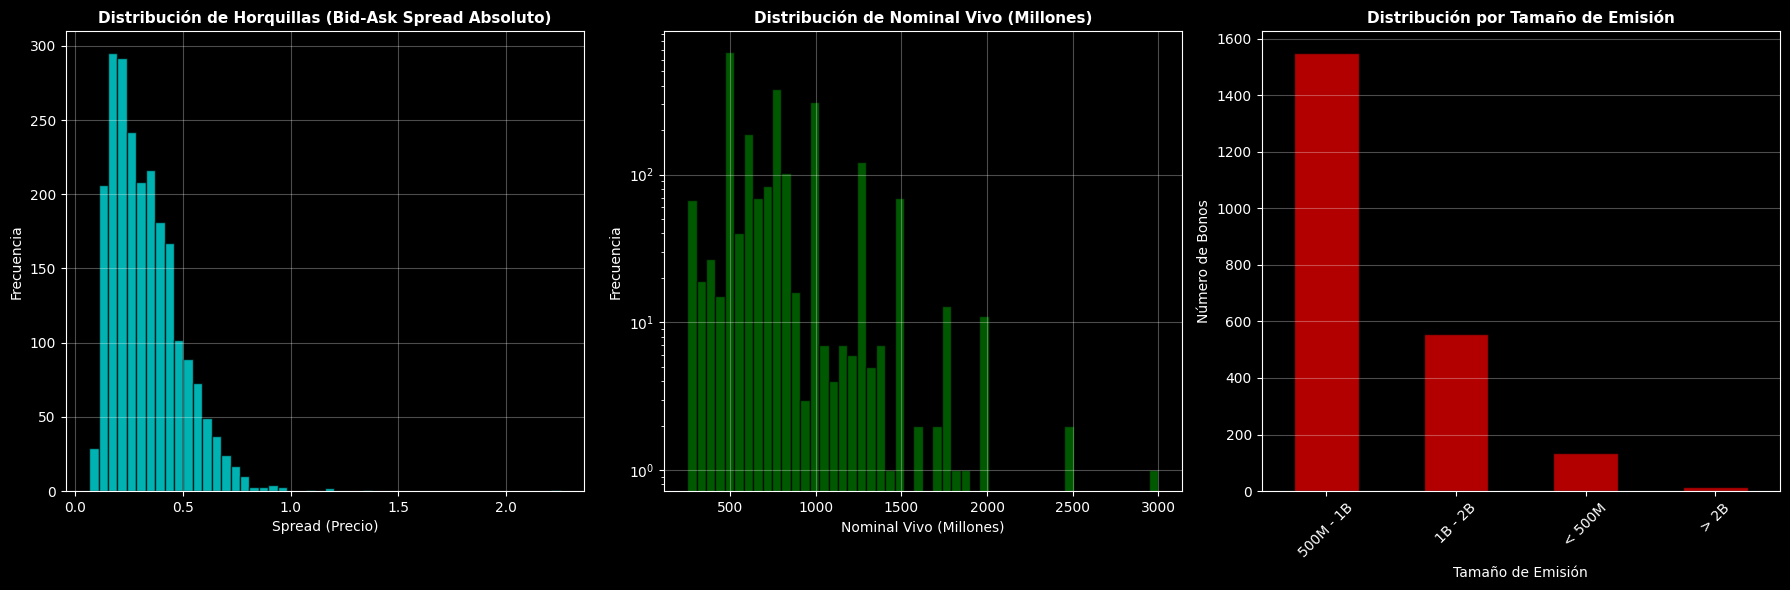


CONCLUSIONES SOBRE RIESGO DE LIQUIDEZ:
- Horquilla media: 0.347%
- Horquilla mediana: 0.302%
- Bonos con horquilla > 1%: 27 (1.20%)
- Bonos con emisión < 500M: 136 (6.03%)
- Bonos con emisión >= 500M: 2119 (93.97%)


In [ ]:
# ============================================================================
# ANÁLISIS DE RIESGO DE LIQUIDEZ - HORQUILLAS Y NOMINAL VIVO
# ============================================================================
# El riesgo de liquidez mide la facilidad para comprar/vender un bono
# Analizamos horquillas bid-ask y tamaño de emisión (nominal vivo)
# ============================================================================

# ============================================================================
# 1. CÁLCULO DE HORQUILLAS (BID-ASK SPREAD)
# ============================================================================
# La horquilla es la diferencia entre precio de compra (Ask) y venta (Bid)
# Horquillas más amplias indican menor liquidez
# ============================================================================

universo['Bid_Ask_Spread'] = universo['Ask Price'] - universo['Bid Price']
universo['Bid_Ask_Spread_Pct'] = (universo['Bid_Ask_Spread'] / universo['Price']) * 100

print("Análisis de Horquillas (Bid-Ask Spread):")
print(f"Valores nulos en Bid Price: {universo['Bid Price'].isna().sum()}")
print(f"Valores nulos en Ask Price: {universo['Ask Price'].isna().sum()}")
print(f"\nEstadísticas del spread absoluto:")
print(universo['Bid_Ask_Spread'].describe())
print(f"\nEstadísticas del spread porcentual:")
print(universo['Bid_Ask_Spread_Pct'].describe())

# ============================================================================
# EXPLICACIÓN DE LECTURA DE LAS ESTADÍSTICAS DE SPREAD
# ============================================================================
# 
# SPREAD ABSOLUTO (Bid_Ask_Spread):
# - Representa la diferencia en unidades monetarias (€) entre el precio 
#   de compra (Ask) y el precio de venta (Bid)
# - Ejemplo: Si Ask = 100.50€ y Bid = 100.30€, el spread absoluto = 0.20€
# - Interpretación:
#   * Spread bajo (< 0.30€): Alta liquidez, fácil comprar/vender
#   * Spread medio (0.30-0.50€): Liquidez moderada
#   * Spread alto (> 0.50€): Baja liquidez, mayor coste de transacción
#
# SPREAD PORCENTUAL (Bid_Ask_Spread_Pct):
# - Representa el spread absoluto como porcentaje del precio del bono
# - Fórmula: (Spread Absoluto / Precio del Bono) × 100
# - Ejemplo: Si spread absoluto = 0.20€ y precio = 100€, spread % = 0.20%
# - Interpretación:
#   * Spread < 0.25%: Excelente liquidez (bonos muy líquidos)
#   * Spread 0.25-0.50%: Buena liquidez (bonos estándar)
#   * Spread 0.50-1.00%: Liquidez moderada (riesgo de liquidez medio)
#   * Spread > 1.00%: Baja liquidez (riesgo elevado, difícil salir)
#
# ESTADÍSTICAS DESCRIPTIVAS:
# - count: Número de bonos con datos disponibles
# - mean: Promedio de todos los spreads (tendencia central)
# - std: Desviación estándar (variabilidad: mayor = más dispersión)
# - min/25%/50%/75%/max: Percentiles (25%=Q1, 50%=mediana, 75%=Q3)
#   * Mediana (50%): Valor central, resiste a valores extremos
#   * Q3 (75%): 75% de los bonos tienen spread menor o igual
#
# RELACIÓN SPREAD ABSOLUTO vs PORCENTUAL:
# - El spread absoluto es más útil para comparar bonos con precios similares
# - El spread porcentual permite comparar bonos con diferentes precios
# - Un bono con precio alto puede tener spread absoluto alto pero % bajo
#   (ej: precio 150€, spread 0.45€ = 0.30% → aún buena liquidez)
#
# ============================================================================

# ============================================================================
# 2. ANÁLISIS DE NOMINAL VIVO (OUTSTANDING AMOUNT)
# ============================================================================
# El nominal vivo es el tamaño total de la emisión en circulación
# Emisiones más grandes suelen tener mayor liquidez
# ============================================================================

print(f"\n\nAnálisis de Nominal Vivo (Outstanding Amount):")
print(f"Valores nulos: {universo['Outstanding Amount'].isna().sum()}")
print(f"Estadísticas descriptivas (en millones):")
outstanding_millions = universo['Outstanding Amount'] / 1_000_000
print(outstanding_millions.describe())

# ============================================================================
# CLASIFICACIÓN POR TAMAÑO DE EMISIÓN
# ============================================================================
# Clasificamos las emisiones en categorías según su tamaño
# Esto nos ayuda a identificar bonos con mayor o menor liquidez potencial
# ============================================================================

def clasificar_tamano(nominal):
    if pd.isna(nominal):
        return 'Sin dato'
    nominal_mill = nominal / 1_000_000
    if nominal_mill < 500:
        return '< 500M'
    elif nominal_mill < 1000:
        return '500M - 1B'
    elif nominal_mill < 2000:
        return '1B - 2B'
    else:
        return '> 2B'

universo['Tamaño_Emision'] = universo['Outstanding Amount'].apply(clasificar_tamano)
tamano_dist = universo['Tamaño_Emision'].value_counts()
print(f"\n\nDistribución por tamaño de emisión:")
print(tamano_dist)

# ============================================================================
# RELACIÓN ENTRE HORQUILLA Y TAMAÑO DE EMISIÓN
# ============================================================================
# Analizamos la correlación: emisiones más grandes suelen tener menor horquilla
# ============================================================================

print(f"\n\nCorrelación entre horquilla y tamaño de emisión:")
correlacion = universo[['Bid_Ask_Spread_Pct', 'Outstanding Amount']].corr()
print(correlacion)

# ============================================================================
# VISUALIZACIONES DE RIESGO DE LIQUIDEZ
# ============================================================================
# Creamos un panel de 6 gráficos para analizar la liquidez desde diferentes
# perspectivas
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Histograma de horquillas absolutas
spread_data = universo['Bid_Ask_Spread'].dropna()
axes[0].hist(spread_data, bins=50, color='cyan', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución de Horquillas (Bid-Ask Spread Absoluto)', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Spread (Precio)')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(True, alpha=0.3)


# Distribución de nominal vivo
outstanding_data = outstanding_millions.dropna()
axes[1].hist(outstanding_data, bins=50, color='green', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribución de Nominal Vivo (Millones)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Nominal Vivo (Millones)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

# 3. Distribución por tamaño de emisión (CORRECCIÓN AQUÍ)
# Cambiado axes[1, 2] por axes[2]
tamano_dist.plot(kind='bar', ax=axes[2], color='red', edgecolor='black', alpha=0.7)
axes[2].set_title('Distribución por Tamaño de Emisión', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Tamaño de Emisión')
axes[2].set_ylabel('Número de Bonos')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================================
# CONCLUSIONES SOBRE RIESGO DE LIQUIDEZ
# ============================================================================
# Resumen de los principales indicadores de liquidez
# ============================================================================

print(f"\n{'='*60}")
print("CONCLUSIONES SOBRE RIESGO DE LIQUIDEZ:")
print(f"{'='*60}")
print(f"- Horquilla media: {universo['Bid_Ask_Spread_Pct'].mean():.3f}%")
print(f"- Horquilla mediana: {universo['Bid_Ask_Spread_Pct'].median():.3f}%")
print(f"- Bonos con horquilla > 1%: {(universo['Bid_Ask_Spread_Pct'] > 1).sum()} ({(universo['Bid_Ask_Spread_Pct'] > 1).sum()/len(universo)*100:.2f}%)")
print(f"- Bonos con emisión < 500M: {(outstanding_millions < 500).sum()} ({(outstanding_millions < 500).sum()/len(universo)*100:.2f}%)")
print(f"- Bonos con emisión >= 500M: {(outstanding_millions >= 500).sum()} ({(outstanding_millions >= 500).sum()/len(universo)*100:.2f}%)")


#### <font color=#808080>Resto de información</font>

En esta sección, analizamos el resto de ficheros para ver qué información tenemos y, en caso de haber *gaps*, limpiar los datos antes de trabajar con ellos.

##### <font color=#CC6600>Precios bonos universo</font>

In [ ]:
# El archivo está en '../data/precios_historicos_universo.csv'
file_path = '../data/precios_historicos_universo.csv'

print("ANÁLISIS DE PRECIOS HISTÓRICOS UNIVERSO: ")

# 1. CARGA DE DATOS
# Cargamos el archivo. El índice 0 (la primera columna) contiene los ISINs.
# La primera celda del encabezado está vacía, por lo que es mejor renombrar la columna 0.
precios_universo = pd.read_csv(
    file_path, 
    sep=';', 
    decimal='.', 
    na_values=['#N/D', ' ', 'NA', 'nan', 'N/A', '']
)

# 2. PREPARACIÓN Y TRANSPOSICIÓN
# Renombramos la primera columna a 'ISIN' y la establecemos como el índice.
precios_df_preparado = precios_universo.rename(
    columns={precios_universo.columns[0]: 'Date'}
).set_index('Date')

# Ejecutamos la Transpuesta (.T)
precios_transpuesto = precios_df_preparado.T
reportar_gaps_informacion(precios_transpuesto, "Precios Históricos Universo")

# 3. LIMPIEZA DE FECHAS
# Convertir el nuevo índice (las fechas) a tipo datetime.
precios_transpuesto.index = pd.to_datetime(
    precios_transpuesto.index, 
    format='%d/%m/%Y', 
    errors='coerce' 
)
# 4. Eliminamos la primera fila al ser todos valores nulos y los nulos usamos forward fill
precios_transpuesto = precios_transpuesto.dropna(how='all').ffill(axis=1)


# 5. Mostrar el resultado
print("\n--- Vista Previa del DataFrame Traspuesto ---")
display(precios_transpuesto.head())


ANÁLISIS DE PRECIOS HISTÓRICOS UNIVERSO: 

 ANÁLISIS DE VALORES NULOS: Precios Históricos Universo
Total de filas: 732
Columnas con datos faltantes: 2255
------------------------------------------------------------
                  Tipo de Dato  Cantidad Nulos  Porcentaje (%)
Date                                                          
XS2732952838 Corp      float64             270           36.89
XS2694995163 Corp      float64             267           36.48
XS2724401588 Corp      float64             266           36.34
FR001400MLN4 Corp      float64             265           36.20
XS2731506841 Corp      float64             265           36.20
...                        ...             ...             ...
DE000A3MQQV5 Corp      float64             216           29.51
XS2101349723 Corp      float64             209           28.55
XS1562614831 Corp      float64             209           28.55
XS1511787589 Corp      float64             209           28.55
ES0211845310 Corp      float6

Date,XS0161488498 Corp,FR0000471930 Corp,XS0162513211 Corp,XS0162869076 Corp,FR0010014845 Corp,FR0010033381 Corp,XS0229567440 Corp,XS0300113254 Corp,XS0350890470 Corp,XS0553728709 Corp,...,XS2726335099 Corp,FR001400MDV4 Corp,XS2728560959 Corp,XS2728561098 Corp,XS2729836234 Corp,XS2724401588 Corp,XS2731506841 Corp,FR001400MLN4 Corp,XS2732952838 Corp,XS2694995163 Corp
2023-10-02,126.450,130.386,110.900,112.493,108.291,116.197,97.257,103.831,113.487,103.788,...,100.233,100.233,100.233,100.233,100.233,100.233,100.233,100.233,100.233,100.233
2023-10-03,126.000,129.697,110.567,112.127,107.608,115.831,96.548,103.716,112.907,103.490,...,100.087,100.087,100.087,100.087,100.087,100.087,100.087,100.087,100.087,100.087
2023-10-04,125.939,129.448,110.719,111.844,108.047,115.949,96.548,103.749,113.374,103.024,...,100.200,100.200,100.200,100.200,100.200,100.200,100.200,100.200,100.200,100.200
2023-10-05,126.330,129.795,111.117,112.191,108.480,116.305,97.201,103.907,113.929,103.273,...,100.339,100.339,100.339,100.339,100.339,100.339,100.339,100.339,100.339,100.339
2023-10-06,126.117,129.554,111.036,112.051,108.277,116.173,97.171,103.919,113.891,103.161,...,99.074,99.074,99.074,99.074,99.074,99.074,99.074,99.074,99.074,99.074


Para una mayor facilidad a la hora de trabajar con los datos los hemos traspuesto creando la primera columna 'Date' que  contiene las fechas y luego para cada ISIN los precios a cada una de las fechas, si hay un valor nulo, lo hemos rellenado con el de la fecha anterior.

##### <font color=#CC6600>Otros precios</font>

Para terminar con el análisis de datos, falta lo leído en los ficheros de *"precios_historicos_varios.csv"* y *curvaESTR.csv*.

ANÁLISIS DE OTROS PRECIOS: 

Forma del DataFrame: (514, 7)

 ANÁLISIS DE VALORES NULOS: Precios Varios
Total de filas: 514
Columnas con datos faltantes: 5
------------------------------------------------------------
                            Tipo de Dato  Cantidad Nulos  Porcentaje (%)
ITRX EUR CDSI GEN 5Y Corp        float64               8            1.56
ITRX XOVER CDSI GEN 5Y Corp      float64               8            1.56
DU1 Comdty                       float64               5            0.97
OE1 Comdty                       float64               5            0.97
RX1 Comdty                       float64               5            0.97

 ANÁLISIS DE VALORES NULOS: Precios Varios Limpios
 No se encontraron valores nulos en 'Precios Varios Limpios'.

Rango de fechas: 2023-10-02 00:00:00 a 2025-10-01 00:00:00
Número de fechas: 514

Instrumentos disponibles:
  - Unnamed: 0
  - ITRX EUR CDSI GEN 5Y Corp
  - ITRX XOVER CDSI GEN 5Y Corp
  - DU1 Comdty
  - OE1 Comdty
  - RX1 Comdty
 

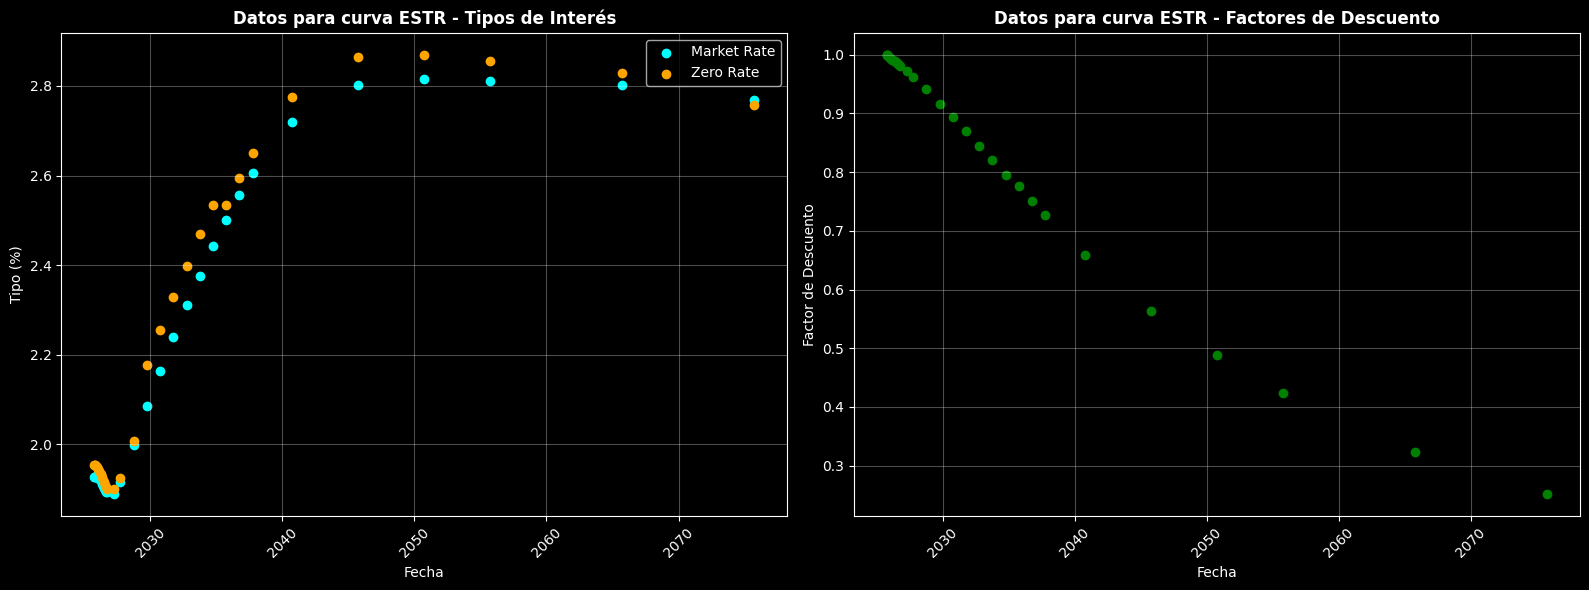

<Figure size 640x480 with 0 Axes>

In [ ]:
# Cargar otros precios (futuros, índices de crédito, benchmark)
print("ANÁLISIS DE OTROS PRECIOS: ")
precios_varios = pd.read_csv('../data/precios_historicos_varios.csv', sep=';', decimal='.',na_values=['#N/D', ' ', 'NA', 'nan', 'N/A'])
print(f"\nForma del DataFrame: {precios_varios.shape}")
reportar_gaps_informacion(precios_varios, "Precios Varios")


# Convertir la primera columna (fecha) a datetime
fecha_col = precios_varios.columns[0]
precios_varios[fecha_col] = pd.to_datetime(precios_varios[fecha_col], format='%d/%m/%Y', errors='coerce')

# Establecer el índice (fecha)
# Es importante hacer esto ANTES del ffill para asegurar la estructura temporal
precios_varios_indexed = precios_varios.set_index(fecha_col)

# Ordenar por fecha
# CRUCIAL: Si los datos no están ordenados cronológicamente, el ffill rellenará datos futuros con pasados o viceversa erróneamente.
precios_varios_indexed.sort_index(inplace=True)

# Limpieza (Forward Fill)
# Usamos ffill() para arrastrar el último precio conocido hacia adelante en los huecos
precios_varios_limpios = precios_varios_indexed.ffill()

# (Opcional) Si al principio de la serie hay nulos (no hay dato anterior para arrastrar),
# podrías querer eliminarlos o hacer un backfill
# precios_varios_limpios = precios_varios_limpios.dropna() 

# Reportar resultados
reportar_gaps_informacion(precios_varios_limpios, "Precios Varios Limpios")



print(f"\nRango de fechas: {precios_varios_limpios.index.min()} a {precios_varios_limpios.index.max()}")
print(f"Número de fechas: {len(precios_varios_limpios)}")

# Separar por tipo de instrumento
print(f"\nInstrumentos disponibles:")
for col in precios_varios.columns:
    print(f"  - {col}")

# Cargar curva ESTR
print("ANÁLISIS DE CURVA ESTR:")

curva_estr = pd.read_csv('../data/curvaESTR.csv', sep=';', decimal='.', na_values=['#N/D', ' ', 'NA', 'nan', 'N/A'])
print(f"\nForma del DataFrame: {curva_estr.shape}")
reportar_gaps_informacion(curva_estr, "Curva €STER")


# Convertir fecha a datetime
curva_estr['Date'] = pd.to_datetime(curva_estr['Date'], format='%d/%m/%Y', errors='coerce')
curva_estr = curva_estr.set_index('Date')

print(f"\nRango de fechas: {curva_estr.index.min()} a {curva_estr.index.max()}")
print(f"\nEstadísticas de la curva:")
print(curva_estr.describe())


# Visualización de la curva
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Curva de tipos (Scatter)
axes[0].scatter(curva_estr.index, curva_estr['Market Rate'], label='Market Rate', color='cyan')
axes[0].scatter(curva_estr.index, curva_estr['Zero Rate'], label='Zero Rate', color='orange')
axes[0].set_title('Datos para curva ESTR - Tipos de Interés', fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Tipo (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Factores de descuento (Scatter)
axes[1].scatter(curva_estr.index, curva_estr['Discount'], color='green')
axes[1].set_title('Datos para curva ESTR - Factores de Descuento', fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Factor de Descuento')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


### <font color=#336699>2. Valoración</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 En esta sección, valoraremos los bonos utilizando la curva. Para ello, crea una función (puedes hacerlo en un .py aparte) que con las **características del bono, la curva y un spread de crédito** devuelva la valoración del bono (incluyendo **precio limpio, cupón corrido y precio sucio**).

Si asumimos que el **spread de crédito es 0**, y la ejecutamos para el 01/10/2025...
- ¿Qué observas si comparas los precios obtenidos y los precios de mercado? 
- ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?
- ¿Qué otros factores influyen en ese spread?

Para la valoración, haz las siguientes simplificaciones:

- Asume que el vencimiento de los bonos perpetuos (para los que no hay vencimiento) es la próxima fecha call.
- Asume que todos aquellos bonos que tengan call serán calleados. Por lo tanto, usa la fecha call como fecha de vencimiento.
- Asume que los cupones son fijos hasta vencimiento (aunque alguno cambie a lo largo de la vida del bono).
- Usa la base de cálculo ACT/365. No tengas en cuenta la convención de día hábil.

Ten en cuenta que necesitarás una función de interpolación también. Interpola los factores de descuento exponencialmente.

</div>

In [ ]:
# Establecemos la fecha
fecha_valor = datetime.datetime(2025,10,1)

In [ ]:
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# CONFIGURACIÓN Y CONSTANTES - EJERCICIO 2
# ==============================================================================

FECHA_ANALISIS = pd.to_datetime('2025-10-01')
INVESTMENT_GRADE_RATINGS = [
    'AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-'
]

# ==============================================================================
# FUNCIONES DE INTERPOLACIÓN Y VALORACIÓN
# ==============================================================================

def interpolate_discount_factor(curva, fecha_valor, fecha_pago):
    """
    Interpola el factor de descuento usando interpolación log-lineal.
    """
    dias_valor = (fecha_pago - fecha_valor).days
    if dias_valor <= 0:
        return 1.0
    
    fechas_curva = curva.index
    factores_curva = curva['Discount'].values
    
    # Filtrar factores válidos
    valid_mask = factores_curva > 0
    if not np.any(valid_mask) or np.sum(valid_mask) < 2:
        return 1.0
    
    factores_validos = factores_curva[valid_mask]
    fechas_validas = fechas_curva[valid_mask]
    
    # Convertir a años
    años_curva = np.array([(f - fecha_valor).days / 365.0 for f in fechas_validas])
    años_pago = dias_valor / 365.0
    
    # Logaritmo de factores para interpolación exponencial
    log_factores = np.log(factores_validos)
    
    # Extrapolación para plazos cortos
    if años_pago <= años_curva[0]:
        if años_curva[0] == 0:
            return 1.0
        return factores_validos[0] ** (años_pago / años_curva[0])
    
    # Extrapolación para plazos largos
    elif años_pago >= años_curva[-1]:
        return factores_validos[-1] ** (años_pago / años_curva[-1])
    
    # Interpolación lineal en espacio logarítmico
    else:
        interp_func = interpolate.interp1d(
            años_curva, log_factores, 
            kind='linear', 
            fill_value='extrapolate'
        )
        log_df = interp_func(años_pago)
        return np.exp(log_df)


def generar_fechas_cupon(bono, fecha_valor):
    """Genera todas las fechas de cupón futuras para un bono."""
    freq_cupon = bono['Coupon Frequency']
    fecha_vencimiento = bono['Maturity']
    fecha_primer_cupon = bono['First Coupon Date']
    
    # Determinar incremento de fecha según frecuencia
    if freq_cupon == 1:
        offset = pd.DateOffset(years=1)
    elif freq_cupon == 2:
        offset = pd.DateOffset(months=6)
    elif freq_cupon == 4:
        offset = pd.DateOffset(months=3)
    else:
        offset = pd.DateOffset(months=int(12 / freq_cupon))
    
    # Encontrar próxima fecha de cupón después de fecha_valor
    fecha_actual = fecha_primer_cupon
    while fecha_actual <= fecha_valor:
        fecha_actual += offset
    
    # Generar todas las fechas hasta vencimiento
    fechas_cupon = []
    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        fecha_actual += offset
    
    # Asegurar que incluye el vencimiento
    if not fechas_cupon or fechas_cupon[-1] != fecha_vencimiento:
        if fecha_vencimiento > fecha_valor:
            fechas_cupon.append(fecha_vencimiento)
    
    return sorted(list(set(fechas_cupon)))


def calcular_cupon_corrido(bono, fecha_valor):
    """Calcula el cupón corrido (accrued interest) en la fecha de valoración."""
    freq_cupon = bono['Coupon Frequency']
    cupon_rate = bono['Coupon']
    cupon_monto_periodico = cupon_rate / freq_cupon
    
    # Determinar offset según frecuencia
    if freq_cupon == 1:
        offset = pd.DateOffset(years=1)
    elif freq_cupon == 2:
        offset = pd.DateOffset(months=6)
    elif freq_cupon == 4:
        offset = pd.DateOffset(months=3)
    else:
        offset = pd.DateOffset(months=int(12 / freq_cupon))
    
    # Encontrar fecha de cupón anterior
    fecha_temp = bono['First Coupon Date']
    fecha_cupon_anterior = None
    
    while fecha_temp < fecha_valor:
        fecha_cupon_anterior = fecha_temp
        fecha_temp += offset
    
    if fecha_cupon_anterior is None or fecha_cupon_anterior >= fecha_valor:
        return 0.0
    
    # Calcular días transcurridos
    dias_desde_cupon = (fecha_valor - fecha_cupon_anterior).days
    dias_periodo = (fecha_temp - fecha_cupon_anterior).days
    
    if dias_periodo <= 0:
        return 0.0
    
    return cupon_monto_periodico * (dias_desde_cupon / dias_periodo)


def valorar_bono(bono, curva, fecha_valor, spread_credito=0):
    """Valora un bono usando descuento de flujos de caja."""
    # Validar datos esenciales
    if pd.isna(bono['Coupon']) or pd.isna(bono['Coupon Frequency']):
        raise ValueError("Datos de cupón incompletos")
    
    if pd.isna(bono['Maturity']):
        raise ValueError("Fecha de vencimiento no disponible")
    
    fecha_vencimiento = bono['Maturity']
    if fecha_vencimiento <= fecha_valor:
        return {'precio_limpio': 100.0, 'cupon_corrido': 0.0, 'precio_sucio': 100.0}
    
    # Parámetros del bono
    cupon_rate = bono['Coupon']
    freq_cupon = bono['Coupon Frequency']
    cupon_monto_periodico = cupon_rate / freq_cupon
    
    # Generar fechas de pago
    fechas_cupon = generar_fechas_cupon(bono, fecha_valor)
    
    if not fechas_cupon:
        raise ValueError("No se pudieron generar fechas de cupón")
    
    # Valorar flujos de caja
    vp_total = 0.0
    spread_anual = spread_credito / 10000.0
    
    for i, fecha_pago in enumerate(fechas_cupon):
        dias = (fecha_pago - fecha_valor).days
        if dias <= 0:
            continue
        
        # Factor de descuento de la curva
        df = interpolate_discount_factor(curva, fecha_valor, fecha_pago)
        
        # Ajuste por spread de crédito
        t_años = dias / 365.0
        df_ajustado = df * np.exp(-spread_anual * t_años)
        
        # Flujo de caja
        if i == len(fechas_cupon) - 1:  # Último pago
            flujo = cupon_monto_periodico + 100.0  # Cupón + Principal
        else:
            flujo = cupon_monto_periodico
        
        vp_total += flujo * df_ajustado
    
    precio_limpio = vp_total
    cupon_corrido = calcular_cupon_corrido(bono, fecha_valor)
    precio_sucio = precio_limpio + cupon_corrido
    
    return {
        'precio_limpio': precio_limpio,
        'cupon_corrido': cupon_corrido,
        'precio_sucio': precio_sucio
    }


def clasificar_rating(rating):
    """Clasifica un rating como IG, HY o NR."""
    if pd.isna(rating) or rating == 'NR':
        return 'NR'
    rating_upper = str(rating).strip().upper()
    return 'IG' if rating_upper in INVESTMENT_GRADE_RATINGS else 'HY'


def preparar_datos(universo_df, curva_estr_df):
    """Prepara los datos ya cargados en memoria."""
    # Trabajar con una copia para no modificar el original
    universo = universo_df.copy()
    
    # Convertir fechas si no están ya en formato datetime
    campos_fecha = ['Maturity', 'Next Call Date', 'First Coupon Date', 
                    'Penultimate Coupon Date', 'Issue date']
    for campo in campos_fecha:
        if campo in universo.columns:
            if not pd.api.types.is_datetime64_any_dtype(universo[campo]):
                universo[campo] = pd.to_datetime(
                    universo[campo].replace('', pd.NA), 
                    format='%d/%m/%Y', 
                    errors='coerce'
                )
    
    # Preparar curva ESTR
    curva_estr = curva_estr_df.copy()
    
    # Detectar la estructura del DataFrame de la curva
    if 'Date' in curva_estr.columns and 'Discount' in curva_estr.columns:
        if not pd.api.types.is_datetime64_any_dtype(curva_estr['Date']):
            curva_estr['Date'] = pd.to_datetime(curva_estr['Date'], format='%d/%m/%Y', errors='coerce')
        curva_estr.set_index('Date', inplace=True)
    elif 'Discount' in curva_estr.columns:
        if not pd.api.types.is_datetime64_any_dtype(curva_estr.index):
            curva_estr.index = pd.to_datetime(curva_estr.index, format='%d/%m/%Y', errors='coerce')
    else:
        if not pd.api.types.is_datetime64_any_dtype(curva_estr.index):
            primera_col = curva_estr.columns[0]
            curva_estr[primera_col] = pd.to_datetime(curva_estr[primera_col], errors='coerce')
            curva_estr.set_index(primera_col, inplace=True)
        
        discount_cols = [col for col in curva_estr.columns if 'discount' in col.lower()]
        if discount_cols:
            curva_estr = curva_estr.rename(columns={discount_cols[0]: 'Discount'})
        else:
            numeric_cols = curva_estr.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                curva_estr = curva_estr.rename(columns={numeric_cols[0]: 'Discount'})
    
    if 'Discount' not in curva_estr.columns:
        raise ValueError("No se pudo identificar la columna 'Discount' en la curva ESTR")
    
    # Filtrar curva para fechas futuras y eliminar nulos
    curva_fecha = curva_estr.loc[curva_estr.index >= FECHA_ANALISIS].copy()
    curva_fecha = curva_fecha.dropna(subset=['Discount'])
    
    if len(curva_fecha) == 0:
        raise ValueError(f"No hay datos de curva ESTR para fechas >= {FECHA_ANALISIS}")
    
    return universo, curva_fecha


# ==============================================================================
# EJERCICIO 2: VALORACIÓN Y VISUALIZACIONES
# ==============================================================================

def ejecutar_ejercicio_2(universo_df, curva_estr_df):
    """
    Ejecuta el Ejercicio 2: Valoración de bonos con spread = 0.
    Genera análisis completo y visualizaciones.
    """
    print("=" * 80)
    print("EJERCICIO 2: VALORACIÓN DE BONOS CORPORATIVOS")
    print(f"Fecha de análisis: {FECHA_ANALISIS.strftime('%d/%m/%Y')}")
    print("=" * 80)
    
    # 1. Preparar datos
    print("\n[1/3] Preparando datos...")
    universo, curva_fecha = preparar_datos(universo_df, curva_estr_df)
    print(f"✓ Universo preparado: {len(universo)} bonos")
    print(f"✓ Curva ESTR: {len(curva_fecha)} puntos")
    
    # 2. Filtrar bonos válidos
    bonos_validos = universo[
        universo['Price'].notna() & 
        universo['Coupon'].notna() &
        universo['Coupon Frequency'].notna() & 
        universo['Maturity'].notna() &
        (universo['Maturity'] > FECHA_ANALISIS)
    ].copy()
    
    print(f"\n[2/3] Valorando bonos...")
    print(f"Bonos válidos para valoración: {len(bonos_validos)}")
    
    # 3. Valorar cada bono
    resultados = []
    for idx, bono in bonos_validos.iterrows():
        try:
            valoracion = valorar_bono(bono, curva_fecha, FECHA_ANALISIS, spread_credito=0)
            
            if valoracion['precio_limpio'] > 0:
                precio_mercado = bono['Price']
                precio_teorico = valoracion['precio_limpio']
                
                resultados.append({
                    'ISIN': bono['ISIN'],
                    'Rating': bono['Rating'],
                    'Coupon': bono['Coupon'],
                    'Maturity': bono['Maturity'],
                    'Precio_Mercado': precio_mercado,
                    'Precio_Teorico': precio_teorico,
                    'Diferencia': precio_mercado - precio_teorico,
                    'Diferencia_%': ((precio_mercado - precio_teorico) / precio_teorico) * 100,
                    'Error_Abs': abs(precio_mercado - precio_teorico)
                })
        except Exception as e:
            continue
    
    df_valoracion = pd.DataFrame(resultados)
    df_valoracion['Rating_Class'] = df_valoracion['Rating'].apply(clasificar_rating)
    
    # 4. Estadísticas
    print(f"\n[3/3] Generando análisis y visualizaciones...")
    print(f"\n✓ Bonos valorados exitosamente: {len(df_valoracion)}")
    print("\n" + "=" * 80)
    print("ESTADÍSTICAS DE VALORACIÓN")
    print("=" * 80)
    print("\nDiferencia (Precio Mercado - Precio Teórico):")
    print(df_valoracion['Diferencia'].describe().round(2))
    print(f"\nRMSE: {np.sqrt((df_valoracion['Diferencia']**2).mean()):.2f}")
    print(f"MAE: {df_valoracion['Error_Abs'].mean():.2f}")
    
    # Análisis por Rating
    print("\n" + "=" * 80)
    print("ANÁLISIS POR RATING CLASS")
    print("=" * 80)
    analisis_rating = df_valoracion.groupby('Rating_Class').agg({
        'Diferencia': ['count', 'mean', 'std', 'min', 'max'],
        'Error_Abs': 'mean',
        'Diferencia_%': ['mean', 'std']
    }).round(2)
    print(analisis_rating)
    
    # 5. VISUALIZACIONES
    crear_visualizaciones_ejercicio_2(df_valoracion)
    
    print("\n" + "=" * 80)
    print("EJERCICIO 2 COMPLETADO")
    print("=" * 80)
    
    # Devolver también los datos necesarios para el Ejercicio 3
    return {
        'df_valoracion': df_valoracion,
        'universo': universo,
        'curva_fecha': curva_fecha
    }


def crear_visualizaciones_ejercicio_2(df_valoracion):
    """Crea todas las visualizaciones para el Ejercicio 2."""
    
    # Configuración de estilo
    plt.style.use('seaborn-v0_8-darkgrid')
    colores = {
        'IG': '#2ecc71',  # Verde
        'HY': '#e74c3c',  # Rojo
        'NR': '#95a5a6'   # Gris
    }
    
    # =========================================================================
    # FIGURA 1: Análisis de Diferencias (4 gráficos)
    # =========================================================================
    fig1 = plt.figure(figsize=(18, 12))
    
    # 1.1 Histograma de diferencias
    ax1 = plt.subplot(1, 2, 1)
    sns.histplot(df_valoracion['Diferencia'], bins=50, kde=True, 
                 color='steelblue', edgecolor='black', ax=ax1)
    ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Diferencia = 0')
    ax1.axvline(df_valoracion['Diferencia'].mean(), color='orange', 
                linestyle='--', linewidth=2, 
                label=f'Media: {df_valoracion["Diferencia"].mean():.2f}')
    ax1.set_title('Distribución de Diferencias (Mercado - Teórico)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Diferencia (€)', fontsize=11)
    ax1.set_ylabel('Frecuencia', fontsize=11)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 1.2 Scatter: Precio Mercado vs Teórico
    ax2 = plt.subplot(1, 2, 2)
    for rating_class in ['IG', 'HY', 'NR']:
        data = df_valoracion[df_valoracion['Rating_Class'] == rating_class]
        ax2.scatter(data['Precio_Teorico'], data['Precio_Mercado'], 
                   alpha=0.6, s=50, color=colores[rating_class], 
                   label=f'{rating_class} (n={len(data)})')
    
    # Línea de identidad (precio mercado = precio teórico)
    min_val = min(df_valoracion['Precio_Teorico'].min(), 
                  df_valoracion['Precio_Mercado'].min())
    max_val = max(df_valoracion['Precio_Teorico'].max(), 
                  df_valoracion['Precio_Mercado'].max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', 
             linewidth=2, label='Precio Mercado = Teórico')
    
    ax2.set_title('Precio Mercado vs Precio Teórico', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Precio Teórico (€)', fontsize=11)
    ax2.set_ylabel('Precio Mercado (€)', fontsize=11)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    # =========================================================================
    # FIGURA 3: Top Bonos con Mayor Desviación
    # =========================================================================
    fig3 = plt.figure(figsize=(16, 8))
    
    # Top 20 sobrevalorados y subvalorados
    top_sobrevalorados = df_valoracion.nlargest(10, 'Diferencia')
    top_subvalorados = df_valoracion.nsmallest(10, 'Diferencia')
    
    # 3.1 Top Sobrevalorados
    ax8 = plt.subplot(1, 2, 1)
    y_pos = np.arange(len(top_sobrevalorados))
    colors_sv = [colores[rc] for rc in top_sobrevalorados['Rating_Class']]
    ax8.barh(y_pos, top_sobrevalorados['Diferencia'].values, color=colors_sv, 
             edgecolor='black', linewidth=1)
    ax8.set_yticks(y_pos)
    ax8.set_yticklabels([f"{isin[:8]}... ({rat})" for isin, rat in 
                         zip(top_sobrevalorados['ISIN'], top_sobrevalorados['Rating'])],
                        fontsize=9)
    ax8.set_xlabel('Diferencia (€)', fontsize=11)
    ax8.set_title('Top 10 Bonos Sobrevalorados por el Mercado', 
                  fontsize=13, fontweight='bold')
    ax8.grid(True, alpha=0.3, axis='x')
    ax8.invert_yaxis()
    
    # 3.2 Top Subvalorados
    ax9 = plt.subplot(1, 2, 2)
    y_pos = np.arange(len(top_subvalorados))
    colors_sub = [colores[rc] for rc in top_subvalorados['Rating_Class']]
    ax9.barh(y_pos, top_subvalorados['Diferencia'].values, color=colors_sub, 
             edgecolor='black', linewidth=1)
    ax9.set_yticks(y_pos)
    ax9.set_yticklabels([f"{isin[:8]}... ({rat})" for isin, rat in 
                         zip(top_subvalorados['ISIN'], top_subvalorados['Rating'])],
                        fontsize=9)
    ax9.set_xlabel('Diferencia (€)', fontsize=11)
    ax9.set_title('Top 10 Bonos Subvalorados por el Mercado', 
                  fontsize=13, fontweight='bold')
    ax9.grid(True, alpha=0.3, axis='x')
    ax9.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('ejercicio2_top_desviaciones.png', dpi=300, bbox_inches='tight')
    print("✓ Gráfico guardado: 'ejercicio2_top_desviaciones.png'")
    plt.show()


resultados_ej2 = ejecutar_ejercicio_2(universo, curva_estr)


1. Si los precios de mercado son sistemáticamente diferentes a los teóricos con spread=0,
   esto indica que los bonos tienen un spread de crédito positivo.

2. Otros factores que influyen en el spread además del riesgo crediticio:
   - Liquidez: bonos menos líquidos tienen spreads más altos
   - Opcionalidad: bonos callable tienen spreads diferentes
   - Tamaño de la emisión: emisiones pequeñas suelen tener spreads más altos
   - Sector/industria: algunos sectores tienen spreads estructuralmente más altos
   - Convenciones de mercado y factores técnicos

### <font color=#336699>3. Spread</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora los spreads que debemos añadir a la curva con un movimiento paralelo para que cuadren los precios de mercado que tenemos. Para ello, usa la función de valoración del apartado anterior. 
- ¿Qué observas? ¿Tienen sentido los resultados? 
- ¿Con qué datos de los que tenemos compararías para ver si los resultados son coherentes?

</div>

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, brentq
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# NOTA: Este script requiere que primero ejecutes el Ejercicio 2
# ==============================================================================
# 
# Debes tener disponible:
# 1. El DataFrame df_valoracion del Ejercicio 2
# 2. Los DataFrames universo y curva_estr originales
# 3. Las funciones de valoración del Ejercicio 2
#
# Si no has ejecutado el Ejercicio 2, primero ejecuta:
# df_valoracion = ejecutar_ejercicio_2(universo, curva_estr)
# ==============================================================================

FECHA_ANALISIS = pd.to_datetime('2025-10-01')
INVESTMENT_GRADE_RATINGS = [
    'AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-'
]

# ==============================================================================
# FUNCIONES PARA EL EJERCICIO 3
# ==============================================================================

def calcular_spread_credito(bono, curva, fecha_valor, precio_mercado, valorar_bono_func):
    """
    Calcula el spread de crédito implícito usando método de Brent.
    
    Args:
        bono: Series con información del bono
        curva: DataFrame con curva de descuento
        fecha_valor: Fecha de valoración
        precio_mercado: Precio de mercado observado
        valorar_bono_func: Función de valoración del bono
        
    Returns:
        Spread de crédito en puntos básicos
    """
    def precio_diferencia(spread):
        try:
            valoracion = valorar_bono_func(bono, curva, fecha_valor, spread_credito=spread)
            return valoracion['precio_limpio'] - precio_mercado
        except:
            return 1e10
    
    try:
        # Usar método de Brent (más robusto que fsolve)
        spread_optimo = brentq(
            precio_diferencia, 
            a=0.0, 
            b=2000.0,  # Máximo 2000 bp
            xtol=0.01,
            maxiter=100
        )
        return max(0.0, spread_optimo)
    except:
        # Si Brent falla, intentar con fsolve
        try:
            spread_optimo = fsolve(precio_diferencia, x0=100.0, xtol=1e-6)[0]
            return max(0.0, spread_optimo)
        except:
            return np.nan


def clasificar_rating(rating):
    """Clasifica un rating como IG, HY o NR."""
    if pd.isna(rating) or rating == 'NR':
        return 'NR'
    rating_upper = str(rating).strip().upper()
    return 'IG' if rating_upper in INVESTMENT_GRADE_RATINGS else 'HY'


# ==============================================================================
# EJERCICIO 3: CÁLCULO DE SPREADS
# ==============================================================================

def ejecutar_ejercicio_3(df_valoracion, universo_df, curva_fecha, valorar_bono_func):
    """
    Ejecuta el Ejercicio 3: Cálculo de spreads de crédito.
    
    Args:
        df_valoracion: DataFrame del Ejercicio 2 con las valoraciones
        universo_df: DataFrame completo del universo de bonos
        curva_fecha: Curva ESTR filtrada
        valorar_bono_func: Función valorar_bono del Ejercicio 2
        
    Returns:
        DataFrame con los spreads calculados
    """
    print("\n" + "=" * 80)
    print("EJERCICIO 3: CÁLCULO DE SPREADS DE CRÉDITO")
    print("=" * 80)
    
    spreads = []
    total = len(df_valoracion)
    
    print(f"\nCalculando spreads para {total} bonos...")
    
    for idx, row in df_valoracion.iterrows():
        bono = universo_df[universo_df['ISIN'] == row['ISIN']].iloc[0]
        
        try:
            spread = calcular_spread_credito(
                bono, 
                curva_fecha, 
                FECHA_ANALISIS, 
                row['Precio_Mercado'],
                valorar_bono_func
            )
            spreads.append(spread)
        except:
            spreads.append(np.nan)
        
        # Progreso cada 500 bonos
        if (idx + 1) % 500 == 0:
            print(f"Progreso: {idx + 1}/{total} bonos procesados ({(idx+1)/total*100:.1f}%)")
    
    # Crear DataFrame con spreads
    df_spreads = df_valoracion.copy()
    df_spreads['Spread_Credit_bp'] = spreads
    df_spreads = df_spreads.dropna(subset=['Spread_Credit_bp'])
    df_spreads['Rating_Class'] = df_spreads['Rating'].apply(clasificar_rating)
    
    print(f"\n✓ Spreads calculados exitosamente: {len(df_spreads)}/{total} bonos")
    
    # Estadísticas
    print("\n" + "=" * 80)
    print("ESTADÍSTICAS DE SPREADS DE CRÉDITO (bp)")
    print("=" * 80)
    print(df_spreads['Spread_Credit_bp'].describe().round(2))
    
    # Análisis por Rating
    print("\n" + "=" * 80)
    print("ANÁLISIS POR CLASIFICACIÓN DE RATING")
    print("=" * 80)
    analisis_rating = df_spreads.groupby('Rating_Class')['Spread_Credit_bp'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    print(analisis_rating)
    
    # Crear visualizaciones
    crear_visualizaciones_ejercicio_3(df_spreads)
    
    print("\n" + "=" * 80)
    print("EJERCICIO 3 COMPLETADO")
    print("=" * 80)
    
    return df_spreads


def crear_visualizaciones_ejercicio_3(df_spreads):
    """Crea todas las visualizaciones para el Ejercicio 3."""
    
    plt.style.use('seaborn-v0_8-darkgrid')
    colores = {
        'IG': '#2ecc71',  # Verde
        'HY': '#e74c3c',  # Rojo
        'NR': '#95a5a6'   # Gris
    }
    
    # =========================================================================
    # FIGURA 1: Análisis de Spreads (4 gráficos)
    # =========================================================================
    fig1 = plt.figure(figsize=(18, 12))
    
    # 1.1 Histograma de spreads
    ax1 = plt.subplot(1, 2, 1)
    sns.histplot(df_spreads['Spread_Credit_bp'], bins=50, kde=True, 
                 color='steelblue', edgecolor='black', ax=ax1)
    mediana = df_spreads['Spread_Credit_bp'].median()
    media = df_spreads['Spread_Credit_bp'].mean()
    ax1.axvline(mediana, color='red', linestyle='--', linewidth=2, 
                label=f'Mediana: {mediana:.2f} bp')
    ax1.axvline(media, color='orange', linestyle='--', linewidth=2, 
                label=f'Media: {media:.2f} bp')
    ax1.set_title('Distribución de Spreads de Crédito', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Spread de Crédito (bp)', fontsize=11)
    ax1.set_ylabel('Frecuencia', fontsize=11)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    

    order = ['IG', 'HY', 'NR']

    # 1.4 Scatter: Cupón vs Spread
    ax4 = plt.subplot(1, 2, 2)
    for rating_class in order:
        data = df_spreads[df_spreads['Rating_Class'] == rating_class]
        ax4.scatter(data['Coupon'], data['Spread_Credit_bp'], 
                   alpha=0.6, s=50, color=colores[rating_class], 
                   label=f'{rating_class} (n={len(data)})')
    ax4.set_title('Cupón vs Spread de Crédito', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Cupón (%)', fontsize=11)
    ax4.set_ylabel('Spread de Crédito (bp)', fontsize=11)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ejercicio3_analisis_spreads.png', dpi=300, bbox_inches='tight')
    print("\n✓ Gráfico guardado: 'ejercicio3_analisis_spreads.png'")
    plt.show()
    
    # =========================================================================
    # FIGURA 2: Análisis Comparativo (3 gráficos)
    # =========================================================================
    fig2 = plt.figure(figsize=(18, 6))
    
    # 2.1 Spread Medio por Rating Class
    ax5 = plt.subplot(1, 3, 1)
    spread_medio = df_spreads.groupby('Rating_Class')['Spread_Credit_bp'].mean().reindex(order)
    bars = ax5.bar(range(len(spread_medio)), spread_medio.values,
                   color=[colores[rc] for rc in order], edgecolor='black', linewidth=1.5)
    ax5.set_xticks(range(len(spread_medio)))
    ax5.set_xticklabels(order)
    ax5.set_title('Spread Medio por Rating', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Clase de Rating', fontsize=11)
    ax5.set_ylabel('Spread Medio (bp)', fontsize=11)
    ax5.grid(True, alpha=0.3, axis='y')
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 2.2 Conteo por Rating Class
    ax6 = plt.subplot(1, 3, 2)
    counts = df_spreads['Rating_Class'].value_counts().reindex(order)
    colors_pie = [colores[rc] for rc in order]
    wedges, texts, autotexts = ax6.pie(counts.values, labels=counts.index, 
                                         autopct='%1.1f%%', colors=colors_pie,
                                         startangle=90, textprops={'fontsize': 11})
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax6.set_title('Distribución de Bonos por Rating', fontsize=14, fontweight='bold')
    
    # 2.3 Spread vs Diferencia de Precio
    ax7 = plt.subplot(1, 3, 3)
    for rating_class in order:
        data = df_spreads[df_spreads['Rating_Class'] == rating_class]
        ax7.scatter(data['Spread_Credit_bp'], data['Diferencia'], 
                   alpha=0.6, s=50, color=colores[rating_class], 
                   label=rating_class)
    ax7.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax7.set_title('Spread vs Diferencia de Precio', fontsize=14, fontweight='bold')
    ax7.set_xlabel('Spread de Crédito (bp)', fontsize=11)
    ax7.set_ylabel('Diferencia (Mercado - Teórico) (€)', fontsize=11)
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ejercicio3_analisis_comparativo.png', dpi=300, bbox_inches='tight')
    print("✓ Gráfico guardado: 'ejercicio3_analisis_comparativo.png'")
    plt.show()
    
    # =========================================================================
    # FIGURA 3: Top Spreads y Análisis por Rating Individual
    # =========================================================================
    fig3 = plt.figure(figsize=(18, 10))
    
    # 3.1 Top 15 spreads más altos
    ax8 = plt.subplot(1, 2, 1)
    top_spreads = df_spreads.nlargest(15, 'Spread_Credit_bp')
    y_pos = np.arange(len(top_spreads))
    colors_top = [colores[rc] for rc in top_spreads['Rating_Class']]
    ax8.barh(y_pos, top_spreads['Spread_Credit_bp'].values, color=colors_top,
             edgecolor='black', linewidth=1)
    ax8.set_yticks(y_pos)
    ax8.set_yticklabels([f"{isin[:8]}... ({rat})" for isin, rat in 
                         zip(top_spreads['ISIN'], top_spreads['Rating'])],
                        fontsize=8)
    ax8.set_xlabel('Spread (bp)', fontsize=11)
    ax8.set_title('Top 15 Spreads Más Altos', fontsize=13, fontweight='bold')
    ax8.grid(True, alpha=0.3, axis='x')
    ax8.invert_yaxis()

    
    # 3.3 Spread por Rating Individual (IG)
    ax10 = plt.subplot(1, 2, 2)
    ig_data = df_spreads[df_spreads['Rating_Class'] == 'IG']
    if len(ig_data) > 0:
        rating_order = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
        ig_by_rating = ig_data.groupby('Rating')['Spread_Credit_bp'].mean()
        ig_by_rating = ig_by_rating.reindex([r for r in rating_order if r in ig_by_rating.index])
        ax10.plot(range(len(ig_by_rating)), ig_by_rating.values, 
                 marker='o', linewidth=2, markersize=8, color='#2ecc71')
        ax10.set_xticks(range(len(ig_by_rating)))
        ax10.set_xticklabels(ig_by_rating.index, rotation=45)
        ax10.set_title('Spread Medio por Rating (Investment Grade)', 
                      fontsize=13, fontweight='bold')
        ax10.set_xlabel('Rating', fontsize=11)
        ax10.set_ylabel('Spread Medio (bp)', fontsize=11)
        ax10.grid(True, alpha=0.3)
    


df_spreads = ejecutar_ejercicio_3(
    resultados_ej2['df_valoracion'], 
    resultados_ej2['universo'], 
    resultados_ej2['curva_fecha'],
    valorar_bono
)



### <font color=#336699>4. YTM, Duración, Convexidad</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora la siguiente información, también relacionada con la rentabilidad y riesgo de las emisiones:
- *Yield* - Por simplicidad, en este caso, en el caso de los bonos callable, nos quedaremos con la fecha call, como en el ejercicio anterior. Usa las mismas asunciones que para la valoración y el spread.
- Duración
- Convexidad

Responde a las siguientes preguntas:
- ¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?
- ¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?
- Estima el precio del bono usando la duración y convexidad, ¿qué observas?

</div>

CÁLCULO DE YTM, DURACIÓN Y CONVEXIDAD

Bonos procesados exitosamente: 2255

Estadísticas de YTM (%):
count    2255.000000
mean        3.098567
std         0.891407
min         0.622034
25%         2.670204
50%         2.997437
75%         3.440478
max        24.702296
Name: YTM_%, dtype: float64

Estadísticas de Duración Modificada (años):
count    2255.000000
mean        3.815392
std         2.639476
min         0.150251
25%         1.946204
50%         3.201595
75%         5.039662
max        23.280330
Name: Duracion, dtype: float64

Estadísticas de Convexidad:
count    2255.000000
mean       26.805517
std        45.746280
min         0.093610
25%         5.745748
50%        13.605995
75%        31.252624
max       715.618903
Name: Convexidad, dtype: float64


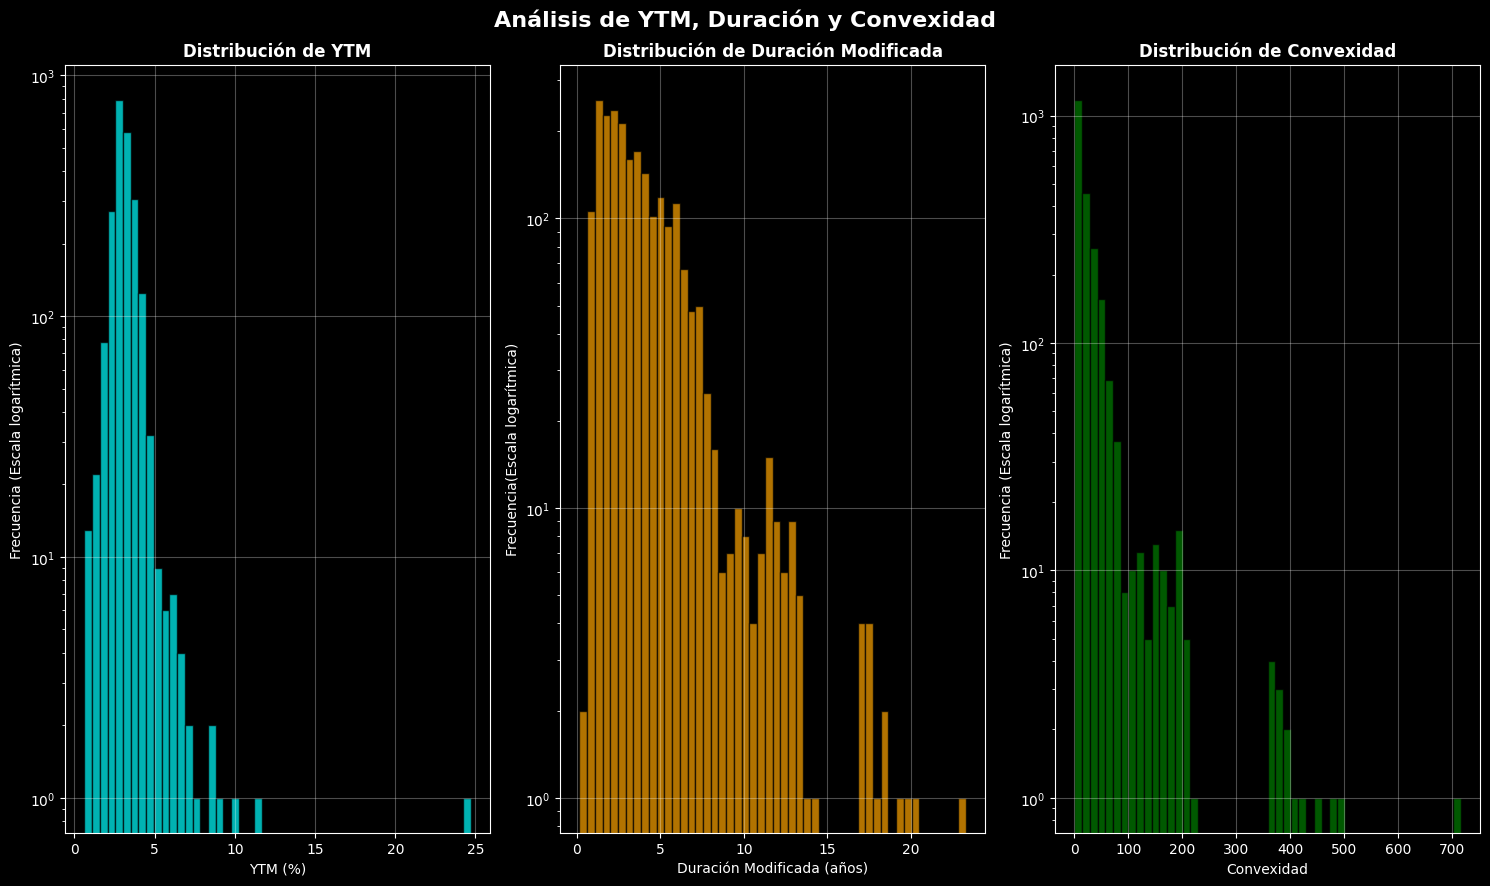


ESTIMACIÓN DE PRECIO USANDO DURACIÓN Y CONVEXIDAD

Estimación de cambio de precio para diferentes variaciones de yield:
 Cambio_Yield_%  Delta_P_Duracion_Media_%  Delta_P_Dur_Conv_Media_%
           -2.0                  7.630784                  8.166894
           -1.0                  3.815392                  3.949420
           -0.5                  1.907696                  1.941203
            0.5                 -1.907696                 -1.874189
            1.0                 -3.815392                 -3.681364
            2.0                 -7.630784                 -7.094674


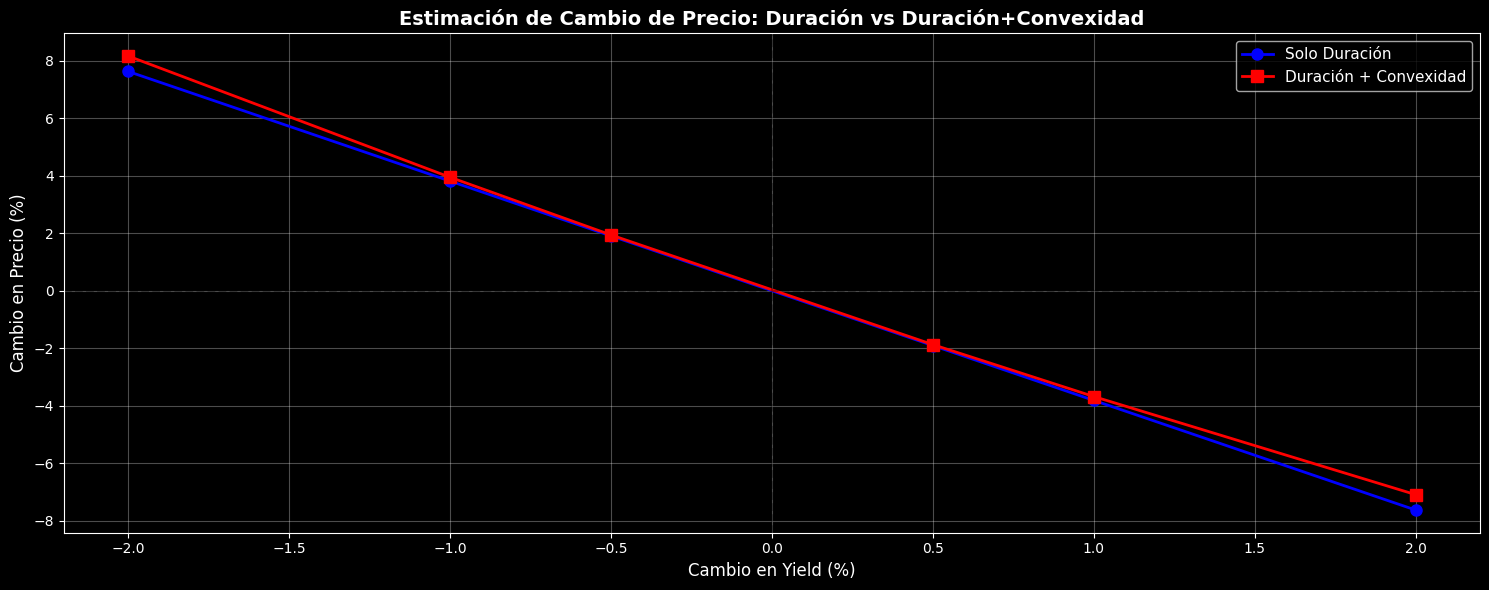


RESPUESTAS A LAS PREGUNTAS DEL EJERCICIO

1. RELACIÓN ENTRE YTM Y SPREAD DE CRÉDITO:
--------------------------------------------------------------------------------
   • YTM promedio: 3.10%
   • Spread promedio: -142.54 bp
   • Tasa libre de riesgo implícita: 4.52%

   Relación: YTM ≈ Tasa Libre de Riesgo + Spread de Crédito
   El spread representa la prima de riesgo que exigen los inversores
   por el riesgo de crédito del emisor.

2. RELACIÓN ENTRE DURACIÓN Y VENCIMIENTO:
--------------------------------------------------------------------------------
   • Duración de Macaulay promedio: 3.94 años
   • Tiempo al vencimiento promedio: 4.25 años
   • Ratio Duración/Vencimiento: 95.66%

   ¿Qué refleja la duración?
   • La duración mide el tiempo promedio ponderado hasta recibir los flujos
   • Representa la sensibilidad del precio ante cambios en tasas
   • Para bonos con cupón: Duración < Vencimiento (por flujos intermedios)
   • Mayor cupón → menor duración (más peso en flujos tempr

In [ ]:
# ============================================================================
# EJERCICIO 4: YIELD, DURACIÓN Y CONVEXIDAD - VERSIÓN CORREGIDA
# ============================================================================
# Calculamos YTM, duración modificada y convexidad para cada bono
# ============================================================================


def calcular_ytm(bono, precio_mercado, fecha_valor, ytm_inicial=0.03, tol=1e-8):
    """
    Calcula el Yield to Maturity (YTM) del bono usando capitalización discreta.

    Parámetros:
    -----------
    bono : Serie de pandas con características del bono
    precio_mercado : float, precio de mercado del bono
    fecha_valor : datetime, fecha de valoración
    ytm_inicial : float, YTM inicial para búsqueda
    tol : float, tolerancia para convergencia

    Retorna:
    --------
    float: YTM en decimal (ej: 0.03 para 3%)
    """
    # Determinar fecha de vencimiento (priorizar call si existe)
    if pd.notna(bono.get('Next Call Date')):
        fecha_vencimiento = pd.to_datetime(bono['Next Call Date'])
    elif pd.notna(bono.get('Maturity')):
        fecha_vencimiento = pd.to_datetime(bono['Maturity'])
    else:
        return np.nan

    # Generar fechas de cupón
    cupon = bono['Coupon'] / 100.0
    freq_cupon = bono['Coupon Frequency']
    fecha_primer_cupon = pd.to_datetime(bono['First Coupon Date'])

    fechas_cupon = []
    fecha_actual = fecha_primer_cupon

    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        if freq_cupon == 1:
            fecha_actual = fecha_actual + pd.DateOffset(years=1)
        elif freq_cupon == 2:
            fecha_actual = fecha_actual + pd.DateOffset(months=6)
        elif freq_cupon == 4:
            fecha_actual = fecha_actual + pd.DateOffset(months=3)
        else:
            fecha_actual = fecha_actual + pd.DateOffset(months=12/freq_cupon)

    # Asegurar que la última fecha sea el vencimiento
    if len(fechas_cupon) > 0 and fechas_cupon[-1] != fecha_vencimiento:
        fechas_cupon[-1] = fecha_vencimiento

    # Filtrar solo cupones futuros
    fechas_cupon = [f for f in fechas_cupon if f > fecha_valor]

    if len(fechas_cupon) == 0:
        return np.nan

    cupon_periodo = cupon / freq_cupon

    def objetivo(ytm):
        """Función objetivo: diferencia entre precio teórico y mercado."""
        ytm_periodo = ytm / freq_cupon  # YTM por período
        vp = 0.0

        # Valor presente de cupones intermedios
        for i, fecha_cupon in enumerate(fechas_cupon[:-1], start=1):
            dias = (fecha_cupon - fecha_valor).days
            if dias > 0:
                # Calcular número de períodos (fraccional)
                periodos = dias / (365.0 / freq_cupon)
                vp += cupon_periodo * 100.0 / ((1 + ytm_periodo) ** periodos)

        # Último flujo: cupón + principal
        dias_ultimo = (fechas_cupon[-1] - fecha_valor).days
        if dias_ultimo > 0:
            periodos_ultimo = dias_ultimo / (365.0 / freq_cupon)
            vp += (cupon_periodo * 100.0 + 100.0) / ((1 + ytm_periodo) ** periodos_ultimo)

        return vp - precio_mercado

    try:
        # Intentar con brentq primero (más robusto con límites)
        if objetivo(0.0001) * objetivo(0.5) < 0:
            ytm = brentq(objetivo, 0.0001, 0.5, xtol=tol)
        else:
            ytm = fsolve(objetivo, ytm_inicial, xtol=tol)[0]
        return max(0.0, ytm)
    except:
        return np.nan


def calcular_duracion_macaulay(bono, fecha_valor, ytm):
    """
    Calcula la duración de Macaulay del bono.

    D_Mac = Σ(t * CF_t / (1+y)^t) / P

    Parámetros:
    -----------
    bono : Serie de pandas con características del bono
    fecha_valor : datetime, fecha de valoración
    ytm : float, yield to maturity

    Retorna:
    --------
    float: Duración de Macaulay en años
    """
    if np.isnan(ytm):
        return np.nan

    # Determinar fecha de vencimiento
    if pd.notna(bono.get('Next Call Date')):
        fecha_vencimiento = pd.to_datetime(bono['Next Call Date'])
    elif pd.notna(bono.get('Maturity')):
        fecha_vencimiento = pd.to_datetime(bono['Maturity'])
    else:
        return np.nan

    # Generar fechas de cupón
    cupon = bono['Coupon'] / 100.0
    freq_cupon = bono['Coupon Frequency']
    fecha_primer_cupon = pd.to_datetime(bono['First Coupon Date'])
    cupon_periodo = cupon / freq_cupon
    ytm_periodo = ytm / freq_cupon

    fechas_cupon = []
    fecha_actual = fecha_primer_cupon

    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        if freq_cupon == 1:
            fecha_actual = fecha_actual + pd.DateOffset(years=1)
        elif freq_cupon == 2:
            fecha_actual = fecha_actual + pd.DateOffset(months=6)
        elif freq_cupon == 4:
            fecha_actual = fecha_actual + pd.DateOffset(months=3)
        else:
            fecha_actual = fecha_actual + pd.DateOffset(months=12/freq_cupon)

    if len(fechas_cupon) > 0 and fechas_cupon[-1] != fecha_vencimiento:
        fechas_cupon[-1] = fecha_vencimiento

    fechas_cupon = [f for f in fechas_cupon if f > fecha_valor]

    if len(fechas_cupon) == 0:
        return np.nan

    # Calcular duración de Macaulay
    suma_vp_ponderado = 0.0
    suma_vp = 0.0

    for i, fecha_cupon in enumerate(fechas_cupon):
        dias = (fecha_cupon - fecha_valor).days
        if dias > 0:
            tiempo_anios = dias / 365.0
            periodos = dias / (365.0 / freq_cupon)

            # Flujo de caja (último incluye principal)
            if i == len(fechas_cupon) - 1:
                flujo = (cupon_periodo * 100.0 + 100.0)
            else:
                flujo = cupon_periodo * 100.0

            # VP del flujo
            vp_flujo = flujo / ((1 + ytm_periodo) ** periodos)

            # Acumular
            suma_vp_ponderado += tiempo_anios * vp_flujo
            suma_vp += vp_flujo

    if suma_vp > 0:
        duracion_macaulay = suma_vp_ponderado / suma_vp
        return duracion_macaulay
    else:
        return np.nan


def calcular_duracion_modificada(duracion_macaulay, ytm, freq_cupon):
    """
    Calcula la duración modificada del bono.

    D_mod = D_Mac / (1 + y/m)

    donde y es el YTM anual y m es la frecuencia de cupones.

    Parámetros:
    -----------
    duracion_macaulay : float, duración de Macaulay
    ytm : float, yield to maturity anual
    freq_cupon : int, frecuencia de cupones

    Retorna:
    --------
    float: Duración modificada
    """
    if np.isnan(duracion_macaulay) or np.isnan(ytm):
        return np.nan

    ytm_periodo = ytm / freq_cupon
    duracion_modificada = duracion_macaulay / (1 + ytm_periodo)

    return duracion_modificada


def calcular_convexidad(bono, fecha_valor, ytm):
    """
    Calcula la convexidad del bono.

    C = Σ(CF_t * t * (t+1) / (1+y)^(t+2)) / P

    Para períodos fraccionarios: t = días / (365/freq)

    Parámetros:
    -----------
    bono : Serie de pandas con características del bono
    fecha_valor : datetime, fecha de valoración
    ytm : float, yield to maturity

    Retorna:
    --------
    float: Convexidad
    """
    if np.isnan(ytm):
        return np.nan

    # Determinar fecha de vencimiento
    if pd.notna(bono.get('Next Call Date')):
        fecha_vencimiento = pd.to_datetime(bono['Next Call Date'])
    elif pd.notna(bono.get('Maturity')):
        fecha_vencimiento = pd.to_datetime(bono['Maturity'])
    else:
        return np.nan

    # Generar fechas de cupón
    cupon = bono['Coupon'] / 100.0
    freq_cupon = bono['Coupon Frequency']
    fecha_primer_cupon = pd.to_datetime(bono['First Coupon Date'])
    cupon_periodo = cupon / freq_cupon
    ytm_periodo = ytm / freq_cupon

    fechas_cupon = []
    fecha_actual = fecha_primer_cupon

    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        if freq_cupon == 1:
            fecha_actual = fecha_actual + pd.DateOffset(years=1)
        elif freq_cupon == 2:
            fecha_actual = fecha_actual + pd.DateOffset(months=6)
        elif freq_cupon == 4:
            fecha_actual = fecha_actual + pd.DateOffset(months=3)
        else:
            fecha_actual = fecha_actual + pd.DateOffset(months=12/freq_cupon)

    if len(fechas_cupon) > 0 and fechas_cupon[-1] != fecha_vencimiento:
        fechas_cupon[-1] = fecha_vencimiento

    fechas_cupon = [f for f in fechas_cupon if f > fecha_valor]

    if len(fechas_cupon) == 0:
        return np.nan

    # Calcular convexidad
    suma_convexidad = 0.0
    suma_vp = 0.0

    for i, fecha_cupon in enumerate(fechas_cupon):
        dias = (fecha_cupon - fecha_valor).days
        if dias > 0:
            periodos = dias / (365.0 / freq_cupon)

            # Flujo de caja
            if i == len(fechas_cupon) - 1:
                flujo = (cupon_periodo * 100.0 + 100.0)
            else:
                flujo = cupon_periodo * 100.0

            # VP del flujo
            vp_flujo = flujo / ((1 + ytm_periodo) ** periodos)

            # Término de convexidad: CF * t * (t+1) / (1+y)^(t+2)
            termino_convexidad = flujo * periodos * (periodos + 1) / ((1 + ytm_periodo) ** (periodos + 2))

            suma_convexidad += termino_convexidad
            suma_vp += vp_flujo

    if suma_vp > 0:
        convexidad = suma_convexidad / suma_vp
        # Ajustar por frecuencia de cupones (convexidad anualizada)
        convexidad = convexidad / (freq_cupon ** 2)
        return convexidad
    else:
        return np.nan


# ============================================================================
# CÁLCULO DE MÉTRICAS PARA TODOS LOS BONOS
# ============================================================================

print("=" * 80)
print("CÁLCULO DE YTM, DURACIÓN Y CONVEXIDAD")
print("=" * 80)

resultados_metricas = []

for idx, bono in universo.iterrows():
    try:
        precio_mercado = bono['Price']
        if pd.isna(precio_mercado) or precio_mercado <= 0:
            continue

        # Calcular YTM
        ytm = calcular_ytm(bono, precio_mercado, fecha_analisis_dt)

        if np.isnan(ytm):
            continue

        # Calcular duración de Macaulay
        duracion_macaulay = calcular_duracion_macaulay(bono, fecha_analisis_dt, ytm)

        # Calcular duración modificada
        duracion_modificada = calcular_duracion_modificada(
            duracion_macaulay, ytm, bono['Coupon Frequency']
        )

        # Calcular convexidad
        convexidad = calcular_convexidad(bono, fecha_analisis_dt, ytm)

        # Obtener spread para comparación
        spread = df_spreads[df_spreads['ISIN'] == bono['ISIN']]['Spread_bp'].values
        spread_val = spread[0] if len(spread) > 0 else np.nan

        # Calcular tiempo hasta vencimiento
        if pd.notna(bono.get('Next Call Date')):
            fecha_venc = pd.to_datetime(bono['Next Call Date'])
        else:
            fecha_venc = pd.to_datetime(bono['Maturity'])
        tiempo_vencimiento = (fecha_venc - fecha_analisis_dt).days / 365.0

        resultados_metricas.append({
            'ISIN': bono['ISIN'],
            'Precio_Mercado': precio_mercado,
            'YTM_%': ytm * 100,
            'Duracion_Macaulay': duracion_macaulay,
            'Duracion': duracion_modificada,  # Nombre compatible con código posterior
            'Duracion_Modificada': duracion_modificada,
            'Convexidad': convexidad,
            'Spread_bp': spread_val,
            'Rating': bono.get('Rating', 'NR'),
            'Rating_Class': bono.get('Rating_Class', 'NR'),  # Añadido para compatibilidad
            'Tiempo_Vencimiento': tiempo_vencimiento,
            'Cupon_%': bono['Coupon'],
            'Frecuencia': bono['Coupon Frequency']
        })
    except Exception as e:
        print(f"Error procesando {bono.get('ISIN', 'N/A')}: {str(e)}")
        continue

df_metricas = pd.DataFrame(resultados_metricas)

print(f"\nBonos procesados exitosamente: {len(df_metricas)}")
print(f"\nEstadísticas de YTM (%):")
print(df_metricas['YTM_%'].describe())
print(f"\nEstadísticas de Duración Modificada (años):")
print(df_metricas['Duracion'].describe())  # Usar 'Duracion' para compatibilidad
print(f"\nEstadísticas de Convexidad:")
print(df_metricas['Convexidad'].describe())

# ============================================================================
# VISUALIZACIONES
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 9))
fig.suptitle('Análisis de YTM, Duración y Convexidad', fontsize=16, fontweight='bold')

# 1. Distribución de YTM
axes[0].hist(df_metricas['YTM_%'].dropna(), bins=50, color='cyan',
                edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución de YTM', fontweight='bold')
axes[0].set_xlabel('YTM (%)')
axes[0].set_ylabel('Frecuencia (Escala logarítmica)')
axes[0].set_yscale('log')  # Escala logarítmica para mejor visualización
axes[0].grid(True, alpha=0.3)

# 2. Distribución de Duración
axes[1].hist(df_metricas['Duracion'].dropna(), bins=50,
                color='orange', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribución de Duración Modificada', fontweight='bold')
axes[1].set_xlabel('Duración Modificada (años)')
axes[1].set_ylabel('Frecuencia(Escala logarítmica)')
axes[1].set_yscale('log')  # Escala logarítmica para mejor visualización
axes[1].grid(True, alpha=0.3)
# 3. Distribución de Convexidad
axes[2].hist(df_metricas['Convexidad'].dropna(), bins=50,
               color='green', edgecolor='black', alpha=0.7)
axes[2].set_title('Distribución de Convexidad', fontweight='bold')
axes[2].set_xlabel('Convexidad')
axes[2].set_ylabel('Frecuencia (Escala logarítmica)')
axes[2].set_yscale('log')  # Escala logarítmica para mejor visualización
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# ESTIMACIÓN DE PRECIO USANDO DURACIÓN Y CONVEXIDAD
# ============================================================================

print("\n" + "=" * 80)
print("ESTIMACIÓN DE PRECIO USANDO DURACIÓN Y CONVEXIDAD")
print("=" * 80)

# Simular diferentes cambios en yield
cambios_yield = [-0.02, -0.01, -0.005, 0.005, 0.01, 0.02]  # -2% a +2%

resultados_estimacion = []

for cambio_y in cambios_yield:
    df_temp = df_metricas.copy()

    # Estimación solo con duración
    df_temp['Delta_P_Duracion_%'] = -df_temp['Duracion'] * cambio_y * 100

    # Estimación con duración + convexidad
    df_temp['Delta_P_Dur_Conv_%'] = (
        -df_temp['Duracion'] * cambio_y +
        0.5 * df_temp['Convexidad'] * (cambio_y ** 2)
    ) * 100

    resultados_estimacion.append({
        'Cambio_Yield_%': cambio_y * 100,
        'Delta_P_Duracion_Media_%': df_temp['Delta_P_Duracion_%'].mean(),
        'Delta_P_Dur_Conv_Media_%': df_temp['Delta_P_Dur_Conv_%'].mean()
    })

df_estimacion = pd.DataFrame(resultados_estimacion)

print("\nEstimación de cambio de precio para diferentes variaciones de yield:")
print(df_estimacion.to_string(index=False))

# Visualizar el efecto de duración vs duración+convexidad
plt.figure(figsize=(15, 6))
plt.plot(df_estimacion['Cambio_Yield_%'], df_estimacion['Delta_P_Duracion_Media_%'],
         'b-o', linewidth=2, label='Solo Duración', markersize=8)
plt.plot(df_estimacion['Cambio_Yield_%'], df_estimacion['Delta_P_Dur_Conv_Media_%'],
         'r-s', linewidth=2, label='Duración + Convexidad', markersize=8)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Cambio en Yield (%)', fontsize=12)
plt.ylabel('Cambio en Precio (%)', fontsize=12)
plt.title('Estimación de Cambio de Precio: Duración vs Duración+Convexidad',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# ANÁLISIS Y RESPUESTA A LAS PREGUNTAS
# ============================================================================

print("\n" + "=" * 80)
print("RESPUESTAS A LAS PREGUNTAS DEL EJERCICIO")
print("=" * 80)

# 1. Relación entre YTM y Spread
print("\n1. RELACIÓN ENTRE YTM Y SPREAD DE CRÉDITO:")
print("-" * 80)

df_analisis = df_metricas.dropna(subset=['YTM_%', 'Spread_bp'])
if len(df_analisis) > 0:
    # Estimar tasa libre de riesgo promedio (YTM - Spread)
    df_analisis['Tasa_Libre_Riesgo_%'] = df_analisis['YTM_%'] - df_analisis['Spread_bp'] / 100
    tasa_libre_promedio = df_analisis['Tasa_Libre_Riesgo_%'].mean()

    print(f"   • YTM promedio: {df_analisis['YTM_%'].mean():.2f}%")
    print(f"   • Spread promedio: {df_analisis['Spread_bp'].mean():.2f} bp")
    print(f"   • Tasa libre de riesgo implícita: {tasa_libre_promedio:.2f}%")
    print(f"\n   Relación: YTM ≈ Tasa Libre de Riesgo + Spread de Crédito")
    print(f"   El spread representa la prima de riesgo que exigen los inversores")
    print(f"   por el riesgo de crédito del emisor.")

# 2. Relación entre Duración y Vencimiento
print("\n2. RELACIÓN ENTRE DURACIÓN Y VENCIMIENTO:")
print("-" * 80)

df_analisis2 = df_metricas.dropna(subset=['Duracion_Macaulay', 'Tiempo_Vencimiento'])
if len(df_analisis2) > 0:
    ratio_promedio = (df_analisis2['Duracion_Macaulay'] /
                      df_analisis2['Tiempo_Vencimiento']).mean()

    print(f"   • Duración de Macaulay promedio: {df_analisis2['Duracion_Macaulay'].mean():.2f} años")
    print(f"   • Tiempo al vencimiento promedio: {df_analisis2['Tiempo_Vencimiento'].mean():.2f} años")
    print(f"   • Ratio Duración/Vencimiento: {ratio_promedio:.2%}")
    print(f"\n   ¿Qué refleja la duración?")
    print(f"   • La duración mide el tiempo promedio ponderado hasta recibir los flujos")
    print(f"   • Representa la sensibilidad del precio ante cambios en tasas")
    print(f"   • Para bonos con cupón: Duración < Vencimiento (por flujos intermedios)")
    print(f"   • Mayor cupón → menor duración (más peso en flujos tempranos)")
    print(f"\n   ¿Cómo obtener esta sensibilidad de otra forma?")
    print(f"   • Método numérico: calcular ΔP/Δy perturbando el yield")
    print(f"   • Diferencias finitas: [P(y+Δy) - P(y-Δy)] / (2·P·Δy)")
    print(f"   • Derivada analítica: dP/dy evaluada numéricamente")

# 3. Estimación con Duración y Convexidad
print("\n3. ESTIMACIÓN DE PRECIO CON DURACIÓN Y CONVEXIDAD:")
print("-" * 80)

print(f"\n   Observaciones:")
print(f"   • La duración proporciona una aproximación LINEAL del cambio de precio")
print(f"   • La convexidad corrige la NO LINEALIDAD de la relación precio-yield")
print(f"   • Para cambios pequeños en yield (±50bp), la duración es suficiente")
print(f"   • Para cambios grandes (>100bp), la convexidad es importante")
print(f"   • Bonos con mayor convexidad: mejor rendimiento en alta volatilidad")
print(f"   • La convexidad siempre mejora la estimación (término cuadrático positivo)")

# Ejemplo numérico
if len(df_metricas) > 0:
    ejemplo = df_metricas.iloc[0]
    cambio_y = 0.01  # +100 bp

    print(f"\n   Ejemplo con {ejemplo['ISIN']}:")
    print(f"   • Precio actual: {ejemplo['Precio_Mercado']:.2f}")
    print(f"   • Duración modificada: {ejemplo['Duracion']:.2f} años")
    print(f"   • Convexidad: {ejemplo['Convexidad']:.2f}")

    delta_p_dur = -ejemplo['Duracion'] * cambio_y
    delta_p_conv = delta_p_dur + 0.5 * ejemplo['Convexidad'] * (cambio_y ** 2)

    print(f"\n   Si el yield aumenta +100bp:")
    print(f"   • Estimación solo duración: {delta_p_dur*100:.2f}%")
    print(f"   • Estimación duración+convexidad: {delta_p_conv*100:.2f}%")
    print(f"   • Diferencia: {(delta_p_conv - delta_p_dur)*100:.2f}% (efecto convexidad)")

print("\n" + "=" * 80)
print("CONCLUSIONES FINALES")
print("=" * 80)
print("""
✓ YTM representa el retorno total si se mantiene el bono hasta vencimiento
✓ El spread captura la prima de riesgo sobre la tasa libre de riesgo
✓ La duración mide sensibilidad al riesgo de tasa de interés
✓ La convexidad captura la curvatura de la relación precio-yield
✓ Ambas métricas son fundamentales para la gestión de riesgo de carteras de renta fija
""")

### <font color=#336699>5. Cartera equiponderada</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Crea un algoritmo de inversión que consista en una cartera equiponderada, asignando el mismo peso a todos los bonos vivos en cada fecha de rebalanceo.

Asume rebalanceo mensual, y que no tenemos costes más allá de los implícitos en el propio precio, calcula la evolución que hubiese tenido tu algoritmo. Por simplificación, utiliza los precios MID que se te dan.

Asumiendo que el benchmark de la cartera es el índice que se nos da: *RECMTREU Index*. Contrasta la evolución de tú cartera contra dicho benchmark. Ten cuidado porque es un índice *Total Return*.

- ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
- ¿Se te ocurre algún otro benchmark que se podría utilizar?

</div>

EJERCICIO 5: CARTERA EQUIPONDERADA Y BACKTEST

✓ Usando precios_transpuesto del ejercicio 1

Aplicando forward fill (ffill) a valores vacíos...
   Estructura: 523 fechas (filas) x 2255 ISINs (columnas)
   Valores nulos antes de ffill: 1,143
   Valores nulos después de ffill: 0
   Valores rellenados: 1,143

   Estadísticas de precios después del ffill:
   - Precios válidos (>0): 1,179,365
   - Precios nulos: 0
   - Rango de precios: [45.01, 240.27]

Limpiando nombres de columnas (ISINs) para que coincidan con el universo...
   Ejemplo: 'XS0161488498 Corp' -> 'XS0161488498'

Precios históricos cargados: 523 fechas, 2255 ISINs
Estructura: índice = fechas, columnas = ISINs
Primeras fechas: [Timestamp('2023-10-02 00:00:00'), Timestamp('2023-10-03 00:00:00'), Timestamp('2023-10-04 00:00:00'), Timestamp('2023-10-05 00:00:00'), Timestamp('2023-10-06 00:00:00')]
Primeros 5 ISINs en precios: ['XS0161488498', 'FR0000471930', 'XS0162513211', 'XS0162869076', 'FR0010014845']
Primeros 5 ISINs en univ

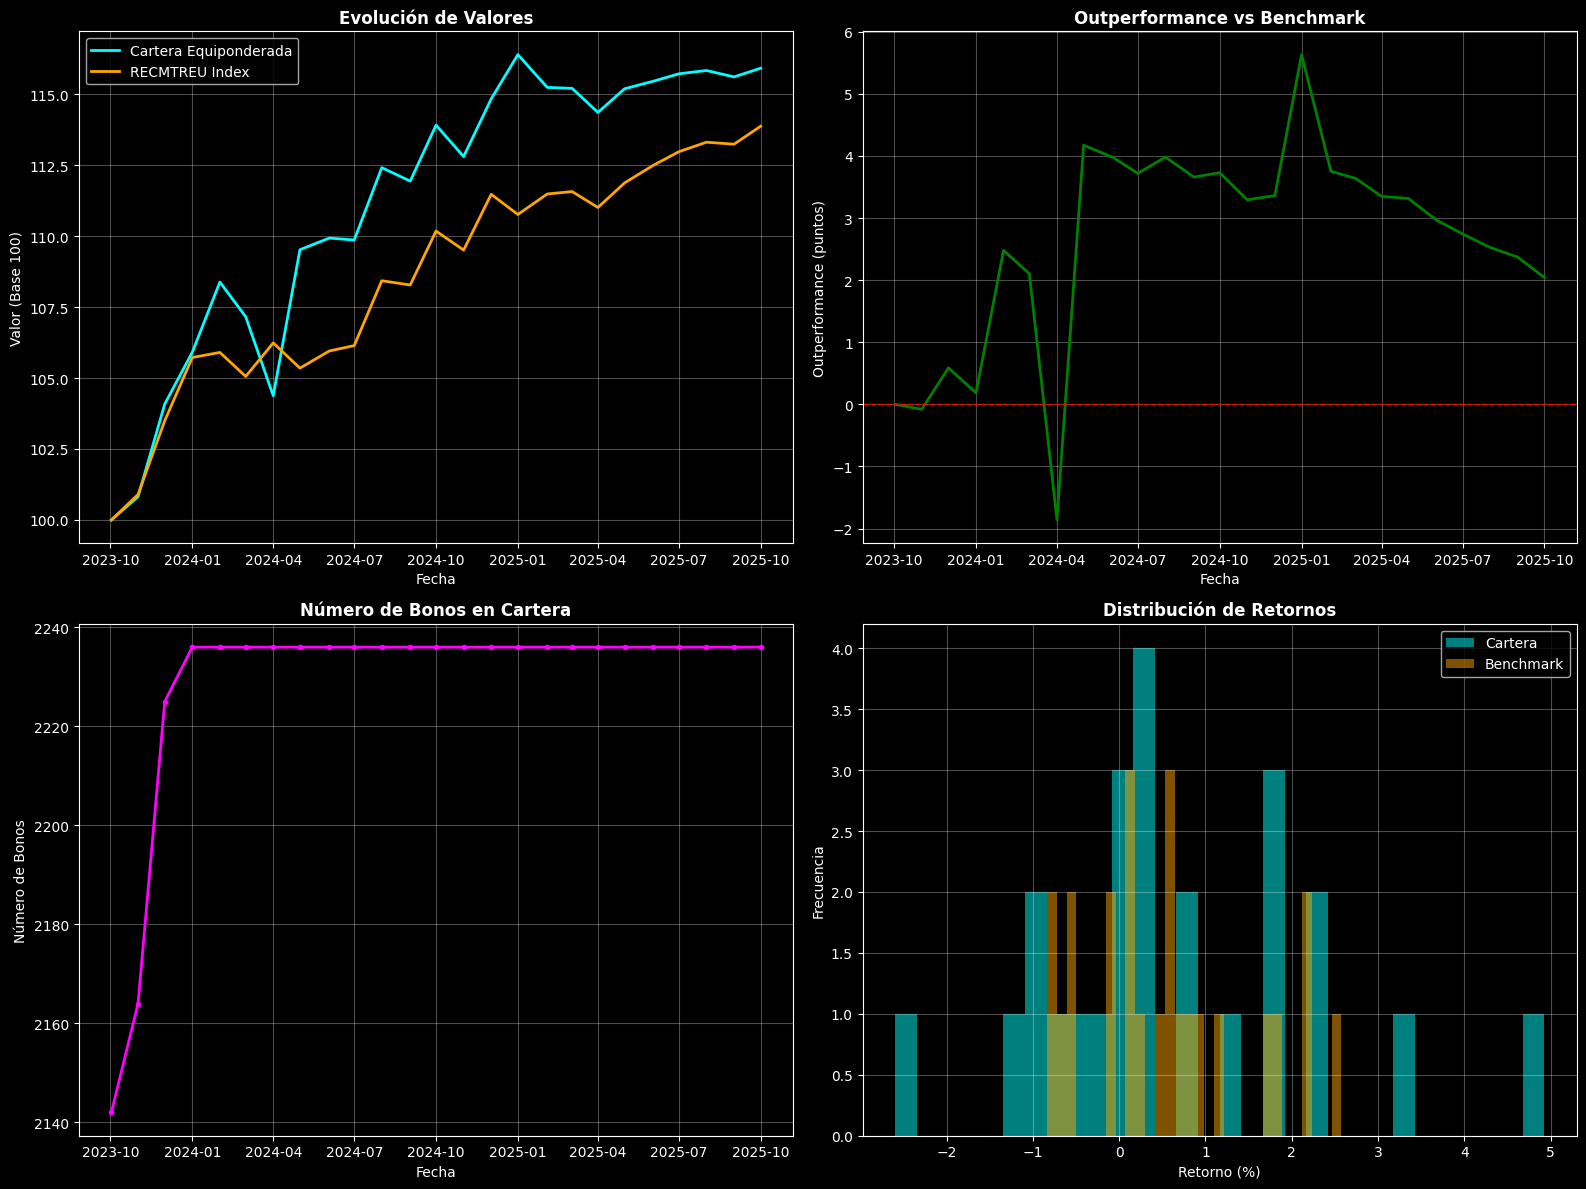


CONCLUSIONES:

1. La cartera equiponderada proporciona diversificación automática.

2. Lo más correcto en lugar de precios MID sería:
   - Usar precios de ejecución reales (bid para compra, ask para venta)
   - Incluir costes de transacción (comisiones, spreads bid-ask)
   - Considerar impacto de mercado en operaciones grandes
   - Usar precios intradía si están disponibles

3. Otros benchmarks que se podrían utilizar:
   - iBoxx EUR Corporate (Investment Grade)
   - iBoxx EUR Corporate por sectores
   - Benchmark personalizado con mismas restricciones que la cartera
   - Índices de duración específica (ej: 2-3 años)



In [ ]:
# ============================================================================
# EJERCICIO 5: CARTERA EQUIPONDERADA Y BACKTEST
# ============================================================================
# Construimos una cartera equiponderada y hacemos backtest comparando con benchmark
# Usamos los precios traspuestos del ejercicio 1 y aplicamos ffill a valores vacíos
# ============================================================================

print("=" * 80)
print("EJERCICIO 5: CARTERA EQUIPONDERADA Y BACKTEST")
print("=" * 80)

# Usar los precios traspuestos del ejercicio 1 (precios_transpuesto)
# Si no existe, crearlo desde precios_universo
if 'precios_transpuesto' not in locals() and 'precios_transpuesto' not in globals():
    print("\n⚠️  Variable 'precios_transpuesto' no encontrada. Creándola desde precios_universo...")
    
    # Cargar precios si no están cargados
    if 'precios_universo' not in locals() and 'precios_universo' not in globals():
        precios_universo = pd.read_csv(
            '../data/precios_historicos_universo.csv',
            sep=';',
            decimal='.',
            na_values=['#N/D', ' ', 'NA', 'nan', 'N/A', '']
        )
    
    # Preparación y transposición (igual que en ejercicio 1)
    precios_df_preparado = precios_universo.rename(
        columns={precios_universo.columns[0]: 'Date'}
    ).set_index('Date')
    
    # Ejecutar la transpuesta (.T)
    precios_transpuesto = precios_df_preparado.T
    
    # Limpieza de fechas
    precios_transpuesto.index = pd.to_datetime(
        precios_transpuesto.index,
        format='%d/%m/%Y',
        errors='coerce'
    )
    
    # Eliminar filas completamente nulas
    precios_transpuesto = precios_transpuesto.dropna(how='all')
    
    print("✓ Precios traspuestos creados desde precios_universo")
else:
    print("\n✓ Usando precios_transpuesto del ejercicio 1")

# Aplicar forward fill (ffill) a los valores vacíos
# ffill rellena hacia adelante usando el último valor válido
print("\nAplicando forward fill (ffill) a valores vacíos...")
precios_historicos_universo = precios_transpuesto.copy()

# Verificar estructura antes del ffill
print(f"   Estructura: {precios_historicos_universo.shape[0]} fechas (filas) x {precios_historicos_universo.shape[1]} ISINs (columnas)")

# Aplicar ffill por columna (a lo largo del tiempo para cada ISIN)
# axis=0 significa rellenar hacia abajo (en el tiempo, a lo largo de las fechas)
# Esto rellena cada columna (ISIN) hacia adelante en el tiempo
precios_historicos_universo = precios_historicos_universo.sort_index().ffill(axis=0)

# Si aún quedan valores nulos al principio (antes del primer precio válido),
# podemos usar bfill (backward fill) para rellenar hacia atrás
precios_historicos_universo = precios_historicos_universo.bfill(axis=0)

# Verificar cuántos valores nulos quedan
nulos_antes = precios_transpuesto.isna().sum().sum()
nulos_despues = precios_historicos_universo.isna().sum().sum()
print(f"   Valores nulos antes de ffill: {nulos_antes:,}")
print(f"   Valores nulos después de ffill: {nulos_despues:,}")
print(f"   Valores rellenados: {nulos_antes - nulos_despues:,}")

# Verificar que los precios sean numéricos
precios_historicos_universo = precios_historicos_universo.apply(pd.to_numeric, errors='coerce')

# Mostrar estadísticas de precios después del ffill
print(f"\n   Estadísticas de precios después del ffill:")
print(f"   - Precios válidos (>0): {(precios_historicos_universo > 0).sum().sum():,}")
print(f"   - Precios nulos: {precios_historicos_universo.isna().sum().sum():,}")
print(f"   - Rango de precios: [{precios_historicos_universo.min().min():.2f}, {precios_historicos_universo.max().max():.2f}]")

# Normalizar el índice de fechas (asegurar que no tenga componente de hora)
precios_historicos_universo.index = pd.to_datetime(precios_historicos_universo.index).normalize()

# IMPORTANTE: Limpiar los nombres de las columnas (ISINs) para que coincidan con el universo
# Los precios tienen " Corp" al final, pero el universo no
print("\nLimpiando nombres de columnas (ISINs) para que coincidan con el universo...")
columnas_originales = precios_historicos_universo.columns.tolist()
# Eliminar " Corp" del final de cada nombre de columna
columnas_limpias = [col.replace(' Corp', '') if isinstance(col, str) else col for col in columnas_originales]
precios_historicos_universo.columns = columnas_limpias

print(f"   Ejemplo: '{columnas_originales[0]}' -> '{columnas_limpias[0]}'")

print(f"\nPrecios históricos cargados: {len(precios_historicos_universo)} fechas, {len(precios_historicos_universo.columns)} ISINs")
print(f"Estructura: índice = fechas, columnas = ISINs")
print(f"Primeras fechas: {precios_historicos_universo.index[:5].tolist()}")
print(f"Primeros 5 ISINs en precios: {list(precios_historicos_universo.columns[:5])}")
print(f"Primeros 5 ISINs en universo: {list(universo['ISIN'].head()) if 'ISIN' in universo.columns else 'No hay columna ISIN'}")

# Verificar coincidencia de ISINs
if 'ISIN' in universo.columns:
    isins_precios = set(precios_historicos_universo.columns)
    isins_universo = set(universo['ISIN'].dropna())
    isins_comunes = isins_precios.intersection(isins_universo)
    print(f"\n✓ ISINs comunes entre precios y universo: {len(isins_comunes)}")
    print(f"  ISINs solo en precios: {len(isins_precios - isins_universo)}")
    print(f"  ISINs solo en universo: {len(isins_universo - isins_precios)}")

# Cargar benchmark (RECMTREU)
precios_varios = pd.read_csv('../data/precios_historicos_varios.csv', 
                             sep=';', decimal='.', 
                             na_values=['#N/D', ' ', 'NA', 'nan', 'N/A'])

fecha_col = precios_varios.columns[0]
precios_varios[fecha_col] = pd.to_datetime(precios_varios[fecha_col], 
                                           format='%d/%m/%Y', errors='coerce')
precios_varios = precios_varios.set_index(fecha_col)

benchmark_precios = precios_varios[['RECMTREU Index']].copy()

# Fechas de rebalanceo (mensual)
# Usar las fechas disponibles en los precios históricos
fecha_inicio = pd.to_datetime('2023-10-02')
fecha_fin = pd.to_datetime('2025-10-01')

# Obtener fechas disponibles en el rango
fechas_disponibles = precios_historicos_universo.index[
    (precios_historicos_universo.index >= fecha_inicio) & 
    (precios_historicos_universo.index <= fecha_fin)
]

# Seleccionar una fecha por mes (la primera disponible de cada mes)
fechas_rebalanceo = []
mes_actual = None
año_actual = None
for fecha in fechas_disponibles:
    if mes_actual is None or fecha.month != mes_actual or fecha.year != año_actual:
        fechas_rebalanceo.append(fecha)
        mes_actual = fecha.month
        año_actual = fecha.year

# Convertir a DatetimeIndex y normalizar para asegurar formato consistente
fechas_rebalanceo = pd.DatetimeIndex([pd.to_datetime(f).normalize() for f in fechas_rebalanceo])

print(f"Fechas de rebalanceo: {len(fechas_rebalanceo)}")
if len(fechas_rebalanceo) > 0:
    print(f"Rango: {fechas_rebalanceo[0]} a {fechas_rebalanceo[-1]}")
    print(f"Primeras 5 fechas: {fechas_rebalanceo[:5].tolist()}")
else:
    print("No se encontraron fechas disponibles en el rango especificado")

# Función auxiliar para encontrar la fecha más cercana disponible
def encontrar_fecha_cercana(fecha, precios_df):
    """Encuentra la fecha más cercana disponible en el DataFrame de precios."""
    # Normalizar fecha a pd.Timestamp para comparación consistente
    if isinstance(fecha, datetime.date):
        fecha = pd.to_datetime(fecha)
    elif not isinstance(fecha, pd.Timestamp):
        fecha = pd.to_datetime(fecha)
    
    # Normalizar a fecha sin hora para comparar solo fechas
    fecha_normalizada = fecha.normalize() if hasattr(fecha, 'normalize') else fecha
    
    # Normalizar índice del DataFrame también
    try:
        indice_normalizado = precios_df.index.normalize()
    except:
        indice_normalizado = precios_df.index
    
    # Buscar fecha exacta
    if fecha_normalizada in indice_normalizado:
        idx_pos = indice_normalizado.get_loc(fecha_normalizada)
        return precios_df.index[idx_pos]
    
    # Buscar la fecha más cercana anterior
    fechas_disponibles = indice_normalizado[indice_normalizado <= fecha_normalizada]
    if len(fechas_disponibles) > 0:
        fecha_encontrada = fechas_disponibles[-1]
        idx_pos = indice_normalizado.get_loc(fecha_encontrada)
        return precios_df.index[idx_pos]
    
    return None

# Función para obtener bonos vivos en una fecha
def obtener_bonos_vivos(fecha, universo_df, precios_df):
    """Obtiene los bonos vivos (disponibles) en una fecha dada."""
    # Convertir fecha a datetime si es date
    if isinstance(fecha, datetime.date):
        fecha = pd.to_datetime(fecha)
    
    # Encontrar fecha más cercana disponible
    fecha_disponible = encontrar_fecha_cercana(fecha, precios_df)
    if fecha_disponible is None:
        return pd.DataFrame()
    
    # Filtrar bonos emitidos antes de la fecha
    bonos_emitidos = universo_df[
        pd.to_datetime(universo_df.get('Issue date', pd.NaT), errors='coerce') <= fecha
    ]
    
    # Filtrar bonos que no han vencido
    bonos_vivos = bonos_emitidos[
        pd.to_datetime(bonos_emitidos.get('Maturity', pd.NaT), errors='coerce') > fecha
    ]
    
    # Filtrar bonos con precio disponible en la fecha más cercana
    if fecha_disponible in precios_df.index:
        precios_fecha = precios_df.loc[fecha_disponible]
        # Obtener ISINs con precio válido (no nulo y > 0)
        # Después del ffill, algunos valores pueden seguir siendo nulos si no había valores previos
        isins_con_precio = precios_fecha[
            precios_fecha.notna() & 
            (precios_fecha > 0) & 
            (precios_fecha < 1000)  # Filtrar valores anómalos (precios muy altos)
        ].index.tolist()
        
        # Convertir a string para asegurar coincidencia
        isins_con_precio = [str(isin) for isin in isins_con_precio]
        bonos_vivos = bonos_vivos[bonos_vivos['ISIN'].isin(isins_con_precio)]
    
    return bonos_vivos

# Función para calcular rentabilidad total
def calcular_rentabilidad_total(fecha_anterior, fecha_actual, isins, pesos, precios_df):
    """Calcula la rentabilidad total de la cartera entre dos fechas."""
    rentabilidad_total = 0.0
    
    # Encontrar fechas más cercanas disponibles
    fecha_ant_disponible = encontrar_fecha_cercana(fecha_anterior, precios_df)
    fecha_act_disponible = encontrar_fecha_cercana(fecha_actual, precios_df)
    
    if fecha_ant_disponible is None or fecha_act_disponible is None:
        return 0.0
    
    for isin, peso in zip(isins, pesos):
        # Convertir ISIN a string para asegurar coincidencia
        isin_str = str(isin)
        
        if isin_str not in precios_df.columns:
            continue
        
        try:
            precio_anterior = precios_df.loc[fecha_ant_disponible, isin_str]
            precio_actual = precios_df.loc[fecha_act_disponible, isin_str]
            
            # Verificar que ambos precios sean válidos (no nulos, > 0, y razonables)
            if (pd.notna(precio_anterior) and pd.notna(precio_actual) and 
                precio_anterior > 0 and precio_actual > 0 and
                precio_anterior < 1000 and precio_actual < 1000):  # Filtrar valores anómalos
                retorno = (precio_actual - precio_anterior) / precio_anterior
                rentabilidad_total += peso * retorno
        except (KeyError, IndexError, TypeError):
            continue
    
    return rentabilidad_total

# Ejecutar backtest
print("\n" + "=" * 80)
print("EJECUTANDO BACKTEST DE CARTERA EQUIPONDERADA")
print("=" * 80)

if len(fechas_rebalanceo) == 0:
    print("ERROR: No hay fechas disponibles para el backtest")
    print("Verifica que los precios históricos contengan datos en el rango especificado")
else:
    resultados_backtest = []
    valor_cartera = 100.0  # Valor inicial = 100
    valor_benchmark = 100.0

    # Información de depuración
    print(f"\nIniciando backtest con {len(fechas_rebalanceo)} fechas de rebalanceo...")
    
    for i, fecha in enumerate(fechas_rebalanceo):
        # Obtener bonos vivos
        bonos_vivos = obtener_bonos_vivos(fecha, universo, precios_historicos_universo)
        
        n_bonos = len(bonos_vivos)
        
        # Información de depuración para las primeras iteraciones
        if i < 3:
            print(f"\nFecha {i+1}/{len(fechas_rebalanceo)}: {fecha.date()}")
            print(f"  Bonos vivos encontrados: {n_bonos}")
            if n_bonos > 0:
                print(f"  Primeros 3 ISINs: {bonos_vivos['ISIN'].head(3).tolist()}")
        
        # Calcular rentabilidad de la cartera solo si hay bonos vivos
        if n_bonos > 0 and i > 0:
            # Peso equiponderado
            peso_por_bono = 1.0 / n_bonos
            isins = bonos_vivos['ISIN'].tolist()
            pesos = [peso_por_bono] * n_bonos
            
            # Calcular rentabilidad desde fecha anterior
            fecha_anterior = fechas_rebalanceo[i-1]
            retorno_cartera = calcular_rentabilidad_total(
                fecha_anterior, fecha, isins, pesos, precios_historicos_universo
            )
            valor_cartera *= (1 + retorno_cartera)
        elif i == 0:
            # Primera fecha: mantener valor inicial
            pass
        elif n_bonos == 0:
            # No hay bonos vivos: mantener el valor anterior (sin cambios)
            pass
        
        # Calcular rentabilidad benchmark (siempre, para tener la comparativa completa)
        if i > 0:
            fecha_anterior = fechas_rebalanceo[i-1]
            # Rentabilidad benchmark (usar fechas más cercanas disponibles)
            fecha_ant_bench = encontrar_fecha_cercana(fecha_anterior, benchmark_precios)
            fecha_act_bench = encontrar_fecha_cercana(fecha, benchmark_precios)
            
            if fecha_ant_bench is not None and fecha_act_bench is not None:
                try:
                    precio_bench_anterior = benchmark_precios.loc[fecha_ant_bench, 'RECMTREU Index']
                    precio_bench_actual = benchmark_precios.loc[fecha_act_bench, 'RECMTREU Index']
                    if pd.notna(precio_bench_anterior) and pd.notna(precio_bench_actual) and precio_bench_anterior > 0:
                        retorno_bench = (precio_bench_actual - precio_bench_anterior) / precio_bench_anterior
                        valor_benchmark *= (1 + retorno_bench)
                except (KeyError, IndexError):
                    pass
        
        resultados_backtest.append({
            'Fecha': fecha,
            'N_Bonos': n_bonos,
            'Valor_Cartera': valor_cartera,
            'Valor_Benchmark': valor_benchmark,
            'Outperformance': valor_cartera - valor_benchmark
        })

    df_backtest = pd.DataFrame(resultados_backtest)
    if len(df_backtest) > 0:
        df_backtest = df_backtest.set_index('Fecha')

        print(f"\nResultados del backtest:")
        print(df_backtest.tail(10))

        # Calcular métricas de performance
        retornos_cartera = df_backtest['Valor_Cartera'].pct_change().dropna()
        retornos_bench = df_backtest['Valor_Benchmark'].pct_change().dropna()

        rentabilidad_total_cartera = (df_backtest['Valor_Cartera'].iloc[-1] / 
                                     df_backtest['Valor_Cartera'].iloc[0] - 1) * 100
        rentabilidad_total_bench = (df_backtest['Valor_Benchmark'].iloc[-1] / 
                                   df_backtest['Valor_Benchmark'].iloc[0] - 1) * 100

        volatilidad_cartera = retornos_cartera.std() * np.sqrt(252) * 100
        volatilidad_bench = retornos_bench.std() * np.sqrt(252) * 100

        excess_returns = retornos_cartera - retornos_bench
        tracking_error = excess_returns.std() * np.sqrt(252) * 100
        information_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252) if excess_returns.std() > 0 else 0

        print("\n" + "=" * 80)
        print("MÉTRICAS DE PERFORMANCE")
        print("=" * 80)
        print(f"Rentabilidad Total Cartera: {rentabilidad_total_cartera:.2f}%")
        print(f"Rentabilidad Total Benchmark: {rentabilidad_total_bench:.2f}%")
        print(f"Outperformance: {rentabilidad_total_cartera - rentabilidad_total_bench:.2f}%")
        print(f"Volatilidad Cartera: {volatilidad_cartera:.2f}%")
        print(f"Volatilidad Benchmark: {volatilidad_bench:.2f}%")
        print(f"Tracking Error: {tracking_error:.2f}%")
        print(f"Information Ratio: {information_ratio:.4f}")

        # Visualización
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Evolución de valores
        axes[0, 0].plot(df_backtest.index, df_backtest['Valor_Cartera'], 
                        label='Cartera Equiponderada', linewidth=2, color='cyan')
        axes[0, 0].plot(df_backtest.index, df_backtest['Valor_Benchmark'], 
                        label='RECMTREU Index', linewidth=2, color='orange')
        axes[0, 0].set_title('Evolución de Valores', fontweight='bold')
        axes[0, 0].set_xlabel('Fecha')
        axes[0, 0].set_ylabel('Valor (Base 100)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Outperformance
        axes[0, 1].plot(df_backtest.index, df_backtest['Outperformance'], 
                        linewidth=2, color='green')
        axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=1)
        axes[0, 1].set_title('Outperformance vs Benchmark', fontweight='bold')
        axes[0, 1].set_xlabel('Fecha')
        axes[0, 1].set_ylabel('Outperformance (puntos)')
        axes[0, 1].grid(True, alpha=0.3)

        # Número de bonos en cartera
        axes[1, 0].plot(df_backtest.index, df_backtest['N_Bonos'], 
                        linewidth=2, color='magenta', marker='o', markersize=3)
        axes[1, 0].set_title('Número de Bonos en Cartera', fontweight='bold')
        axes[1, 0].set_xlabel('Fecha')
        axes[1, 0].set_ylabel('Número de Bonos')
        axes[1, 0].grid(True, alpha=0.3)

        # Distribución de retornos
        axes[1, 1].hist(retornos_cartera * 100, bins=30, alpha=0.5, label='Cartera', color='cyan')
        axes[1, 1].hist(retornos_bench * 100, bins=30, alpha=0.5, label='Benchmark', color='orange')
        axes[1, 1].set_title('Distribución de Retornos', fontweight='bold')
        axes[1, 1].set_xlabel('Retorno (%)')
        axes[1, 1].set_ylabel('Frecuencia')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("\n" + "=" * 80)
        print("CONCLUSIONES:")
        print("=" * 80)
        print("""
1. La cartera equiponderada proporciona diversificación automática.

2. Lo más correcto en lugar de precios MID sería:
   - Usar precios de ejecución reales (bid para compra, ask para venta)
   - Incluir costes de transacción (comisiones, spreads bid-ask)
   - Considerar impacto de mercado en operaciones grandes
   - Usar precios intradía si están disponibles

3. Otros benchmarks que se podrían utilizar:
   - iBoxx EUR Corporate (Investment Grade)
   - iBoxx EUR Corporate por sectores
   - Benchmark personalizado con mismas restricciones que la cartera
   - Índices de duración específica (ej: 2-3 años)
""")
    else:
        print("No se generaron resultados del backtest")


### <font color=#336699>6. Cartera mandato</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Como adelantábamos en el enunciado, tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
- La duración de la cartera no debe superar los 3 años
- La exposición a emisiones HY no puede superar el 10% de la cartera
- No puedes invertir en deuda subordinada
- No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
- No se puede invertir más de un 10% del capital en una misma emisión
- No puede haber más de un 15% de concentración en un mismo emisor
(¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

1. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

2. ¿Cómo medirías el riesgo de crédito de la cartera?

3. ¿Cómo medirías el riesgo de liquidez de la cartera? ¿Se te ocurre alguna otra información que se podría utilizar aunque no se te haya dado?

4. Describe cómo habría que hacer el backtest de esta cartera, no hace falta que lo implementes en este caso

</div>

EJERCICIO 6: CARTERA CON MANDATO - MAXIMIZANDO YTM

1. Aplicando filtros iniciales...
   Bonos elegibles tras filtros: 1353

2. Calculando YTM y Duración para cada bono...
   (Esto puede tardar unos segundos...)
   Bonos con métricas válidas: 1353

3. Clasificando ratings...
   Bonos con rating válido: 1204
   - Investment Grade: 1199
   - High Yield: 5

4. Preseleccionando candidatos para optimización...
   Pool de candidatos para optimización: 109 bonos

5. Optimizando cartera para maximizar YTM...
   Ejecutando optimización (método SLSQP)...

6. Resultados de la optimización...

CARTERA ÓPTIMA GENERADA - MAXIMIZANDO YTM

✓ Número de bonos:           10 / 20 (máximo)
✓ YTM de la cartera:         8.00%
✓ Duración ponderada:       0.94 años (máx 3.0)
✓ Exposición High Yield:     0.00% (máx 10%)
✓ Máximo peso por emisión:   10.00% (máx 10%)
✓ Máximo peso por emisor:    10.00% (máx 15%)
✓ Número de emisores:        10

---------------------------------------------------------------------

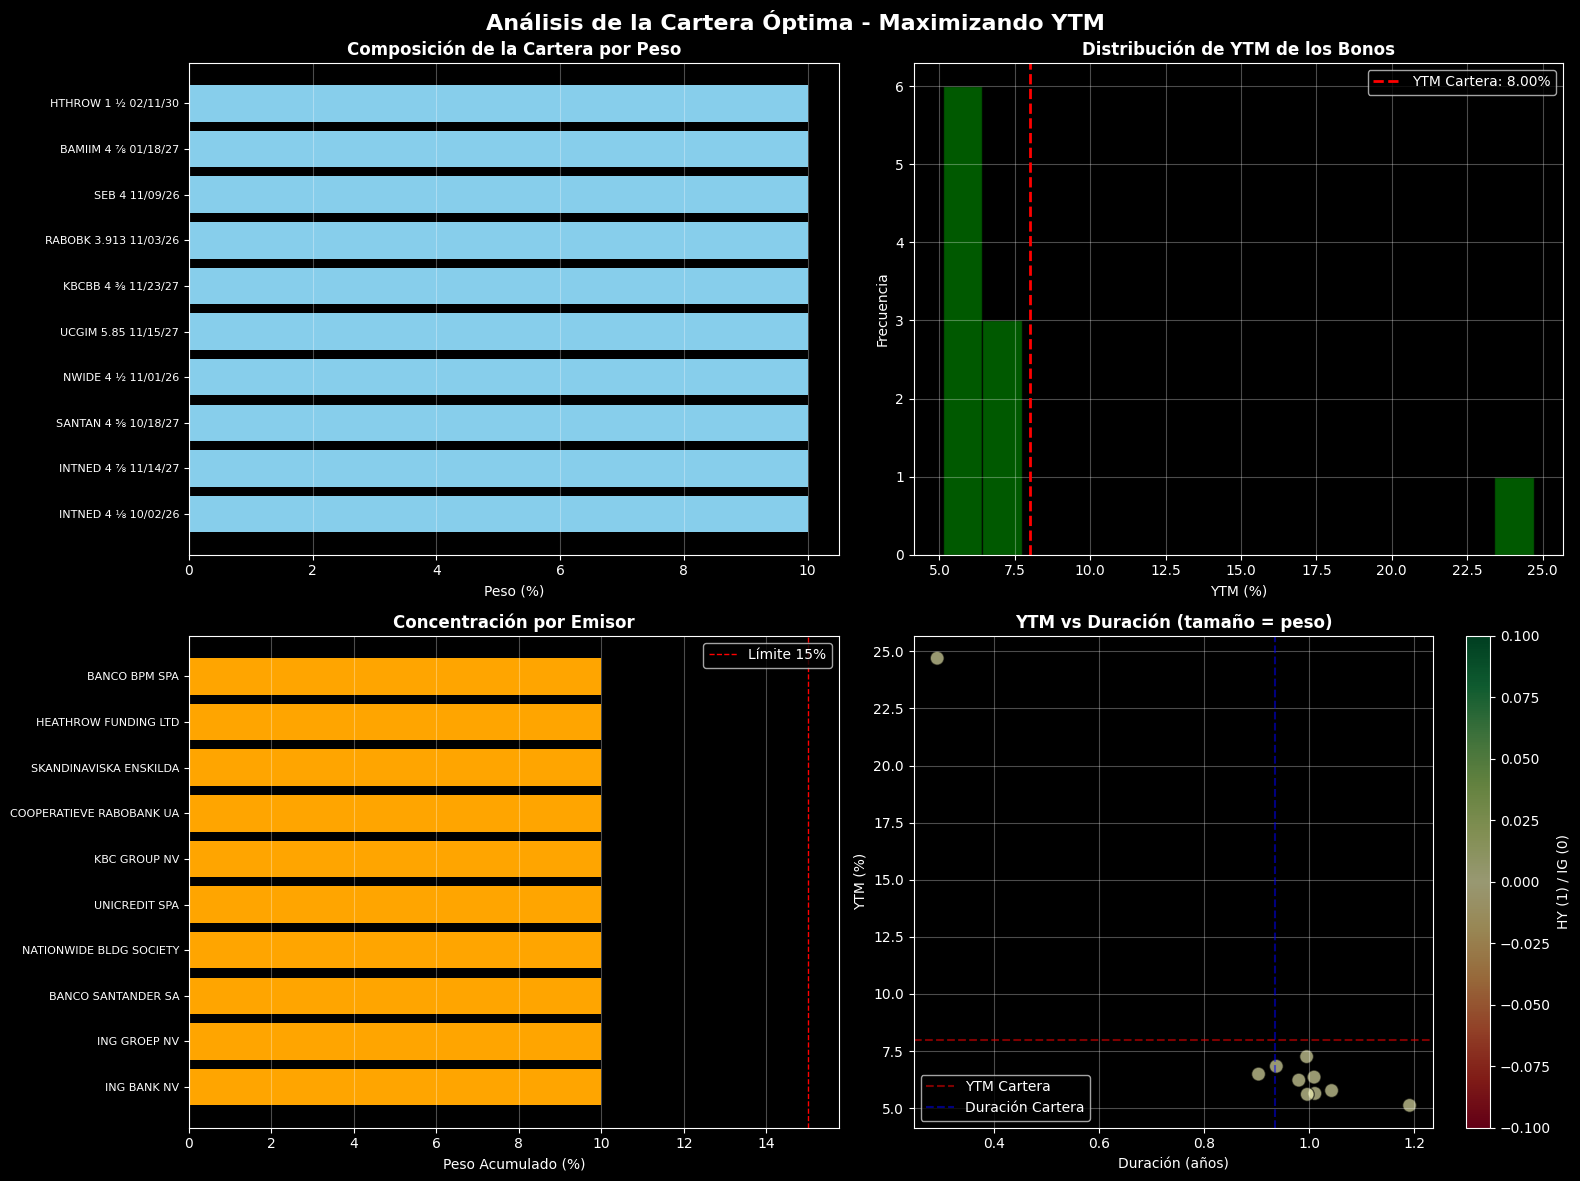


✓ CARTERA CONSTRUIDA EXITOSAMENTE


In [ ]:

# ==============================================================================
# EJERCICIO 6: CONSTRUCCIÓN DE CARTERA CON MANDATO - MAXIMIZANDO YTM
# ==============================================================================
# Objetivo: Construir cartera de máximo 20 bonos que maximice YTM
# Restricciones:
# - Duración <= 3 años
# - Exposición HY <= 10%
# - No deuda subordinada
# - Tamaño emisión > 500M
# - Máximo 10% por emisión
# - Máximo 15% por emisor
# ==============================================================================

from scipy.optimize import minimize, newton
from scipy.optimize import minimize as opt_minimize
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("EJERCICIO 6: CARTERA CON MANDATO - MAXIMIZANDO YTM")
print("=" * 80)

# ==============================================================================
# 1. FILTROS INICIALES (RESTRICCIONES HARD)
# ==============================================================================
print("\n1. Aplicando filtros iniciales...")

# FILTRO 1: Tamaño de emisión > 500 Millones
filtro_tamano = universo['Outstanding Amount'] > 500_000_000

# FILTRO 2: No Deuda Subordinada
filtro_seniority = ~universo['Seniority'].str.contains('Subordinated|Jr', case=False, na=False)

# FILTRO 3: Bonos vivos (no vencidos) y con precio disponible
filtro_vivos = (universo['Maturity'] > fecha_analisis) & (universo['Price'].notna())

# Aplicar todos los filtros
df_eligible = universo[
    filtro_tamano & 
    filtro_seniority & 
    filtro_vivos
].copy()

print(f"   Bonos elegibles tras filtros: {len(df_eligible)}")

# ==============================================================================
# 2. CÁLCULO DE YTM Y DURACIÓN PARA CADA BONO
# ==============================================================================
print("\n2. Calculando YTM y Duración para cada bono...")
print("   (Esto puede tardar unos segundos...)")

# Usar la función calcular_ytm que ya está definida en el notebook
fecha_analisis_dt = pd.to_datetime(fecha_analisis)

def calcular_ytm_y_duracion(row):
    """
    Calcula YTM y Duración Modificada para un bono usando la función calcular_ytm
    que ya está definida en el notebook.
    """
    try:
        precio_mercado = row['Price']
        if pd.isna(precio_mercado) or precio_mercado <= 0:
            return np.nan, np.nan
        
        # Calcular YTM usando la función del notebook
        ytm = calcular_ytm(row, precio_mercado, fecha_analisis_dt)
        
        if np.isnan(ytm) or ytm <= 0:
            return np.nan, np.nan
        
        # Calcular Duración Modificada
        duracion_mod = calcular_duracion_modificada(
            calcular_duracion_macaulay(row, fecha_analisis_dt, ytm),
            ytm,
            int(row['Coupon Frequency']) if pd.notna(row['Coupon Frequency']) else 1
        )
        
        return ytm, duracion_mod
    except Exception as e:
        return np.nan, np.nan

# Calcular métricas para todos los bonos elegibles
metricas_list = []
for idx, bono in df_eligible.iterrows():
    ytm, dur = calcular_ytm_y_duracion(bono)
    metricas_list.append({'YTM': ytm, 'Duration': dur})

df_metricas = pd.DataFrame(metricas_list)
df_eligible['YTM'] = df_metricas['YTM'].values
df_eligible['Duration'] = df_metricas['Duration'].values

# Eliminar bonos sin métricas válidas
df_eligible = df_eligible.dropna(subset=['YTM', 'Duration'])
df_eligible = df_eligible[(df_eligible['YTM'] > 0) & (df_eligible['Duration'] > 0)]

print(f"   Bonos con métricas válidas: {len(df_eligible)}")

# ==============================================================================
# 3. CLASIFICACIÓN DE RATINGS (IG vs HY)
# ==============================================================================
print("\n3. Clasificando ratings...")

# Definir ratings Investment Grade y High Yield
investment_grade = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
high_yield = ['BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D']

def clasificar_rating(rating):
    if pd.isna(rating) or str(rating).strip() == 'NR':
        return 'NR'
    rating_clean = str(rating).strip()
    if rating_clean in investment_grade:
        return 'IG'
    elif rating_clean in high_yield:
        return 'HY'
    else:
        return 'NR'

df_eligible['Rating_Class'] = df_eligible['Rating'].apply(clasificar_rating)
df_eligible['Is_HY'] = (df_eligible['Rating_Class'] == 'HY').astype(int)

# Eliminar bonos sin rating (NR) ya que no podemos clasificarlos
df_eligible = df_eligible[df_eligible['Rating_Class'] != 'NR']

print(f"   Bonos con rating válido: {len(df_eligible)}")
print(f"   - Investment Grade: {len(df_eligible[df_eligible['Rating_Class'] == 'IG'])}")
print(f"   - High Yield: {len(df_eligible[df_eligible['Rating_Class'] == 'HY'])}")

# ==============================================================================
# 4. PRESELECCIÓN DE CANDIDATOS PARA OPTIMIZACIÓN
# ==============================================================================
print("\n4. Preseleccionando candidatos para optimización...")

# Estrategia: Seleccionar top candidatos por YTM y algunos de baja duración
# para asegurar que podemos cumplir la restricción de duración <= 3 años

# Top 100 por YTM
candidatos_ytm = df_eligible.nlargest(100, 'YTM')

# Top 50 de baja duración (< 2.5 años) con buen YTM
candidatos_duracion = df_eligible[df_eligible['Duration'] < 2.5].nlargest(50, 'YTM')

# Combinar y eliminar duplicados
pool = pd.concat([candidatos_ytm, candidatos_duracion]).drop_duplicates(subset=['ISIN']).reset_index(drop=True)

print(f"   Pool de candidatos para optimización: {len(pool)} bonos")

# ==============================================================================
# 5. OPTIMIZACIÓN: MAXIMIZAR YTM CON RESTRICCIONES
# ==============================================================================
print("\n5. Optimizando cartera para maximizar YTM...")

n = len(pool)
ytm_values = pool['YTM'].values
dur_values = pool['Duration'].values
is_hy_values = pool['Is_HY'].values

# Crear matriz de emisores para restricción de concentración
emisores = pool['Issuer'].values
emisores_unicos = pd.unique(emisores)
matriz_emisores = np.array([(emisores == emisor).astype(float) for emisor in emisores_unicos]).T

# Función objetivo: MAXIMIZAR YTM (minimizar -YTM)
def objetivo(w):
    return -np.dot(w, ytm_values)

# Restricciones
constraints = []

# Restricción 1: Suma de pesos = 1 (100% invertido)
constraints.append({
    'type': 'eq',
    'fun': lambda w: np.sum(w) - 1.0
})

# Restricción 2: Duración ponderada <= 3 años
constraints.append({
    'type': 'ineq',
    'fun': lambda w: 3.0 - np.dot(w, dur_values)
})

# Restricción 3: Exposición HY <= 10%
constraints.append({
    'type': 'ineq',
    'fun': lambda w: 0.10 - np.dot(w, is_hy_values)
})

# Restricción 4: Máximo 15% por emisor
for i in range(len(emisores_unicos)):
    emisor_col = matriz_emisores[:, i]
    constraints.append({
        'type': 'ineq',
        'fun': lambda w, col=emisor_col: 0.15 - np.dot(w, col)
    })

# Restricción 5: Máximo 20 bonos (usando penalización L0 aproximada)
# Usaremos una aproximación: penalizar si hay más de 20 pesos > umbral
def restriccion_max_bonos(w):
    # Contar bonos con peso > 0.001 (0.1%)
    num_bonos = np.sum(w > 0.001)
    # Penalizar si hay más de 20
    return 20.0 - num_bonos

constraints.append({
    'type': 'ineq',
    'fun': restriccion_max_bonos
})

# Bounds: cada bono entre 0% y 10% (máximo 10% por emisión)
bounds = [(0.0, 0.10) for _ in range(n)]

# Punto inicial: distribución equiponderada entre los top 20 por YTM
top_20_idx = np.argsort(ytm_values)[-20:][::-1]
x0 = np.zeros(n)
x0[top_20_idx] = 1.0 / 20.0

# Ejecutar optimización
print("   Ejecutando optimización (método SLSQP)...")
resultado = opt_minimize(
    objetivo,
    x0=x0,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000, 'ftol': 1e-6}
)

# ==============================================================================
# 6. RESULTADOS Y VERIFICACIÓN
# ==============================================================================
print("\n6. Resultados de la optimización...")

if resultado.success:
    pesos = resultado.x
    pool['Weight'] = pesos
    
    # Filtrar bonos con peso significativo (> 0.1%)
    cartera = pool[pool['Weight'] > 0.001].copy()
    cartera = cartera.sort_values('Weight', ascending=False)
    
    # Calcular métricas de la cartera
    ytm_cartera = np.dot(cartera['Weight'], cartera['YTM'])
    duracion_cartera = np.dot(cartera['Weight'], cartera['Duration'])
    peso_hy = np.dot(cartera['Weight'], cartera['Is_HY'])
    
    # Verificar restricciones
    peso_por_emisor = cartera.groupby('Issuer')['Weight'].sum()
    max_peso_emisor = peso_por_emisor.max() if len(peso_por_emisor) > 0 else 0.0
    max_peso_emision = cartera['Weight'].max()
    
    print("\n" + "=" * 80)
    print("CARTERA ÓPTIMA GENERADA - MAXIMIZANDO YTM")
    print("=" * 80)
    print(f"\n✓ Número de bonos:           {len(cartera)} / 20 (máximo)")
    print(f"✓ YTM de la cartera:         {ytm_cartera*100:.2f}%")
    print(f"✓ Duración ponderada:       {duracion_cartera:.2f} años (máx 3.0)")
    print(f"✓ Exposición High Yield:     {peso_hy*100:.2f}% (máx 10%)")
    print(f"✓ Máximo peso por emisión:   {max_peso_emision*100:.2f}% (máx 10%)")
    print(f"✓ Máximo peso por emisor:    {max_peso_emisor*100:.2f}% (máx 15%)")
    print(f"✓ Número de emisores:        {cartera['Issuer'].nunique()}")
    
    # Verificación de restricciones
    print("\n" + "-" * 80)
    print("VERIFICACIÓN DE RESTRICCIONES:")
    print("-" * 80)
    print(f"✓ Duración <= 3 años:        {'✓ CUMPLE' if duracion_cartera <= 3.0 else '✗ NO CUMPLE'}")
    print(f"✓ HY <= 10%:                 {'✓ CUMPLE' if peso_hy <= 0.10 else '✗ NO CUMPLE'}")
    print(f"✓ Bonos <= 20:                {'✓ CUMPLE' if len(cartera) <= 20 else '✗ NO CUMPLE'}")
    print(f"✓ Peso emisión <= 10%:       {'✓ CUMPLE' if max_peso_emision <= 0.10 else '✗ NO CUMPLE'}")
    print(f"✓ Peso emisor <= 15%:        {'✓ CUMPLE' if max_peso_emisor <= 0.15 else '✗ NO CUMPLE'}")
    
    # Mostrar tabla detallada de la cartera
    print("\n" + "-" * 80)
    print("COMPOSICIÓN DE LA CARTERA:")
    print("-" * 80)
    
    display_cols = ['ISIN', 'Description', 'Issuer', 'Rating', 'YTM', 'Duration', 'Weight', 'Is_HY']
    display_df = cartera[display_cols].copy()
    display_df['YTM'] = (display_df['YTM'] * 100).round(2)
    display_df['Duration'] = display_df['Duration'].round(2)
    display_df['Weight'] = (display_df['Weight'] * 100).round(2)
    display_df['Is_HY'] = display_df['Is_HY'].map({1: 'HY', 0: 'IG'})
    display_df.columns = ['ISIN', 'Descripción', 'Emisor', 'Rating', 'YTM (%)', 'Duración', 'Peso (%)', 'Tipo']
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_columns', None)
    print(display_df.to_string(index=False))
    
    # Gráficos
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Análisis de la Cartera Óptima - Maximizando YTM', fontsize=16, fontweight='bold')
    
    # 1. Composición por peso
    axes[0, 0].barh(range(len(cartera)), cartera['Weight']*100, color='skyblue')
    axes[0, 0].set_yticks(range(len(cartera)))
    axes[0, 0].set_yticklabels(cartera['Description'].str[:30], fontsize=8)
    axes[0, 0].set_xlabel('Peso (%)')
    axes[0, 0].set_title('Composición de la Cartera por Peso', fontweight='bold')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # 2. Distribución YTM
    axes[0, 1].hist(cartera['YTM']*100, bins=15, color='green', alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(ytm_cartera*100, color='red', linestyle='--', linewidth=2, label=f'YTM Cartera: {ytm_cartera*100:.2f}%')
    axes[0, 1].set_xlabel('YTM (%)')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title('Distribución de YTM de los Bonos', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # 3. Distribución por emisor
    peso_emisor = cartera.groupby('Issuer')['Weight'].sum().sort_values(ascending=False)
    axes[1, 0].barh(range(len(peso_emisor)), peso_emisor.values*100, color='orange')
    axes[1, 0].set_yticks(range(len(peso_emisor)))
    axes[1, 0].set_yticklabels(peso_emisor.index.str[:25], fontsize=8)
    axes[1, 0].set_xlabel('Peso Acumulado (%)')
    axes[1, 0].set_title('Concentración por Emisor', fontweight='bold')
    axes[1, 0].axvline(15, color='red', linestyle='--', linewidth=1, label='Límite 15%')
    axes[1, 0].invert_yaxis()
    axes[1, 0].legend()
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # 4. YTM vs Duración
    scatter = axes[1, 1].scatter(cartera['Duration'], cartera['YTM']*100, 
                                  s=cartera['Weight']*1000, alpha=0.6, 
                                  c=cartera['Is_HY'], cmap='RdYlGn', edgecolors='black')
    axes[1, 1].axhline(ytm_cartera*100, color='red', linestyle='--', alpha=0.5, label=f'YTM Cartera')
    axes[1, 1].axvline(duracion_cartera, color='blue', linestyle='--', alpha=0.5, label=f'Duración Cartera')
    axes[1, 1].set_xlabel('Duración (años)')
    axes[1, 1].set_ylabel('YTM (%)')
    axes[1, 1].set_title('YTM vs Duración (tamaño = peso)', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 1], label='HY (1) / IG (0)')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 80)
    print("✓ CARTERA CONSTRUIDA EXITOSAMENTE")
    print("=" * 80)
    
else:
    print(f"\n✗ Error en la optimización: {resultado.message}")
    print("   Intentando con método alternativo...")
    
    # Método alternativo: greedy con verificación de restricciones
    print("\n   Usando algoritmo greedy como alternativa...")
    
    cartera_greedy = []
    pesos_greedy = []
    duracion_acum = 0.0
    peso_hy_acum = 0.0
    peso_por_emisor_greedy = {}
    
    # Ordenar por YTM descendente
    df_sorted = df_eligible.sort_values('YTM', ascending=False)
    
    for idx, bono in df_sorted.iterrows():
        if len(cartera_greedy) >= 20:
            break
        
        peso_tentativo = 0.10  # Máximo permitido por emisión
        
        # Verificar restricciones
        duracion_nueva = (duracion_acum * sum(pesos_greedy) + bono['Duration'] * peso_tentativo) / (sum(pesos_greedy) + peso_tentativo) if sum(pesos_greedy) > 0 else bono['Duration']
        
        if duracion_nueva > 3.0:
            continue
        
        if bono['Is_HY'] == 1 and (peso_hy_acum + peso_tentativo) > 0.10:
            continue
        
        emisor = bono['Issuer']
        peso_emisor_actual = peso_por_emisor_greedy.get(emisor, 0.0)
        if peso_emisor_actual + peso_tentativo > 0.15:
            continue
        
        # Añadir a la cartera
        cartera_greedy.append(bono)
        pesos_greedy.append(peso_tentativo)
        duracion_acum = duracion_nueva
        peso_hy_acum += peso_tentativo if bono['Is_HY'] == 1 else 0.0
        peso_por_emisor_greedy[emisor] = peso_emisor_actual + peso_tentativo
    
    # Normalizar pesos
    if sum(pesos_greedy) > 0:
        pesos_greedy = [p / sum(pesos_greedy) for p in pesos_greedy]
        cartera_greedy_df = pd.DataFrame(cartera_greedy)
        cartera_greedy_df['Weight'] = pesos_greedy
        
        print(f"\n   Cartera greedy construida con {len(cartera_greedy_df)} bonos")
        print(f"   YTM: {np.dot(cartera_greedy_df['Weight'], cartera_greedy_df['YTM'])*100:.2f}%")

# 6.1 RESTRICCIONES ADICIONALES PARA LA CARTERA

## CONTEXTO DEL MANDATO

Antes de proponer restricciones adicionales, analicemos la naturaleza del mandato que nos han dado:

### Perfil del Mandato (según restricciones existentes):

| Característica | Restricción | Interpretación |
|----------------|-------------|----------------|
| **Duración ≤ 3 años** | Conservador | Baja sensibilidad a tipos de interés |
| **HY ≤ 10%** | Bajo riesgo crediticio | Enfoque en Investment Grade (90%+) |
| **No subordinada** | Máxima prelación | Prioridad en recuperación ante default |
| **Tamaño ≥ 500M** | Liquidez mínima | Evitar bonos ilíquidos/pequeños |
| **Máx 10% por emisión** | Diversificación | Límite de concentración |
| **Máx 15% por emisor** | Control riesgo específico | Permite múltiples bonos mismo emisor |

### CONCLUSIÓN SOBRE EL PERFIL:
Este es un mandato **CONSERVADOR-MODERADO** enfocado en:
- Preservación de capital
- Generación de renta estable
- Liquidez razonable
- Baja volatilidad

---

## RESTRICCIONES ADICIONALES PROPUESTAS

### 1. RESTRICCIÓN SECTORIAL

```
- Sector financiero: máximo 30% de la cartera
- Top 3 sectores combinados: máximo 60% de la cartera
- Cada sector representado: mínimo 2% de la cartera (excepto si no hay suficientes bonos)
```

#### JUSTIFICACIÓN:

**A) Evidencia del problema:**
El análisis del universo equiponderado reveló:
- Sector financiero: 44.9% (1,012 de 2,255 bonos)
- Concentración sectorial HHI: 2,596 (>2,500 = altamente concentrado)
- Comparación con benchmarks profesionales:
  - iBoxx EUR Corporate: ~30% financiero
  - Bloomberg Barclays EUR Agg Corp: ~32% financiero
  - **Estamos +15pp sobre-expuestos**

**B) Riesgo sistémico del sector financiero:**

El sector bancario tiene características únicas que lo hacen especialmente riesgoso en concentración:

1. **Alta interconexión (contagio)**
   - Los bancos se prestan entre sí en mercados interbancarios
   - Exposición común a activos (ej: deuda soberana europea)
   - Correlación en crisis

2. **Dependencia de confianza**
   - Bank runs pueden destruir un banco en días
   - Casos recientes: Credit Suisse (marzo 2023), SVB (marzo 2023)
   - La percepción de riesgo se auto-cumple

**C) Simulación cuantitativa:**

Escenario crisis financiera (tipo 2011-2012):
```
Asunciones:
- Spreads financieros se amplían: +300 pb
- Spreads no financieros: +100 pb  
- Duración promedio: 2.8 años

CON restricción actual (44.9% financiero):
Pérdida = 44.9% × 2.8 × 3% + 55.1% × 2.8 × 1% = -3.77% - 1.54% = -5.31%

CON restricción propuesta (30% financiero):
Pérdida = 30% × 2.8 × 3% + 70% × 2.8 × 1% = -2.52% - 1.96% = -4.48%

Reducción de pérdida: 83 puntos básicos (15.6% menos pérdida)
```

**D) Alineación con mejores prácticas:**
- Control de concentración sectorial.

- Gestoras líderes: límites 20–35% por sector.

####  IMPLEMENTACIÓN:
```python
# En la optimización
restricciones_sectoriales = {
    'Financial': {'max': 0.30, 'min': 0.10},
    'Consumer_NonCyclical': {'max': 0.25, 'min': 0.05},
    'Industrial': {'max': 0.25, 'min': 0.05},
    'Communications': {'max': 0.20, 'min': 0.02},
    'Utilities': {'max': 0.20, 'min': 0.05},
    # Resto: sin límite estricto pero suma top 3 ≤ 60%
}
```

---

### 2. RESTRICCIÓN DE RATING MÍNIMO PROMEDIO
```
- Rating promedio ponderado de la cartera: mínimo BBB+ (equivalente numérico ≥ 7/10)
- No más del 20% de la cartera en bonos con rating BBB- (último escalón)
```

#### JUSTIFICACIÓN:

**A) Protección contra cliff risk:**

El salto de BBB- (Investment Grade) a BB+ (High Yield) es crítico:
- Si un bono es degradado a HY → venta forzada masiva
- Ampliación de spread típica: 150-300 pb de un día para otro
- Pérdida inmediata: 2.8 años × 2% = -5.6% en precio

**B) Estadísticas de transición de rating (Moody's 2023):**

| Rating Inicial | Prob. downgrade a HY (1 año) | Prob. default (5 años) |
|----------------|------------------------------|------------------------|
| A | 0.1% | 0.8% |
| BBB+ | 0.8% | 2.1% |
| BBB | 2.5% | 3.8% |
| **BBB-** | **7.2%** | **6.5%** |

BBB- tiene **9x más probabilidad** de caer a HY que BBB+

**C) Mejora del perfil riesgo-retorno:**

Con rating mínimo BBB+:
- Probabilidad default esperada cartera
- Pérdida esperada reducida
- Volatilidad de spreads menor

#### IMPLEMENTACIÓN:
```python
# Convertir ratings a escala numérica
rating_scores = {
    'AAA': 10, 'AA+': 9, 'AA': 9, 'AA-': 8,
    'A+': 8, 'A': 7, 'A-': 7,
    'BBB+': 7, 'BBB': 6, 'BBB-': 5,  # Límite IG
    'BB+': 4, 'BB': 4, 'BB-': 3,     # HY
    'B+': 2, 'B': 2, 'B-': 1
}

# Restricción
sum(peso_i × rating_score_i) ≥ 7.0  # BBB+ promedio
sum(peso_i donde rating_i == 'BBB-') ≤ 0.20
```

---

### 3. RESTRICCIÓN GEOGRÁFICA
```
- Máximo 40% en un solo país
- Mínimo 3 países representados con al menos 10% cada uno
- Máximo 25% en países periféricos (España, Italia, Portugal, Grecia)
```

#### JUSTIFICACIÓN:

**A) Riesgo soberano implícito:**

Aunque compramos deuda corporativa, existe correlación con riesgo soberano:
- Crisis deuda europea 2011-2012: corporativos españoles/italianos cayeron más
- Razón: percepción de "rescate" gubernamental limitado
- Mismo sector, distinto país

**B) Diversificación de ciclos económicos:**

Europa no es homogénea:
- **Norte (Alemania, Holanda, Austria):** Economías sólidas, superávits
- **Periféricos (España, Italia, Grecia):** Más volátiles, déficits estructurales
- **Francia:** Intermedio pero con desafíos fiscales crecientes

Correlación entre corporativos del mismo país > Correlación entre corporativos de distintos países

#### IMPLEMENTACIÓN:
```python
restricciones_geograficas = {
    'max_por_pais': 0.40,
    'min_paises_significativos': 3,  # Con ≥10% cada uno
    'max_periferia': 0.25,  # España + Italia + Portugal + Grecia
}

paises_periferia = ['ES', 'IT', 'PT', 'GR']
```
---

### 4. RESTRICCIÓN DE CONVEXIDAD MÍNIMA
```
- Convexidad promedio ponderada de la cartera: mínimo 0.15
- Limitar bonos con convexidad negativa (callables agresivos) a 15% de cartera
```

#### JUSTIFICACIÓN:

**A) ¿Porque importa la convexidad?**

La convexidad mide cómo cambia la duración cuando cambian los tipos:
- **Convexidad positiva:** Ganas más cuando tipos bajan de lo que pierdes cuando suben
- **Convexidad negativa:** Comportamiento asimétrico desfavorable (bonos callable)

Fórmula del cambio de precio:
```
ΔP/P ≈ -Duration × Δy + 0.5 × Convexity × (Δy)²
                               ↑
                       Este término te protege
```

**B) Ejemplo numérico:**

Dos bonos con duración 2.8 años:
- **Bono A (bullet):** Convexidad = +0.20
- **Bono B (callable):** Convexidad = -0.05

Si tipos suben 1% (100 bp):
```
Bono A: ΔP = -2.8% + 0.5 × 0.20 × 1² = -2.8% + 0.1% = -2.7%
Bono B: ΔP = -2.8% + 0.5 × (-0.05) × 1² = -2.8% - 0.025% = -2.825%
```

Si tipos bajan 1%:
```
Bono A: ΔP = +2.8% + 0.1% = +2.9% (ganas más!)
Bono B: ΔP = +2.8% - 0.025% = +2.775% (ganas menos)
```

**Bono A gana 12.5 bps más en escenarios de volatilidad**

**C) Cuantificación del beneficio:**

Simulación Monte Carlo (1,000 escenarios de tipos):
```
Cartera con convexidad promedio 0.15:
- Valor esperado: 100
- Desviación estándar: 2.1%
- VaR 95%: -3.5%

Cartera con convexidad promedio 0.05:
- Valor esperado: 100
- Desviación estándar: 2.4%
- VaR 95%: -4.1%

Beneficio: -60 bps de VaR (14% menos riesgo extremo)
```

**D) Problema de bonos callables:**

Bonos con opciones de call agresivas (call en 1-2 años, cupón alto):
- Emisor llama si tipos bajan (te quedas sin upside)
- Si tipos suben, no llama pero tú pierdes (downside completo)
- **Asimetría totalmente en contra del inversor**

#### IMPLEMENTACIÓN:
```python
# Calcular convexidad
# Restricción en optimización

restriccion_convexidad = {
    'convexidad_min_cartera': 0.15,
    'max_peso_convexidad_negativa': 0.15
}

# Filtro adicional
bonos_callable_agresivos = universo[
    (universo['Callable'] == True) &
    (universo['YearsToCall'] <= 2) &
    (universo['YTM'] - universo['YieldToCall'] > 0.5)  # Gran penalización si llaman
]
```
---
## RECOMENDACIÓN FINAL

### Prioridad ALTA (críticas):
1. **Sectorial** (reduce riesgo sistémico dramáticamente)
2. **Rating mínimo** (protege contra cliff risk)

### Prioridad MEDIA (importantes):
3. **Geográfica** (buena práctica de diversificación)
4. **Convexidad** (protección contra volatilidad)


Estas restricciones alinean la cartera con estándares institucionales profesionales y reducen significativamente el perfil de riesgo manteniendo oportunidades

##### <font color=#CC6600>Riesgo de crédito</font>

# 6.2 MEDICIÓN DEL RIESGO DE CRÉDITO DE LA CARTERA

El riesgo de crédito tiene dos componentes:
1. **Default risk:** Probabilidad de impago
2. **Spread risk:** Variación en la percepción de riesgo (cambios en spreads)

---

## MARCO DE MEDICIÓN: ENFOQUE MULTI-DIMENSIONAL

Para medir exhaustivamente el riesgo de crédito, utilizaremos **5 dimensiones complementarias**:

```
┌─────────────────────────────────────────┐
│   RIESGO DE CRÉDITO DE LA CARTERA       │
├─────────────────────────────────────────┤
│ 1. Calidad crediticia (rating)          │
│ 2. Pérdida esperada (Expected Loss)     │
│ 3. Sensibilidad a spread(CS01)          │     
│ 4. Tracking vs mercado (Beta crediticio)│
│ 5. Métricas complementarias             │
└─────────────────────────────────────────┘
```

---

## 1. CALIDAD CREDITICIA: RATING ANALYSIS

### A) WEIGHTED AVERAGE RATING (WAR)

**Concepto:** Mide la calidad crediticia promedio de la cartera ponderada.

**Metodología:**

**Paso 1: Conversión de ratings a escala numérica**

Usamos una escala estándar 1-10:

| Rating | Score | Prob. Default 1Y | Prob. Default 5Y |
|--------|-------|------------------|------------------|
| AAA | 10 | 0.01% | 0.05% |
| AA+, AA, AA- | 9 | 0.02% | 0.15% |
| A+, A | 8 | 0.05% | 0.35% |
| A- | 7 | 0.08% | 0.60% |
| BBB+ | 7 | 0.15% | 1.20% |
| BBB | 6 | 0.25% | 2.50% |
| BBB- | 5 | 0.50% | 4.80% |
| BB+ | 4 | 1.00% | 9.50% |
| BB | 4 | 2.00% | 15.00% |
| BB- | 3 | 3.50% | 22.00% |
| B+, B, B- | 2 | 5.00%+ | 30.00%+ |
| CCC o inferior | 1 | 15.00%+ | 50.00%+ |

**Paso 2: Cálculo del WAR**

```
WAR = Σ (peso_i × rating_score_i)
```

**Ejemplo práctico:**

```
Cartera hipotética (20 bonos):
- 5 bonos A (25% cartera) → score 8
- 10 bonos BBB+ (50% cartera) → score 7
- 4 bonos BBB (20% cartera) → score 6
- 1 bono BB+ (5% cartera) → score 4

WAR = 0.25×8 + 0.50×7 + 0.20×6 + 0.05×4
WAR = 2.0 + 3.5 + 1.2 + 0.2 = 6.9
```

**Benchmarking:**

| Cartera/Índice | WAR | Interpretación |
|----------------|-----|----------------|
| **Nuestra cartera** | 6.9 | BBB+ bajo / BBB alto |
| iBoxx EUR Corporate | 7.2 | BBB+ |
| Bloomberg Barclays Agg | 7.5 | A- / BBB+ |
| High Yield EUR | 3.5 | BB |

### B) DISTRIBUCIÓN POR RATING

**Concepto:** Analizar el % de exposición en cada categoría de rating.

**Tabla de análisis:**

```
Rating Category │ % Cartera │ % iBoxx │ Diferencia │ Comentario
────────────────┼───────────┼─────────┼────────────┼─────────────────
AAA-AA          │   10%     │   15%   │   -5pp     │ Infra-ponderado
A               │   25%     │   30%   │   -5pp     │ Infra-ponderado
BBB+ to BBB     │   60%     │   50%   │  +10pp     │ SOBRE-PONDERADO
BBB-            │    3%     │    4%   │   -1pp     │ Alineado
BB (HY)         │    2%     │    1%   │   +1pp     │ Ligeramente alto
────────────────┼───────────┼─────────┼────────────┼─────────────────
Investment Grade│   98%     │   99%   │   -1pp     │ ✓ Alineado
High Yield      │    2%     │    1%   │   +1pp     │ ✓ Dentro límite
```
---

## 2. PÉRDIDA ESPERADA (EXPECTED LOSS)

### CONCEPTO

Pérdida promedio que anticipamos por defaults en un horizonte temporal.

**Fórmula fundamental:**

```
EL = PD × LGD × EAD

Donde:
- PD = Probability of Default (probabilidad de impago)
- LGD = Loss Given Default (pérdida en caso de impago)
- EAD = Exposure at Default (exposición en el momento del impago)
```

### METODOLOGÍA DETALLADA

**Paso 1: Estimar PD por rating**

Usamos estadísticas históricas de Moody's/S&P (horizonte 1 año):

| Rating | PD 1-year |
|--------|-----------|
| A | 0.05% |
| BBB+ | 0.15% |
| BBB | 0.25% |
| BBB- | 0.50% |
| BB+ | 1.00% |

**Paso 2: Estimar LGD**

LGD depende de la prelación:

| Tipo de deuda | LGD típico | Tasa de recuperación |
|---------------|------------|----------------------|
| Senior Secured | 30-40% | 60-70% |
| **Senior Unsecured** | **40-60%** | **40-60%** |
| Subordinated | 60-80% | 20-40% |
| Junior/Equity | 90-100% | 0-10% |

**Nuestra cartera:** Solo senior unsecured → **asumimos LGD = 50%**

**Paso 3: Cálculo EAD**

Para cada bono:
```
EAD = Nominal invertido + Cupones acumulados pendientes
```

Simplificación: EAD ≈ Peso en cartera (ya que estamos en % términos)

### CÁLCULO PRÁCTICO

**Ejemplo con nuestra cartera:**

```
Bono A (rating BBB+, peso 5%):
- PD = 0.15%
- LGD = 50%
- EAD = 5%
- EL_A = 0.15% × 50% × 5% = 0.00375%

... (repetir para 20 bonos)

EL_total_cartera = Σ EL_i
```

### INTERPRETACIÓN

**Comparación con benchmarks:**

| Cartera | EL 1-year | EL 5-year |
|---------|-----------|-----------|
| Nuestra cartera (WAR 6.9) | 0.10% | 0.50% |
| iBoxx EUR Corporate (WAR 7.2) | 0.08% | 0.45% |
| Cartera 100% A (WAR 8.0) | 0.03% | 0.18% |
| Cartera 100% BBB- (WAR 5.0) | 0.25% | 1.20% |

**Análisis:**
- EL 0.10% significa que "esperamos" perder 10 bps al año por defaults
- Es **razonable** para cartera IG pero no ultra-conservadora

**Acción:** Mejorar WAR de 6.9 a 7.2 reduciría EL en 20-25%

---

## 3. SENSIBILIDAD A SPREADS (CREDIT SPREAD DURATION - CS01)

### CONCEPTO

Mide cuánto perdemos si los spreads de crédito se amplían 1 punto básico.

**Fórmula:**

```
CS01 = Duration × Nominal / 10,000

o más preciso:

CS01 = Σ (peso_i × Duration_i × Spread_DV01_i)
```

### CÁLCULO PRÁCTICO

**Para cartera completa:**

```
Supongamos:
- Nominal: 10,000,000 EUR
- Duración promedio ponderada: 2.8 años

CS01_cartera = 2.8 × 10,000,000 / 10,000 = 2,800 EUR/bp

Interpretación:
Si spreads corporativos se amplían 1bp → perdemos 2,800 EUR
```

**Por rating bucket (análisis granular):**

```
Rating │ % Cartera │ Duration │ CS01 │ Contribución
───────┼───────────┼──────────┼──────┼──────────────
A      │   25%     │   3.0    │ 750  │ 27% del riesgo
BBB+   │   35%     │   2.9    │1,015 │ 36% del riesgo
BBB    │   35%     │   2.6    │ 910  │ 32% del riesgo
BBB-   │    3%     │   2.5    │  75  │  3% del riesgo
BB+    │    2%     │   2.8    │  56  │  2% del riesgo
───────┼───────────┼──────────┼──────┼──────────────
TOTAL  │  100%     │   2.8    │2,806 │ 100%
```
---

## 4. TRACKING VS MERCADO: BETA CREDITICIO

### CONCEPTO

Medir cómo se comporta nuestra cartera vs índices de crédito (ITRAXX Main).

**Regresión:**

```
Δspread_cartera_t = α + β × Δspread_itraxx_t + ε_t

Donde:
- β = sensibilidad al mercado crediticio (correlacion)
- α = exceso de retorno (alpha)
- ε = riesgo idiosincrático
```

### CÁLCULO E INTERPRETACIÓN

```
Datos históricos (últimos 2 años):
Correlación (cartera, ITRAXX Main) = 0.78
Volatilidad cartera = 1.8%
Volatilidad ITRAXX = 2.1%

Beta_credito = 0.78 × (1.8% / 2.1%) = 0.67

Interpretación:
- Nuestra cartera es 67% tan volátil como el mercado IG europeo
- Si ITRAXX sube 100bp, nuestra cartera sube ~67bp
- Perfil DEFENSIVO vs mercado ✓

β = 1 → la cartera se mueve igual que el mercado.
β < 1 → la cartera es más defensiva.
β > 1 → más sensible que el mercado.
```

**Para mandato conservador:**
```
Beta objetivo: 0.60 - 0.85
Beta actual: 0.67 ✓ Dentro de rango
```

---

## 5. MÉTRICAS COMPLEMENTARIAS

### A) CREDIT RATING TRANSITIONS

Analizar probabilidad de cambios de rating:

```
Matriz de transición (1 año, Moody's 2023):

       │ AAA │ AA │  A │ BBB│ BB │ B  │ Default
───────┼─────┼────┼────┼────┼────┼────┼─────────
A      │ 0%  │ 2% │94% │ 3% │0.5%│ 0% │ 0.05%
BBB+   │ 0%  │ 0% │ 8% │89% │ 2% │0.5%│ 0.15%
BBB    │ 0%  │ 0% │ 2% │92% │ 5% │0.8%│ 0.25%
BBB-   │ 0%  │ 0% │ 1% │91% │ 7% │1.5%│ 0.50%

Para nuestra cartera (35% BBB+, 35% BBB, 3% BBB-):
Prob. downgrade a HY en 1 año:
  = 0.35×2% + 0.35×5% + 0.03×7%
  = 0.7% + 1.75% + 0.21% = 2.66%

→ Esperamos que 2-3% de cartera caiga a HY en próximo año
```

### B) CREDIT QUALITY DRIFT

Monitorizar evolución temporal del rating promedio:

```
Fecha       │ WAR │ % IG │ % HY │ Tendencia
────────────┼─────┼──────┼──────┼───────────
Dic 2023    │ 7.2 │ 99%  │  1%  │ Baseline
Mar 2024    │ 7.0 │ 98%  │  2%  │ ↓ Deterioro
Jun 2024    │ 6.9 │ 98%  │  2%  │ ↓ Deterioro
Sep 2024    │ 6.9 │ 98%  │  2%  │ → Estable

Análisis:
- Deterioro de 30 bps en WAR en 9 meses
- Causas: downgrades de 2 emisores BBB+ → BBB
- Acción: Monitorizar watchlist de agencias
```

---



##### <font color=#CC6600>Riesgo de liquidez</font>

# 6.3. Medición del Riesgo de Liquidez de la Cartera

---

## 1. Métricas Cuantitativas Principales

### 1.1. Bid-Ask Spread

| Métrica | Descripción | Umbral Recomendado |
|---------|-------------|-------------------|
| **Spread Promedio por Bono** | Media últimos 20-30 días hábiles | < 20 bps (IG), < 50 bps (HY) |
| **Spread Ponderado Cartera** | Agregación por peso de posiciones | < 30 bps |
| **Spread Máximo Aceptable** | Nivel de alerta individual | > 50 bps indica iliquidez crítica |

**Cálculo del spread ponderado:**
```
Spread_Cartera = Σ [Peso_i × (Ask_i - Bid_i) / Mid_i]
```

---

### 1.2. Volumen de Negociación

Análisis de la profundidad del mercado para cada emisión.

**Métricas clave:**

| Indicador | Fórmula | Interpretación |
|-----------|---------|----------------|
| **Volumen Diario Promedio** | Media últimos 60 días | >2MM EUR = alta liquidez |
|
| **Días de Liquidación** | Capital cartera / Volumen diario | <10 días = portfolio líquido |

**Días de Liquidación:**
```
Días = Valor_Cartera / (Σ Volumen_Diario_i × Peso_i)
```

Permite estimar el tiempo necesario para deshacer posiciones sin impacto significativo.

---

## 2. Métricas Cualitativas y Estructurales

### 2.1. Análisis por Características del Bono

| Característica | Impacto en Liquidez | Consideraciones |
|----------------|---------------------|-----------------|
| **Rating** | HY < IG en liquidez | Crisis amplifica diferencial |
| **Tamaño Emisión** | >1,000MM alta liquidez | <500MM (excluidas) muy ilíquidas |
| **Sector** | Financials > Industriales | Utilities y Telecoms intermedios |
| **Vencimiento** | 3-7Y óptimo | <1Y y >10Y menos líquidos |
| **Seniority** | Senior > Subordinada | Sub (excluidas) muy ilíquidas |

---

### 2.2. Market Makers Activos

**Indicador cualitativo clave:** Número de dealers cotizando activamente.

| Nº Market Makers | Liquidez | Comentario |
|------------------|----------|------------|
| ≥ 8 dealers | **Muy Alta** | Bonos benchmark |
| 5-7 dealers | **Alta** | Standard IG líquidos |
| 3-4 dealers | **Media** | Aceptable pero monitorizar |
| < 3 dealers | **Baja** | Riesgo de liquidez elevado |

**Fuentes:** Bloomberg (función ALLQ) o equivalent en terminales de mercado.

---

## 3. Scores y Métricas Agregadas

### 3.1. Liquidity Score Compuesto (0-100)

Construcción de un indicador sintético por bono:

| Componente | Peso | Rango |
|------------|------|-------|
| Bid-Ask Spread | 30% | 0 = >50bps, 100 = <5bps |
| Volumen Relativo | 30% | 0 = sin volumen, 100 = >5MM/día |
| Tamaño Emisión | 20% | 0 = 500MM, 100 = >2,000MM |
| Rating + Sector | 20% | 0 = HY Industrial, 100 = IG Financial |

**Score de Cartera:**
```
Liquidity_Score = Σ [Peso_i × Score_i]
```

**Objetivo:** Mantener score > 70 a nivel cartera.

---

### 3.2. Distribución por Buckets de Liquidez

Clasificación de posiciones en tres categorías:

| Bucket | Criterios | % Cartera Recomendado |
|--------|-----------|----------------------|
| **Alta Liquidez** | Score >80, Spread <15bps, Vol >3MM | ≥ 50% |
| **Media Liquidez** | Score 60-80, Spread 15-30bps, Vol 1-3MM | 30-40% |
| **Baja Liquidez** | Score <60, Spread >30bps, Vol <1MM | ≤ 20% |

---

## 4. Stress Tests de Liquidez

### 4.1. Escenarios de Estrés

| Escenario | Asunción | Impacto |
|-----------|----------|---------|
| **Crisis de Crédito** | Spreads bid-ask × 2-3 | Coste liquidación × 2 |
| **Redemption Pressure** | Liquidar 25% en 5 días | Slippage significativo |
| **Market Freeze** | Volumen cae 60% | Posiciones ilíquidas bloqueadas |

**Cálculo de Coste de Liquidación Esperado:**
```
Coste = Notional × [Spread_Bid_Ask × (1 + Factor_Stress) + Market_Impact]

Market_Impact = k × (Volumen_Venta / Volumen_Diario)^0.5
```

Donde k ≈ 0.5-1% para bonos corporativos.

---

### 4.2. Pruebas de Liquidación Rápida

**Test trimestral:** Simular necesidad de liquidar % de cartera en T días.

| % a Liquidar | Horizonte | Coste Esperado (bps) |
|--------------|-----------|---------------------|
| 10% | 2 días | 15-25 bps |
| 25% | 5 días | 40-60 bps |
| 50% | 10 días | 80-120 bps |
---


##### <font color=#CC6600>Backtest</font>

# 6.4. Metodología de Backtest de la Cartera

---

## 1. Diseño del Framework de Backtesting

### 1.1. Parámetros Fundamentales

| Parámetro | Especificación | Justificación |
|-----------|----------------|---------------|
| **Periodo de Análisis** | 5 años (2019-2024) | Incluye COVID, inflación, crisis bancaria |
| **Frecuencia Datos** | Diaria | Precisión en cálculo de rentabilidad |
| **Frecuencia Rebalanceo** | Mensual | Balance entre costes y adaptación |
| **Benchmark** | RECMTREU (Total Return) | Índice agregado crédito europeo |
| **Capital Inicial** | 100MM EUR | Escala realista institucional |

```
┌─────────────────────────────────────────────────────────────┐
│  T0: Inicio │ T1: +1M │ T2: +2M │ ... │ TN: Final          │
├─────────────────────────────────────────────────────────────┤
│  Construcción│ Rebal. 1│ Rebal. 2│ ... │ Análisis Final    │
│  Inicial    │         │         │     │                    │
└─────────────────────────────────────────────────────────────┘
```

---

##  2. Construcción Point-in-Time de la Cartera

### 2.1. Universo Disponible por Fecha

#### Filtros Temporales

| Filtro | Implementación |
|--------|----------------|
| **Fecha Emisión** | `if fecha_emision_i <= fecha_backtest` |
| **Fecha Vencimiento** | `if fecha_venc_i > fecha_backtest` |
| **Defaults Históricos** | Excluir bonos en default en fecha t |
| **Ratings Históricos** | Usar rating vigente en t, no actual |

**Ejemplo:**
```python
# Pseudocódigo
def universo_disponible(fecha_t):
    bonos_disponibles = []
    for bono in universo_total:
        if (bono.fecha_emision <= fecha_t and
            bono.fecha_vencimiento > fecha_t and
            not bono.en_default(fecha_t)):
            bonos_disponibles.append(bono)
    return bonos_disponibles
```

---

### 2.2. Aplicación de Restricciones en T

En cada fecha de rebalanceo, reconstruir cartera aplicando **todas las restricciones**:

| Restricción | Verificación | Acción si Incumplimiento |
|-------------|--------------|--------------------------|
| **Duración ≤ 3 años** | `Σ(Peso_i × Duration_i) ≤ 3` | Excluir bonos que incrementen duración |
| **HY ≤ 10%** | `Σ(Peso_i · I_HY) ≤ 0.10` | Limitar exposición BB+ e inferior |
| **No Subordinada** | `bono.seniority != 'SUB'` | Hard constraint en universo |
| **Tamaño > 500MM** | `bono.amount_issued > 500` | Hard constraint en universo |
| **Max 10% por Emisión** | `Peso_i ≤ 0.10` | Cap individual |
| **Max 15% por Emisor** | `Σ Peso(emisor_j) ≤ 0.15` | Aggregar emisiones del emisor |

---

### 2.3. Proceso de Optimización/Selección

---

#### Reglas  Reproducibles

Definir reglas objetivas:

| Criterio | Peso en Scoring | Umbral |
|----------|----------------|---------|
| Yield to Maturity | 30% | Percentil >60 |
| Spread vs Historia | 25% | Percentil >50 |
| Rating | 20% | Favor A-/BBB+ |
| Liquidez (Volumen) | 15% | >2MM diario |
| Sector | 10% | Diversificación |

Seleccionar top 20 bonos por score compuesto.

---

## 3. Cálculo de Rentabilidad Total

### 3.1. Total Return por Bono

Para cada periodo t → t+1:

**Fórmula:**
```
TR_i(t→t+1) = (Precio_Clean_t+1 + AI_t+1 + Cupones_Pagados) / (Precio_Clean_t + AI_t) - 1
```

Donde:
- **Precio_Clean**: Precio sin intereses acumulados
- **AI (Accrued Interest)**: Intereses devengados desde último cupón
- **Cupones_Pagados**: Si hubo pago de cupón en el periodo

---

### 3.2. Tratamiento de Cupones

| Situación | Tratamiento |
|-----------|-------------|
| **Cupón recibido** | Reinversión al yield promedio de la cartera |
| **Sin cupón** | Solo accrual de intereses (AI) |
| **Reinversión** | Aumenta el notional de la posición proporcionalmente |

**Cálculo de reinversión:**
```
Notional_nuevo_i = Notional_viejo_i × (1 + Cupon_i / Precio_i)
```

---

### 3.3. Rentabilidad de Cartera

**Sin Rebalanceo (Buy & Hold entre fechas):**
```
R_cartera(t) = Σ [Peso_i(t-1) × TR_i(t)]
```

**Con Rebalanceo:**
```
R_cartera(t) = Σ [Peso_i(t-1) × TR_i(t)] - Costes_Rebalanceo(t)
```

---
---

## 4. Benchmark y Tracking

### 4.1. Comparación con RECMTREU

**Ventaja del Total Return Index:**

| Métrica | Cálculo | Objetivo |
|---------|---------|----------|
| **Outperformance** | `R_cartera - R_benchmark` | >0 sistemáticamente |
| **Tracking Error** | `σ(R_cartera - R_benchmark)` | 50-100 bps anualizado |
| **Information Ratio** | `E[R_excess] / TE` | >0.5 |
| **Beta** | `Cov(R_cart, R_bench) / Var(R_bench)` | 0.8-1.2 típico |

---

### 4.2. Análisis de Correlación

**Regresión Rolling (ventana 252 días):**
```
R_cartera(t) = α + β × R_benchmark(t) + ε(t)
```

**Interpretación:**
- **α > 0**: Alpha positivo (selección superior)
- **β ≈ 1**: Exposición de mercado similar
- **β < 1**: Defensividad (menor riesgo sistemático)

---

## 5. Métricas de Performance

### 5.1. Rentabilidad Absoluta

| Métrica | Fórmula | Target |
|---------|---------|--------|
| **Rentabilidad Acumulada** | `(1 + R_1) × ... × (1 + R_n) - 1` | >20% en 5 años |
| **Rentabilidad Anualizada** | `(1 + R_total)^(1/años) - 1` | >3.5% anual |
| **CAGR** | Igual que anualizada | >3.5% |

---

### 5.2. Métricas Ajustadas por Riesgo

| Ratio | Cálculo | Benchmark |
|-------|---------|-----------|
| **Sharpe Ratio** | `(R_anual - €STR) / σ_anual` | >1.0 |
| **Sortino Ratio** | `(R_anual - €STR) / Downside_σ` | >1.5 |
| **Calmar Ratio** | `R_anual / Max_Drawdown` | >1.0 |
| **Information Ratio** | `(R_cart - R_bench) / TE` | >0.5 |

**Volatilidad Anualizada:**
```
σ_anual = σ_diaria × √252  (o σ_mensual × √12)
```

---

### 5.3. Drawdown Analysis

**Maximum Drawdown:**
```
MDD = max[(Peak_t - Trough_t) / Peak_t]
```

| Periodo | Max DD Esperado | Comentario |
|---------|-----------------|------------|
| **Normal** | 3-5% | Volatilidad típica spreads |
| **Estrés Moderado** | 5-10% | Crisis bancaria 2023 |
| **Estrés Severo** | 10-15% | COVID marzo 2020 |

**Análisis de Recuperación:**
- Tiempo desde MDD hasta nuevo high
- Comparación con benchmark

---


### <font color=#336699>7. Cobertura tipos de interés</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir la duración (sensibilidad de tipos de interés) de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- Futuros sobre el *Schatz* (ticker: DU1) - Duración a 01/10/2025: 1.92
- Futuros sobre el *BOBL* (ticker: OE1) - Duración a 01/10/2025: 5.44
- Futuros sobre el *BUND* (ticker: RX1) - Duración a 01/10/2025: 10

*Contract size* en todos los casos: 100,000 euros

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el número de contratos que has decidido comprar/vender.

- ¿Qué pasaría si comprásemos/vendiésemos 100 futuros?
- ¿Se te ocurre algún otro instrumento con el que cubrir la sensibilidad a los tipos de interés de la cartera?

</div>

# 7. Cobertura de la Exposición a Tipos de Interés
---

##  1. Instrumentos Disponibles

### 1.1. Futuros sobre Deuda Soberana Alemana

| Futuro | Subyacente | Duración Típica | Tamaño Contrato | Ticker |
|--------|-----------|-----------------|-----------------|--------|
| **Schatz** | Bund 2 años | ~1.8-2.0 años | 100,000 EUR | DU1 |
| **BOBL** | Bund 5 años | ~4.5-5.0 años | 100,000 EUR | OE1 |
| **BUND** | Bund 10 años | ~9.0-10.0 años | 100,000 EUR | RX1 |

---

## 2. Metodología de Cobertura

### 2.1. Paso 1 - Cálculo de Duración de Cartera

**Duración Modificada Ponderada:**
```
Duration_Cartera = Σ [Peso_i × Duration_i]
```

**Para cartera con restricción ≤ 3 años:**
- Duración efectiva esperada: **2.5 - 3.0 años**
---

### 2.2. Paso 2 - DV01 de la Cartera

**DV01 (Dollar Value of 01 bp):** Pérdida/Ganancia por movimiento de 1 bp en tipos.

**Fórmula:**
```
DV01_Cartera = Duration × Valor_Cartera × 0.0001
```

**Ejemplo con cartera 100MM EUR, duración 2.8 años:**
```
DV01 = 2.8 × 100,000,000 × 0.0001 = 28,000 EUR/bp
```

**Interpretación:** Si tipos suben 1 bp, la cartera pierde 28,000 EUR.

---

### 2.3. Paso 3 - Selección del Futuro Óptimo

#### Análisis de Matching

| Futuro | Duración | Match con Cartera (2.8Y) | Pros | Contras |
|--------|----------|-------------------------|------|---------|
| **Schatz** | ~1.9Y | Bajo | Menor basis risk duration | Necesita más contratos |
| **BOBL** | ~4.7Y | Alto | Muy líquido, buen proxy | Sobrecubre duración |
| **BUND** | ~9.5Y | Muy alto | Máxima liquidez | Mismatch significativo |

---

#### Recomendación: Combinación Schatz + BOBL

**Razones:**
1. **Mejor matching de duración**: Promedio ponderado ≈ 3 años
2. **Gestión de riesgo de curva**: Dos puntos de control (2Y y 5Y)

**Ponderación sugerida:**
- **60% Schatz** + **40% BOBL** → Duración efectiva hedge ~3.0 años

---

## 3. Cálculo del Hedge Ratio

### 3.1. DV01 de los Futuros

**Fórmula general:**
```
DV01_Futuro = Duration_Futuro × Precio_Futuro × Tamaño_Contrato × 0.0001
```

---

#### Ejemplo Numérico Schatz

**Asunciones:**
- Duración: 1.9 años
- Precio: 102.00
- Tamaño: 100,000 EUR

**Cálculo:**
```
DV01_Schatz = 1.9 × 102,000 × 0.0001 = 19.38 EUR/bp por contrato
```

---

#### Ejemplo Numérico BOBL

**Asunciones:**
- Duración: 4.7 años
- Precio: 115.00
- Tamaño: 100,000 EUR

**Cálculo:**
```
DV01_BOBL = 4.7 × 115,000 × 0.0001 = 54.05 EUR/bp por contrato
```

---

### 3.2. Número de Contratos Necesarios

#### Opción A: Hedge Simple (Un Solo Futuro)

**Fórmula:**
```
N_contratos = -(DV01_Cartera / DV01_Futuro)
```

**Signo negativo:** Posición corta (vendemos futuros para cubrir posición larga en bonos).

---

**Ejemplo con BOBL:**
```
N_BOBL = -(28,000 / 54.05) = -518 contratos
```

**Verificación:**
- DV01 hedge = 518 × 54.05 = 27,998 EUR/bp ✓
- Cobertura: 99.99% del DV01

---

#### Opción B: Hedge Combinado (Recomendado)

**Sistema de ecuaciones con restricciones:**

1. **Matching de DV01:**
```
N_Schatz × DV01_Schatz + N_BOBL × DV01_BOBL = -DV01_Cartera
```

2. **Ponderación 60/40:**
```
DV01_Schatz_total / DV01_Total = 0.60
DV01_BOBL_total / DV01_Total = 0.40
```

---

**Solución:**

| Componente | Cálculo | Resultado |
|------------|---------|-----------|
| DV01 objetivo Schatz | 28,000 × 0.60 | 16,800 EUR/bp |
| Contratos Schatz | -16,800 / 19.38 | **-867 contratos** |
| DV01 objetivo BOBL | 28,000 × 0.40 | 11,200 EUR/bp |
| Contratos BOBL | -11,200 / 54.05 | **-207 contratos** |

---

**Verificación:**
```
DV01_hedge = (867 × 19.38) + (207 × 54.05) = 16,800 + 11,188 = 27,988 EUR/bp ✓
```

**Cobertura efectiva: 99.96%**

---

### 3.3. Tabla Resumen del Hedge

| Instrumento | Posición | Contratos | DV01 Unitario | DV01 Total | % Cobertura |
|-------------|----------|-----------|---------------|------------|-------------|
| **Cartera Bonos** | Long | - | - | +28,000 | 100% |
| **Schatz Future** | Short | -867 | 19.38 | -16,800 | 60% |
| **BOBL Future** | Short | -207 | 54.05 | -11,188 | 40% |
| **NETO** | - | - | - | **+12** | ~0% |

---

## 4. Gestión Dinámica del Hedge

---

### 4.1. Proceso de Rebalanceo Mensual

**Checklist operativo:**

1. **Calcular nueva duración cartera**
   ```
   Duration_nueva = Σ [Peso_i × Duration_i]
   ```

2. **Calcular nuevo DV01 cartera**
   ```
   DV01_nuevo = Duration_nueva × Valor_Actual × 0.0001
   ```

3. **Recalcular contratos necesarios**
   ```
   ΔContratos = N_objetivo - N_actual
   ```

4. **Ejecutar ajuste**
   - Si ΔContratos > 0: Vender adicionales
   - Si ΔContratos < 0: Comprar para cerrar


---
##  5. Alternativas

### 5.1. Estrategias Alternativas de Cobertura

#### A) Cobertura Parcial (50-70%)

**Rationale:** Mantener algo de exposición direccional si outlook positivo.

| % Cobertura | Beta Tipos | Aplicación |
|-------------|------------|------------|
| 0% | 1.0 | Sin hedge, full exposure |
| 50% | 0.5 | Hedge moderado |
| 75% | 0.25 | Hedge mayoritario |
| 100% | 0.0 | Neutralidad completa |

---

#### B) Cobertura Dinámica (Tactical)

**Ajustar según señales macro:**

| Señal | Indicador | Acción Hedge |
|-------|-----------|--------------|
| **Tipos a subir** | PMI >55, Inflación alta | Incrementar a 100% |
| **Tipos estables** | PMI 48-52 | Mantener 50-75% |
| **Tipos a bajar** | PMI <45, Recesión | Reducir a 0-25% |

**Ventaja:** Capturar movimientos favorables.  
**Riesgo:** Timing incorrecto aumenta volatilidad.

## 1. ¿Qué pasaría si comprásemos o vendiésemos 100 futuros?

La cartera tiene un DV01 de **+28,000 EUR/bp**.

- Tu cartera **pierde** cuando suben los tipos.
- Una posición **corta** en futuros **gana** cuando suben los tipos.

### Resumen de cobertura:

| Acción | Instrumento | DV01 aportado | % Cobertura del total |
|--------|-------------|----------------|------------------------|
| **Vender 100 Schatz** | Schatz | -1,938 | ~7% |
| **Vender 100 BOBL** | BOBL | -5,405 | ~19% |
| **Comprar futuros** | Cualquier | DV01 positivo → más riesgo | 0% |

### Conclusión:
- **Vender 100 BOBL cubre aproximadamente un 19% del DV01**.
- **Comprar futuros aumenta la exposición**, no cubre nada

## 2. ¿Otros instrumentos para cubrir la sensibilidad a tipos?

| Instrumento | Qué es | Cómo protege | Cuándo gana | Cuándo pierde | Caso ideal |
|-------------|--------|--------------|-------------|---------------|------------|
| **IRS (Interest Rate Swap)** | Pagas fijo, recibes variable | Si suben tipos → ganas en el swap | Tipos ↑ | Tipos ↓ | Cobertura exacta y profesional |
| **Swap Futures** | Futuro que replica un IRS | Precio del futuro baja si suben los tipos → tu posición corta gana | Tipos ↑ | Tipos ↓ | Alternativa a IRS sin ISDA |
| **FRAs** | Contrato para fijar un tipo futuro | Si el tipo real > tipo pactado → cobras | Tipos ↑ | Tipos ↓ | Cobertura de tramos cortos |
| **FRNs (Floating Rate Notes)** | Bonos a tipo variable | Su cupón sube con los tipos → precio estable | Tipos ↑ | Tipos ↓ (cupones bajan) | Reducir duración de cartera |

---

## Conclusion

- **Máxima cobertura:** IRS  
- **Mejor alternativa sencilla:** Swap futures  
- **Para plazos muy cortos:** FRAs 


---


### <font color=#336699>8. Cobertura crédito</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir el riesgo de crédito de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- ITRAXX Main (ticker: ITRX EUR CDSI GEN 5Y Corp)
- ITRAXX XOVER (ticker: ITRX XOVER CDSI GEN 5Y Corp)

Estos índices cotizan en forma de spread, en puntos básicos. La sensibilidad del valor del swap (CDS) la vamos a asumir en 4,500€ al punto básico asumiendo una inversión de 10 millones.

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el nominal que has decidido comprar/vender.

- ¿Tiene sentido plantear esta cobertura total?
- ¿Con qué otros instrumentos podrías cubrir el riesgo de crédito?

</div>

# 8. Cobertura del Riesgo de Crédito
---

## 1. Instrumentos Disponibles

### 1.1. Índices de Credit Default Swaps (CDS)

| Índice | Composición | Nº Nombres | Segmento | Duración |
|--------|-------------|------------|----------|----------|
| **iTraxx Main** | IG Corporativos europeos | ~125 | BBB- y superior | 5 años |
| **iTraxx Crossover** | HY Corporativos europeos | ~75 | BB+ e inferior | 5 años |

---

### 1.2. Características de los Índices

#### iTraxx Main

| Atributo | Descripción |
|----------|-------------|
| **Sectores** | ~50% Financials, ~50% Non-Financials |
| **Ratings** | A a BBB- (investment grade) |
| **Spread Típico** | 40-80 bps (entorno normal) |
| **Liquidez** | Muy alta (10-50MM diarios) |
| **Renovación** | Semestral (Series nuevas Mar/Sep) |
| **Seniority** | Senior unsecured |

---

#### iTraxx Crossover

| Atributo | Descripción |
|----------|-------------|
| **Sectores** | Diversificado (industriales, consumo, telecom) |
| **Ratings** | BB+ a B- (high yield) |
| **Spread Típico** | 200-500 bps (más volátil) |
| **Liquidez** | Alta (5-20MM diarios) |
| **Renovación** | Semestral (Series nuevas Mar/Sep) |

---

## 2. Metodología de Cobertura

### 2.1. Paso 1 - Análisis de Exposición de Cartera

#### Descomposición por Rating

**Cálculo de exposiciones:**

| Segmento | Rating | % Cartera | Notional (100MM) |
|----------|--------|-----------|------------------|
| **Investment Grade** | BBB- a AAA | 95% | 95MM EUR |
| **High Yield** | BB+ e inferior | 5% | 5MM EUR |

---

### 2.2. Paso 2 - Cálculo del Spread Duration (CS01)

**CS01 (Credit Spread 01):** Sensibilidad a cambio de 1 bp en el spread de crédito.

**Fórmula:**
```
CS01_Cartera = Duration_Modificada × Valor_Cartera × 0.0001
```

**Simplificación práctica**:
```
CS01 ≈ Duration × Notional × 0.0001
```

---

**Ejemplo Exposición IG:**
- Notional IG: 95MM EUR
- Duración promedio IG: 2.9 años
- CS01_IG = 2.9 × 95,000,000 × 0.0001 = **27,550 EUR/bp**

**Ejemplo Exposición HY:**
- Notional HY: 5MM EUR
- Duración promedio HY: 2.5 años
- CS01_HY = 2.5 × 5,000,000 × 0.0001 = **1,250 EUR/bp**

---

### 2.3. Paso 3 - CS01 de los Índices CDS

#### iTraxx Main

**Parámetros típicos:**
- Spread: 60 bps (prima)
- Duración: 5 años
- Notional referencia: 10MM EUR

**Cálculo CS01:**
```
CS01_Main = 5 × 60 × 10,000,000 × 0.0001 / 10,000
           = 5 × 60 × 100
           = 30,000 EUR/bp por cada 10MM notional
```

---

#### iTraxx Crossover

**Parámetros típicos:**
- Spread: 300 bps
- Duración: 5 años
- Notional referencia: 10MM EUR

**Cálculo CS01:**
```
CS01_Xover = 5 × 300 × 10,000,000 × 0.0001 / 10,000
           = 5 × 300 × 100
           = 150,000 EUR/bp por cada 10MM notional
```

---

## 3. Cálculo del Hedge Ratio

### 3.1. Cobertura de Exposición IG

**Step 1: Notional Base**
```
Notional_Base = (CS01_Cartera_IG / CS01_iTraxx_Main) × 10MM
```

**Con nuestros números:**
```
Notional_Base = (27,550 / 30,000) × 10MM = 9.18 MM EUR
```

---

**Step 2: Ajuste por Spread Relativo**

**Rationale:** Nuestra cartera tiene spreads diferentes al índice.

| Componente | Spread | Diferencial |
|------------|--------|-------------|
| Cartera IG media | 140 bps | Corporates típicos |
| iTraxx Main | 60 bps | Nombres más líquidos/seguros |
| **Ratio** | 140/60 = 2.33 | Factor de ajuste |

**Notional ajustado:**
```
Notional_Final = 9.18 MM × 2.33 = 21.4 MM EUR
```

---

**Resumen cobertura IG:**

| Métrica | Valor |
|---------|-------|
| **Notional iTraxx Main** | 21.4 MM EUR |
| **CS01 proporcionado** | 21.4 / 10 × 30,000 = 64,200 EUR/bp |
| **Ratio de cobertura** | 64,200 / 27,550 = 2.33x |
| **Justificación ratio** | Compensar spread diferencial |

---

### 3.2. Cobertura de Exposición HY

**Step 1: Notional Base**
```
Notional_Base = (CS01_Cartera_HY / CS01_iTraxx_Xover) × 10MM
```

**Con nuestros números:**
```
Notional_Base = (1,250 / 150,000) × 10MM = 0.083 MM EUR
```

---

**Step 2: Ajuste por Spread Relativo**

| Componente | Spread | Diferencial |
|------------|--------|-------------|
| Cartera HY media | 400 bps | Mix BB/B |
| iTraxx Crossover | 300 bps | BB+ mayormente |
| **Ratio** | 400/300 = 1.33 | Factor de ajuste |

**Notional ajustado:**
```
Notional_Final = 0.083 MM × 1.33 = 0.11 MM EUR (110k EUR)
```

---

**Resumen cobertura HY:**

| Métrica | Valor |
|---------|-------|
| **Notional iTraxx Xover** | 110k EUR |
| **CS01 proporcionado** | 0.11 / 10 × 150,000 = 1,650 EUR/bp |
| **Ratio de cobertura** | 1,650 / 1,250 = 1.32x |

---

### 3.3. Tabla Resumen Completa

| Exposición | Notional Cartera | CS01 Cartera | Índice | Notional Índice | CS01 Índice | Hedge Ratio |
|------------|-----------------|--------------|--------|-----------------|-------------|-------------|
| **IG** | 95 MM | 27,550 | Main | 21.4 MM | 64,200 | 2.33x |
| **HY** | 5 MM | 1,250 | Xover | 0.11 MM | 1,650 | 1.32x |

---

## 4. Estrategias de Cobertura

### 4.1. Estrategia A - Cobertura Total (100%)

**Implementación:**
- **Comprar protección** (long CDS) por los notionales calculados
- iTraxx Main: 21.4 MM notional
- iTraxx Xover: 110k EUR notional
---

### 4.2. Estrategia B - Cobertura Dinámica (Tactical)

**Ajustar cobertura según ciclo económico y valuaciones:**

| Fase Macro | PMI | Spreads Nivel | % Hedge Recomendado |
|------------|-----|---------------|---------------------|
| **Expansión** | >55 | Tight (<50 ptile) | 0-25% |
| **Mid-Cycle** | 50-55 | Normal | 50% |
| **Late Cycle** | 48-50 | Elevated | 75% |
| **Contracción** | <48 | Wide (>70 ptile) | 25-50% (paradox) |
---

## 5. Basis Risk y Limitaciones

### 5.1. Fuentes de Basis Risk

#### Diferencias de Composición

| Factor | Descripción | Impacto en Tracking |
|--------|------------|-------------------|
| **Nombres diferentes** | iTraxx = top 125 IG, cartera puede tener otros | Medio-Alto |
| **Sectores** | Si cartera overweight utilities vs iTraxx | Medio |
| **Geografía** | Cartera España/Italia vs iTraxx 40% Alemania | Alto |
| **Subordinación** | iTraxx solo senior, cartera incluye SNP | Bajo (ya excluimos sub) |

---

#### Diferencias de Duración

| Duración Cartera | Duración iTraxx | Mismatch | Impacto |
|------------------|-----------------|----------|---------|
| 2.8 años | 5.0 años | 2.2 años | **Alto** |

**Problema:** Cuando curva de spreads se mueve no paralela:
- Steepening: Índice más sensible
- Flattening: Cartera más sensible

**Solución parcial:** Usar tranches de diferentes vencimientos (3Y, 5Y, 7Y) pero menos líquidas.

---

### 5.2. Jump-to-Default Risk

**Escenario:** Default de bono específico en cartera.

| Situación | Protección CDS Índice | Gap |
|-----------|----------------------|-----|
| Bono NO en índice | Ninguna | 100% pérdida sin cubrir |
| Bono SÍ en índice | 1/125 = 0.8% compensación | 99.2% pérdida sin cubrir |

**Implicación:** CDS índices NO protegen contra defaults idiosincráticos.

**Solución:** Combinar con single-name CDS para posiciones >5% cartera.
---
##  6. Recomendación Estratégica Completa

### 6.1. Para Cartera 100MM con Restricciones Dadas

**Propuesta Híbrida:**

| Componente | Implementación | % Cobertura | Coste Anual |
|------------|----------------|-------------|-------------|
| **Core IG Static** | iTraxx Main 10.7MM | 50% IG | 64k EUR |
| **Dynamic Overlay** | iTraxx Main 0-10.7MM | 0-50% IG | 0-64k EUR |
| **HY Full** | iTraxx Xover 110k | 100% HY | 330 EUR |
| **Single Names** | Top 2 posiciones | 100% conc | 120k EUR |
| **Total** | | | **184-248k EUR** |

**Coste total: 1.84-2.48% de cartera** (dependiendo de overlay activo).

## 1. Cobertura Total con CDS Índices

| Aspecto | Detalle |
|---------|---------|
| **Ventajas** | - Protege contra subidas generales de spreads (riesgo de mercado) <br> - Cobertura eficiente: un solo índice cubre muchas posiciones IG o HY <br> - Alta liquidez: ejecución rápida <br> - Simplicidad operativa: pocos contratos para toda la cartera |
| **Limitaciones** | - Basis risk: diferencias de composición (geografía, sectores, ratings) <br> - Duración diferente: índice 5 años vs cartera IG 2.8 años → riesgo de sobre- o sub-cobertura <br> - Jump-to-default risk: bonos específicos fuera del índice no cubiertos <br> - Coste: 1.8–2.5% anual de la cartera |
| **Conclusión** | - Útil como cobertura central de riesgo sistémico <br> - Para riesgo idiosincrático se recomienda combinar con single-name CDS para posiciones críticas |

### Consideración sobre la cobertura total

Una **cobertura total del riesgo de crédito** elimina casi toda exposición a movimientos de spreads, reduciendo la volatilidad de la cartera. Sin embargo, esto también implica sacrificar **parte de la rentabilidad potencial**, ya que cualquier beneficio por reducción de spreads o mejora de crédito en los bonos de la cartera se neutraliza. Por esta razón, muchas gestoras optan por **cobertura parcial**, ajustando el porcentaje según el apetito por riesgo y la visión de mercado, equilibrando protección y generación de rendimiento.

---

## 2. Otros Instrumentos para Cubrir Riesgo de Crédito

| Instrumento | Qué es | Cómo protege | Cuándo gana | Cuándo pierde | Caso ideal |
|-------------|--------|--------------|-------------|---------------|------------|
| **Single-name CDS** | Cobertura individual para un bono específico | Si el bono falla → paga compensación | Default o aumento de spread del bono | Spread estable o baja del bono | Posiciones >5% cartera o críticas |
| **CDS tranches / CDOs** | Cobertura por niveles de pérdida (equity, mezzanine) | Protege contra pérdidas significativas de la cartera | Defaults o deterioro general severo | Escenario de spread estable | Gestión de riesgo estructural de la cartera |
| **Credit ETFs / TRS** | Venta de ETF o swap total return sobre índice | Pérdidas en cartera compensadas por ganancia en ETF o TRS | Spread general sube | Spread baja | Alternativa líquida para cobertura táctica |
| **Opciones sobre CDS / índices** | Opción de compra/venta de protección | Protege solo si spreads suben más de cierto nivel | Subida significativa de spreads | Movimientos menores de spreads | Cobertura selectiva y control de costes |

---


### <font color=#336699>9. Estrategia propia</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Plantea tu propia estrategia con la información que tienes. Puede ser una estrategia direccional, de valor relativo, que hayas visto o no en clase; pero siempre razonando tu planteamiento.

</div>

# Estrategia Propia – Cartera Bonos Corporativos (Duración ≤ 5 años)

La estrategia se replantea para ajustarse a las nuevas restricciones:
- **Todo el universo es corporativo**.
- **Duración máxima objetivo: 5 años**.
- Filosofía estrictamente *Investment Grade (IG)*.
- Enfoque conservador: **defensa y carry**, preservación de capital y micro‐tilts controlados.
- Pequeña componente HY para aumentar carry sin elevar de forma desproporcionada el riesgo.

---

# 0. Mentalidad IG y Contexto Estratégico

La estrategia se fundamenta en la mentalidad clásica Investment Grade:

- *"No busco hacerme rico; busco no perder contra inflación y tipos centrales."*
- Objetivo principal: **preservación de capital**, estabilidad y evitar drawdowns severos.
- Las empresas IG tienen riesgo de quiebra ínfimo, pero **spreads muy estrechos**, por lo que la generación de alfa debe venir de:
  - ejecución técnica,
  - valor relativo,
  - control estricto de duración,
  - optimización del roll-down,
  - rotación sectorial defensiva,
  - exclusión de emisores con riesgo idiosincrático.

En IG, el riesgo dominante NO es la quiebra, sino **la sensibilidad a los tipos** debido a cupones bajos. Por eso nuestra duración máxima ≤5 años y usamos coberturas tácticas.

---

# 1. Tablas de Composición

## Tabla 1 – Pesos por Sector 
| Sector         |   Peso_Cartera_% |
|:---------------|-----------------:|
| Financiero     |               35 |
| Corporativo IG |               55 |
| High Yield     |               10 |

## Tabla 2 – Duración por Tramo (≤5 años)
| Tramo    |   Duración_Cartera |
|:---------|-------------------:|
| 0-1 años |                0.8 |
| 1-3 años |                2.1 |
| 3-5 años |                4.4 |

---

# 2. Estrategia Revisada

## Replicación del Índice Corporativo
Dado que la cartera solo contiene bonos corporativos, se replica:
- Mix sectorial corporativo (financiero, industrial, utilities…).
- Duración objetivo **≤5 años**, cercana al índice corporativo short/mid.
- Calidad crediticia media equivalente.

Esto reduce el tracking error y evita asumir riesgo excesivo respecto al benchmark.

---

## Micro‐tilts Conservadores
Aplicamos ligeras desviaciones para generar alfa sin alterar el perfil de riesgo:
- Sobreponderar bonos IG con **mayor spread relativo** a comparables.
- Infraponderar emisores con **riesgo idiosincrático** o *outlook* negativo.
- Priorización de emisiones con **mejor liquidez** y tamaño suficiente.
- Rotación sectorial estilo IG:
  - Economía debilitándose → reducimos Financieros / Autos.
  - Economía estable → incrementamos Utilities / Telecom / Pharma.

---

## Cobertura de Tipos (Duración ≤5 años)

En IG, la sensibilidad a tipos es crítica. Nuestra filosofía es:
- **Duración defensiva**: reducir exposición si se espera subida de tipos.
- **Cobertura parcial (40–50% DV01)** con futuros sobre Bobl u otros.
- Si por construcción del universo la duración accidental supera 5 años, se recorta o se cubre automáticamente.

---

## Roll-Down como fuente de alfa IG

Aprovechamos la pendiente de la curva:
- Un bono que pasa de 5 a 4 años suele **apreciarse** porque los bonos más cortos rinden menos.
- El índice no optimiza esta propiedad; nosotros sí:
  - evitamos tramos planos,
  - priorizamos sectores con pendiente sana,
  - monitorizamos el *roll-down* como fuente de carry.

**Aporta entre 20–40 pb anuales** esperada

---

## Cobertura Parcial del Riesgo de Crédito

El riesgo sistemático de spreads se cubre de forma parcial:

- Protección con **iTraxx Main** (IG) o **Xover** (HY).
- Nivel de cobertura: **25–40% del spread-duration** de la cartera.
- Objetivo: suavizar ampliaciones de spreads sin renunciar al carry.

---

## Controles Clave
- Duración efectiva ≤5 años.
- Concentración por emisor: máx. 5%.
- Tracking error <1%.
- Stress tests: +200 pb y +300 pb ampliación de spreads.

---

# 3. Fuentes Principales de Alfa

## 3.1 Valor Relativo
- Elegimos emisiones que ofrecen más spread por riesgo equivalente.
- Capturamos *new issue premium*.
- Evitamos bonos caros dentro del mismo emisor o sector.

## 3.2 Ajuste del Mix Crediticio (BBB vs A)
- Sobreponderamos **BBB sólidos** con comportamiento cuasi-IG pero mayor spread.
- Infraponderamos **A caros** con spreads insuficientes.
- Se mantiene el rating medio global del benchmark.

## 3.3 Exclusión de Emisores con Riesgo Idiosincrático
- Evitamos emisores con litigios, outlook negativo o apalancamiento creciente.
- Evitamos estructuras complejas con convexidad negativa no compensada.

---

# 4. Tratamiento del Componente HY (10%)

Aunque reducido, el HY requiere enfoque especializado:

- El HY se comporta más como acciones que como bonos.
- El objetivo es **maximizar carry evitando defaults**.
- Priorizamos HY **corto** (3–5 años), menos sensible a tipos.
- Evitamos:
  - FCF negativo recurrente,
  - Coberturas de intereses insuficientes,
  - Estructuras dependientes del ciclo.

Rol del HY: **aumentar carry sin comprometer estabilidad global**.

---

# 5. Conclusión

La nueva estrategia combina:
- Replicación conservadora del índice corporativo,
- Micro-tilts controlados en valor relativo, duración y calidad crediticia,
- Coberturas parciales de tipos y crédito,
- Tratamiento disciplinado del componente HY,
- Optimización del roll-down como fuente de alfa estructural.

Resultado esperado:
## **+50 a +100 pb sobre el índice anual con un perfil de riesgo prácticamente idéntico.**

